<a href="https://colab.research.google.com/github/LubnaM/Graph_Multi-Model/blob/main/ICLR2026_MultiModel_AMP_PD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Import datasets
df = pd.read_csv("/content/drive/MyDrive/data/train_peptides.csv")
med = pd.read_csv("/content/drive/MyDrive/data/train_clinical_data.csv")

# List of months to check
months_to_check = [0, 12, 24, 36, 48, 60]

# Group by patient_id and check if all months_to_check are present for each patient
patients_with_all_months = df.groupby('patient_id')['visit_month'].apply(lambda x: set(months_to_check).issubset(set(x)))

# Filter patients who have records in all months_to_check
patients_with_all_months = patients_with_all_months[patients_with_all_months].index.tolist()

# Filter the dataframe to only include patients with all the required months
df = df[df['patient_id'].isin(patients_with_all_months)]

# Group by patient_id and collect unique visit_months for each patient
months_with_records = df.groupby('patient_id')['visit_month'].apply(lambda x: set(x))

# Identify missing months for each patient (optional validation)
missing_months = {patient_id: sorted(set(months_to_check) - months_with_records.get(patient_id, set()))
                  for patient_id in patients_with_all_months}

# Time points to be removed
time_points_to_remove = [3, 6,18, 30, 54, 72, 84, 96, 108]

# Remove rows with the specified time points
filtered_df = df[~df['visit_month'].isin(time_points_to_remove)]
'''
# Filter out patients based on medication status (example from med dataset)
patients_to_remove = med[(med['upd23b_clinical_state_on_medication'] == 'On') |
                         (med['upd23b_clinical_state_on_medication'] == 'Off')]['patient_id'].tolist()

# Remove these patients from the dataframe
filtered_df = filtered_df[~filtered_df['patient_id'].isin(patients_to_remove)]
'''
'''
# Group by patient and visit_month, and create a list of (peptide_name, peptide_abundance) pairs
patient_month_data = df.groupby(['patient_id', 'visit_month']).apply(
    lambda x: list(zip(x['Peptide'], x['PeptideAbundance']))
).reset_index(name='peptide_data')
'''
# Pivot the dataframe to get peptide abundances for each visit_month and patient_id
df_selected = filtered_df.pivot_table(
    index=['patient_id', 'visit_month'], columns='Peptide', values='PeptideAbundance'
).reset_index().fillna(0)
'''
# Flatten MultiIndex columns
df_selected.columns = df_selected.columns.to_flat_index()
'''
# Print the pivoted dataframe
print(df_selected['visit_month'].unique())
print(df_selected['patient_id'].unique())

# Optional: statistical analysis and further processing (if needed)
# e.g., testing if the PeptideAbundances follow a normal distribution (omitted for brevity)
print(df_selected)

In [ ]:
'direct feature clustering'

'=========== STEP1 : conventional method ============='

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt


# Define feature columns (excluding ID and time columns)
feature_columns = df_selected.columns.difference(['patient_id', 'visit_month'])

# Scale features using RobustScaler
scaler = RobustScaler()
df_selected[feature_columns] = scaler.fit_transform(df_selected[feature_columns])

# Step 2: Clustering Evaluation
X = df_selected[feature_columns]

# Define range of clusters to try
k_range = range(2, 11)

# To store scores
silhouette_scores = []
db_scores = []
ch_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(X)

    sil_score = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)

    silhouette_scores.append(sil_score)
    db_scores.append(db_score)
    ch_scores.append(ch_score)

# Step 3: Find best k based on silhouette score (you could change this criteria)
best_k_index = np.argmax(silhouette_scores)
best_k = k_range[best_k_index]

# Report best scores
print(f"Best number of clusters (k): {best_k}")
print(f"Silhouette Score: {silhouette_scores[best_k_index]:.4f}")
print(f"Davies-Bouldin Score: {db_scores[best_k_index]:.4f}")
print(f"Calinski-Harabasz Score: {ch_scores[best_k_index]:.2f}")


Best number of clusters (k): 2
Silhouette Score: 0.1126
Davies-Bouldin Score: 2.4452
Calinski-Harabasz Score: 21.88


In [ ]:
'===Shapiro-Wilk Test (Good for small samples)===Test data distribution - to chose normalization technique'
from scipy.stats import shapiro
import pandas as pd

feature_columns = df_selected.columns.difference(['patient_id', 'visit_month'])
normality_results = []

# Apply Shapiro-Wilk test to each feature column
for col in feature_columns:
    stat, p = shapiro(df_selected[col])
    normal = p > 0.05
    normality_results.append({'feature': col, 'p_value': p, 'is_normal': normal})

# Convert to DataFrame
normality_df = pd.DataFrame(normality_results)

# Count how many features are normally distributed
total = len(normality_df)
normal_count = normality_df['is_normal'].sum()
not_normal_count = total - normal_count
normal_percent = normal_count / total * 100

# Print summary
print(f"\nSummary of Shapiro-Wilk Normality Test:")
print(f"✅ Normally distributed features: {normal_count} / {total} ({normal_percent:.2f}%)")
print(f"❌ Not normally distributed features: {not_normal_count} / {total} ({100 - normal_percent:.2f}%)")

# Conclusive recommendation
if normal_percent > 70:
    print("\n📌 Conclusion: Most features are normally distributed → Use StandardScaler.")
elif normal_percent < 30:
    print("\n📌 Conclusion: Most features are NOT normally distributed → Use MinMaxScaler or RobustScaler.")
else:
    print("\n📌 Conclusion: Mixed distribution → Consider trying both StandardScaler and MinMaxScaler.")

'''
'for high number of samples'
from scipy.stats import kstest, norm
import pandas as pd

ks_results = []

# Important: Normalize each column before applying K-S test
# K-S compares to a standard normal distribution (mean=0, std=1)
normalized_df = df_selected[feature_columns].copy()
normalized_df = (normalized_df - normalized_df.mean()) / normalized_df.std()

# Run K-S test per column
for col in feature_columns:
    stat, p = kstest(normalized_df[col], 'norm')
    is_normal = p > 0.05
    ks_results.append({'feature': col, 'p_value': p, 'is_normal': is_normal})

# Create summary DataFrame
ks_df = pd.DataFrame(ks_results)

# Count results
total = len(ks_df)
normal_count = ks_df['is_normal'].sum()
not_normal_count = total - normal_count
normal_percent = normal_count / total * 100

# Print summary
print(f"\nSummary of Kolmogorov-Smirnov Normality Test:")
print(f"✅ Normally distributed features: {normal_count} / {total} ({normal_percent:.2f}%)")
print(f"❌ Not normally distributed features: {not_normal_count} / {total} ({100 - normal_percent:.2f}%)")

# Final Recommendation
if normal_percent > 70:
    print("\n📌 Conclusion: Most features are normally distributed → Use StandardScaler.")
elif normal_percent < 30:
    print("\n📌 Conclusion: Most features are NOT normally distributed → Use MinMaxScaler or RobustScaler.")
else:
    print("\n📌 Conclusion: Mixed distribution → Consider trying both StandardScaler and MinMaxScaler.")
'''


Summary of Shapiro-Wilk Normality Test:
✅ Normally distributed features: 101 / 968 (10.43%)
❌ Not normally distributed features: 867 / 968 (89.57%)

📌 Conclusion: Most features are NOT normally distributed → Use MinMaxScaler or RobustScaler.


'\n\'for high number of samples\'\nfrom scipy.stats import kstest, norm\nimport pandas as pd\n\nks_results = []\n\n# Important: Normalize each column before applying K-S test\n# K-S compares to a standard normal distribution (mean=0, std=1)\nnormalized_df = df_selected[feature_columns].copy()\nnormalized_df = (normalized_df - normalized_df.mean()) / normalized_df.std()\n\n# Run K-S test per column\nfor col in feature_columns:\n    stat, p = kstest(normalized_df[col], \'norm\')\n    is_normal = p > 0.05\n    ks_results.append({\'feature\': col, \'p_value\': p, \'is_normal\': is_normal})\n\n# Create summary DataFrame\nks_df = pd.DataFrame(ks_results)\n\n# Count results\ntotal = len(ks_df)\nnormal_count = ks_df[\'is_normal\'].sum()\nnot_normal_count = total - normal_count\nnormal_percent = normal_count / total * 100\n\n# Print summary\nprint(f"\nSummary of Kolmogorov-Smirnov Normality Test:")\nprint(f"✅ Normally distributed features: {normal_count} / {total} ({normal_percent:.2f}%)")\npri

In [ ]:
'-- Filter out less variable peptide pattern by time-----'
'''
import pandas as pd
import numpy as np

# Step 1: Remove non-feature columns
peptides_only = df_selected.drop(columns=['patient_id', 'visit_month'])

# Step 2: Compute standard deviation over time for each peptide *per patient*
# Group by patient and compute std across visit_months (rows) for each peptide
# Group by patient and calculate std over time for each peptide
patient_std = (
    df_selected
    .drop(columns=['visit_month'])  # keep 'patient_id' to group by
    .groupby('patient_id', group_keys=False)
    .apply(lambda x: x.drop(columns='patient_id').std())
)

# patient_std: rows = patient_id, columns = peptides, values = std over time
# Step 3: For each peptide, compute the median (or mean) std across all patients
peptide_variability = patient_std.median(axis=0)  # Or use .mean(axis=0)

# Step 4: Filter peptides based on quantile of variability
threshold = peptide_variability.quantile(0.10)  # Bottom 10% = most steady
dynamic_peptides = peptide_variability[peptide_variability > threshold].index.tolist()

# Step 5: Keep only dynamic peptides in the original df
df_filtered_peptides = df_selected[['patient_id', 'visit_month'] + dynamic_peptides]
'''

"\nimport pandas as pd\nimport numpy as np\n\n# Step 1: Remove non-feature columns\npeptides_only = df_selected.drop(columns=['patient_id', 'visit_month'])\n\n# Step 2: Compute standard deviation over time for each peptide *per patient*\n# Group by patient and compute std across visit_months (rows) for each peptide\n# Group by patient and calculate std over time for each peptide\npatient_std = (\n    df_selected\n    .drop(columns=['visit_month'])  # keep 'patient_id' to group by\n    .groupby('patient_id', group_keys=False)\n    .apply(lambda x: x.drop(columns='patient_id').std())\n)\n\n# patient_std: rows = patient_id, columns = peptides, values = std over time\n# Step 3: For each peptide, compute the median (or mean) std across all patients\npeptide_variability = patient_std.median(axis=0)  # Or use .mean(axis=0)\n\n# Step 4: Filter peptides based on quantile of variability\nthreshold = peptide_variability.quantile(0.10)  # Bottom 10% = most steady\ndynamic_peptides = peptide_variab

In [ ]:
"""
' remove highly correlated peptides'
# Step 6: Drop non-peptide columns to get pure peptide matrix
peptide_matrix = df_filtered_peptides.drop(columns=['patient_id', 'visit_month'])

# Step 7: Compute absolute Pearson correlation matrix
corr_matrix = peptide_matrix.corr().abs()

# Step 8: Select upper triangle of the correlation matrix (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 9: Define correlation threshold and find highly correlated peptide columns
correlation_threshold = 0.95  # you can adjust this (e.g., 0.90, 0.98, etc.)
highly_correlated_peptides = [col for col in upper.columns if any(upper[col] > correlation_threshold)]

# Step 10: Remove highly correlated peptides
peptides_uncorrelated = peptide_matrix.drop(columns=highly_correlated_peptides)

# Optionally rebuild full df with patient_id and visit_month
df_final_peptides = pd.concat([df_filtered_peptides[['patient_id', 'visit_month']], peptides_uncorrelated], axis=1)

# ---- Diagnostics ----
print(f"Peptides removed due to high correlation (>{correlation_threshold}): {len(highly_correlated_peptides)}")
print(f"Remaining peptides: {peptides_uncorrelated.shape[1]}")
"""

'\n\' remove highly correlated peptides\'\n# Step 6: Drop non-peptide columns to get pure peptide matrix\npeptide_matrix = df_filtered_peptides.drop(columns=[\'patient_id\', \'visit_month\'])\n\n# Step 7: Compute absolute Pearson correlation matrix\ncorr_matrix = peptide_matrix.corr().abs()\n\n# Step 8: Select upper triangle of the correlation matrix (to avoid duplicate pairs)\nupper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))\n\n# Step 9: Define correlation threshold and find highly correlated peptide columns\ncorrelation_threshold = 0.95  # you can adjust this (e.g., 0.90, 0.98, etc.)\nhighly_correlated_peptides = [col for col in upper.columns if any(upper[col] > correlation_threshold)]\n\n# Step 10: Remove highly correlated peptides\npeptides_uncorrelated = peptide_matrix.drop(columns=highly_correlated_peptides)\n\n# Optionally rebuild full df with patient_id and visit_month\ndf_final_peptides = pd.concat([df_filtered_peptides[[\'patient_id\', \'visit_

In [ ]:
'=========== STEP1 : conventional method ============='

#df_selected=df_final_peptides.copy(deep=True)
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define feature columns
feature_columns = df_selected.columns.difference(['patient_id', 'visit_month'])

scale=StandardScaler()
df_selected[feature_columns] = scale.fit_transform(df_selected[feature_columns])
# Step 2: Normalize features (scale each feature to [0, 1])
scaler = MinMaxScaler()
#df_selected[feature_columns] = scaler.fit_transform(df_selected[feature_columns])

Running Kernel PCA...
Running t-SNE...
Clustering KPCA-reduced data...
Best KPCA cluster number: 10 with silhouette score 0.2558, DB score 1.8804, CH score 1.8804
Clustering t-SNE-reduced data...
Best t-SNE cluster number: 10 with silhouette score 0.2367, DB 1.5368, CH 47.9024


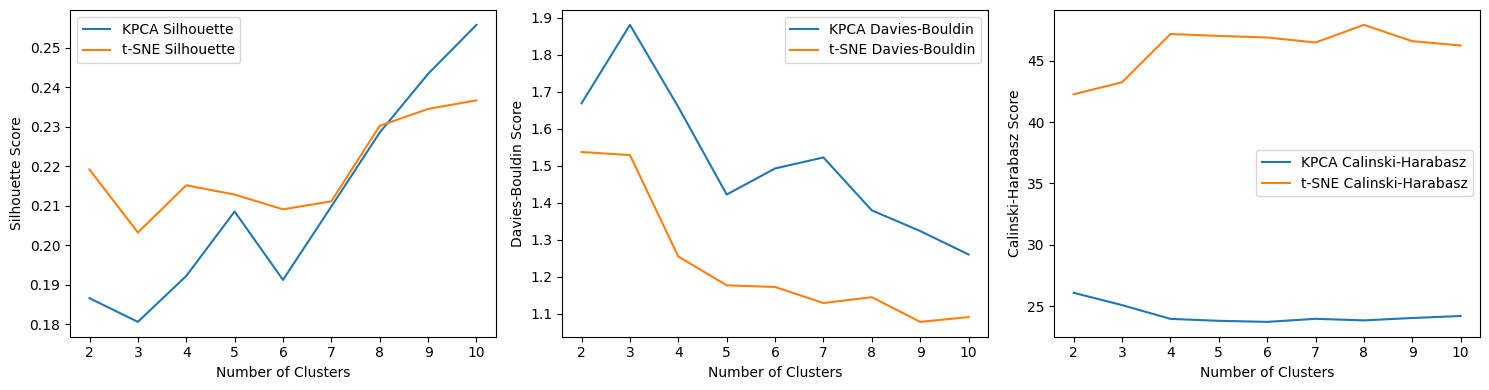

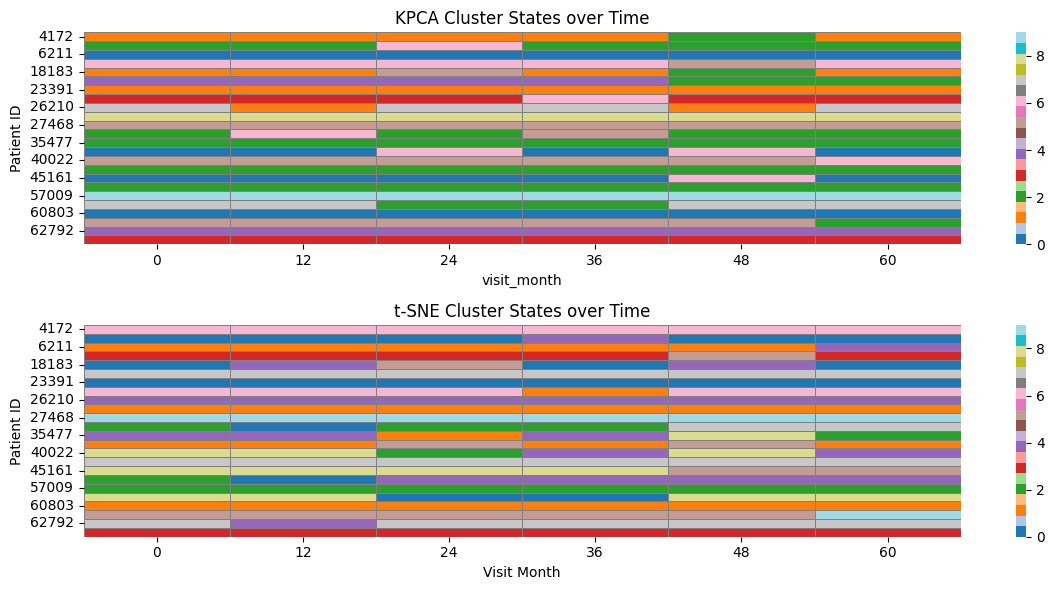

In [ ]:
'===========STEP2 : conventional method ============='
import pandas as pd
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df_selected is loaded: rows = samples (patient_id + visit_month), columns = peptide features
# df_selected = ... (your existing pivoted dataframe with features)
feature_columns = df_selected.columns.difference(['patient_id', 'visit_month'])

X = df_selected[feature_columns].values  # Feature matrix

# --- Add data validation checks ---
if np.isnan(X).any():
    print("Warning: NaN values found in feature matrix X.")
if np.isinf(X).any():
    print("Warning: Infinite values found in feature matrix X.")

# Remove constant columns
constant_columns = [col for col in feature_columns if df_selected[col].nunique() == 1]
if constant_columns:
    print(f"Removing constant columns: {constant_columns}")
    feature_columns = feature_columns.difference(constant_columns)
    X = df_selected[feature_columns].values

if X.shape[0] == 0 or X.shape[1] == 0:
    print("Error: Feature matrix is empty after removing constant columns.")
else:
    # Step 1: Feature reduction using KPCA and t-SNE
    print("Running Kernel PCA...")
    kpca = KernelPCA(n_components=min(10, X.shape[1]), kernel='rbf', random_state=42) # Adjust n_components if fewer features remain
    X_kpca = kpca.fit_transform(X)

    print("Running t-SNE...")
    # Adjust perplexity and learning_rate if needed. init='pca' requires n_components <= original features.
    tsne = TSNE(n_components=min(3, X.shape[1]), random_state=42, init='pca', learning_rate='auto') # Changed n_components to 3, min with actual features
    X_tsne = tsne.fit_transform(X)

    # Step 2: Cluster with hierarchical clustering and find best number of clusters by silhouette score
    def cluster_and_evaluate(X_reduced, max_clusters=10):
        best_score = -1
        best_n_clusters = 2
        best_labels = None

        scores = []
        db_scores = []
        ch_scores = []

        # Ensure max_clusters does not exceed the number of samples - 1
        max_clusters = min(max_clusters, X_reduced.shape[0] - 1)

        if max_clusters < 2:
             print("Not enough samples to perform clustering with at least 2 clusters.")
             return best_n_clusters, best_labels, scores, db_scores, ch_scores


        for n_clusters in range(2, max_clusters + 1):
            clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
            labels = clusterer.fit_predict(X_reduced)

            sil_score = silhouette_score(X_reduced, labels)
            db_score = davies_bouldin_score(X_reduced, labels)
            ch_score = calinski_harabasz_score(X_reduced, labels)

            scores.append(sil_score)
            db_scores.append(db_score)
            ch_scores.append(ch_score)

            if sil_score > best_score:
                best_score = sil_score
                best_n_clusters = n_clusters
                best_labels = labels

        return best_n_clusters, best_labels, scores, db_scores, ch_scores

    print("Clustering KPCA-reduced data...")
    best_kpca_clusters, kpca_labels, kpca_sil_scores, kpca_db_scores, kpca_ch_scores = cluster_and_evaluate(X_kpca)

    if kpca_labels is not None:
        print(f"Best KPCA cluster number: {best_kpca_clusters} with silhouette score {max(kpca_sil_scores):.4f}, DB score {max(kpca_db_scores):.4f}, CH score {max(kpca_db_scores):.4f}")
    else:
        print("Clustering on KPCA data could not be performed.")


    print("Clustering t-SNE-reduced data...")
    best_tsne_clusters, tsne_labels, tsne_sil_scores, tsne_db_scores, tsne_ch_scores = cluster_and_evaluate(X_tsne)

    if tsne_labels is not None:
        print(f"Best t-SNE cluster number: {best_tsne_clusters} with silhouette score {max(tsne_sil_scores):.4f}, DB {max(tsne_db_scores):.4f}, CH {max(tsne_ch_scores):.4f}")
    else:
         print("Clustering on t-SNE data could not be performed.")

    # Step 3: Plot silhouette, DB and CH scores for KPCA and t-SNE clustering
    # Only plot if clustering was performed and scores were generated
    if kpca_sil_scores and tsne_sil_scores:
        plt.figure(figsize=(15, 4))

        plt.subplot(1, 3, 1)
        plt.plot(range(2, 2 + len(kpca_sil_scores)), kpca_sil_scores, label='KPCA Silhouette')
        plt.plot(range(2, 2 + len(tsne_sil_scores)), tsne_sil_scores, label='t-SNE Silhouette')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(range(2, 2 + len(kpca_db_scores)), kpca_db_scores, label='KPCA Davies-Bouldin')
        plt.plot(range(2, 2 + len(tsne_db_scores)), tsne_db_scores, label='t-SNE Davies-Bouldin')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Davies-Bouldin Score')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(range(2, 2 + len(kpca_ch_scores)), kpca_ch_scores, label='KPCA Calinski-Harabasz')
        plt.plot(range(2, 2 + len(tsne_ch_scores)), tsne_ch_scores, label='t-SNE Calinski-Harabasz')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Calinski-Harabasz Score')
        plt.legend()

        plt.tight_layout()
        plt.show()
    else:
        print("Skipping score plots due to insufficient data for clustering.")


    # Step 4: Plot heatmaps of cluster states
    # Only plot heatmaps if clustering was successful for at least one method
    if kpca_labels is not None or tsne_labels is not None:
        # Create DataFrame of cluster labels
        cluster_df = pd.DataFrame({
            'patient_id': df_selected['patient_id'].values,
            'visit_month': df_selected['visit_month'].values
        })
        if kpca_labels is not None:
             cluster_df['KPCA Cluster'] = kpca_labels
        if tsne_labels is not None:
             cluster_df['t-SNE Cluster'] = tsne_labels


        # Sort by patient and visit_month for better visualization of trajectory
        cluster_df = cluster_df.sort_values(['patient_id', 'visit_month']).reset_index(drop=True)

        plt.figure(figsize=(12, 6))

        if kpca_labels is not None:
            # KPCA cluster heatmap
            plt.subplot(2, 1, 1)
            sns.heatmap(cluster_df.pivot(index='patient_id', columns='visit_month', values='KPCA Cluster'),
                        cmap='tab20', cbar=True, linewidths=0.5, linecolor='gray')
            plt.title('KPCA Cluster States over Time')
            plt.ylabel('Patient ID')

        if tsne_labels is not None:
            # t-SNE cluster heatmap
            # Adjust subplot index based on whether KPCA heatmap was plotted
            subplot_index = 2 if kpca_labels is not None else 1
            plt.subplot(2, 1, subplot_index)
            sns.heatmap(cluster_df.pivot(index='patient_id', columns='visit_month', values='t-SNE Cluster'),
                        cmap='tab20', cbar=True, linewidths=0.5, linecolor='gray')
            plt.title('t-SNE Cluster States over Time')
            plt.xlabel('Visit Month')
            plt.ylabel('Patient ID')

        plt.tight_layout()
        plt.show()
    else:
        print("Skipping heatmap plots due to unsuccessful clustering.")

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


/tmp/ipython-input-3959355792.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_selected['cluster_autoencoder'] = auto_labels


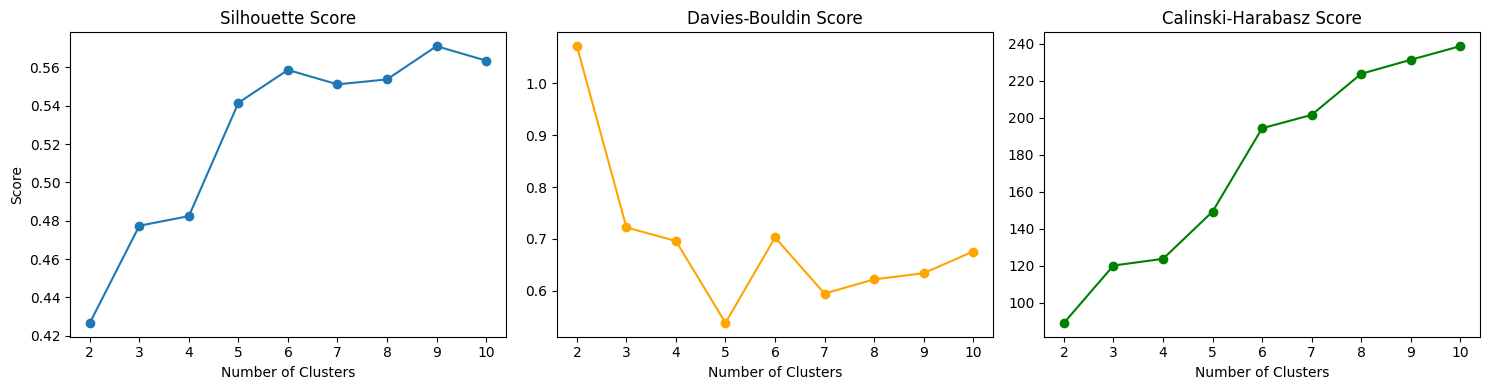

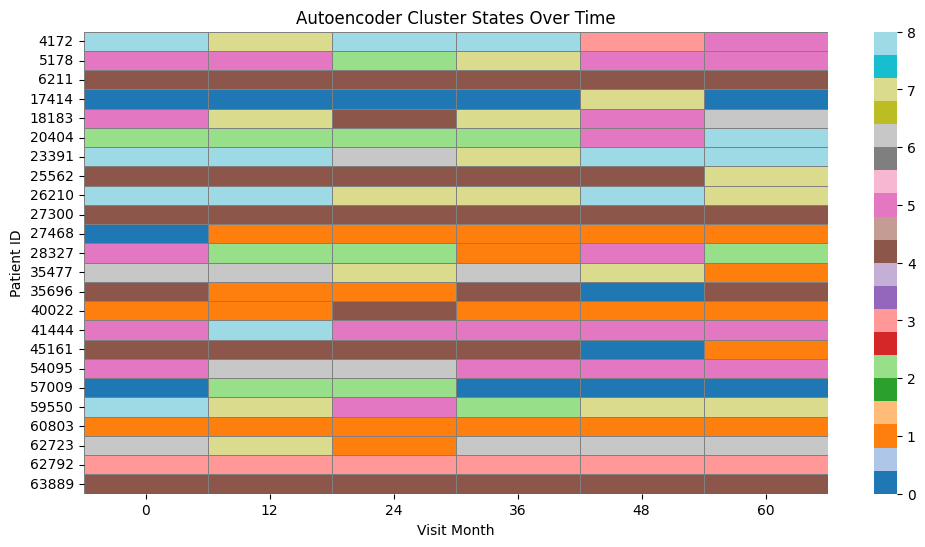

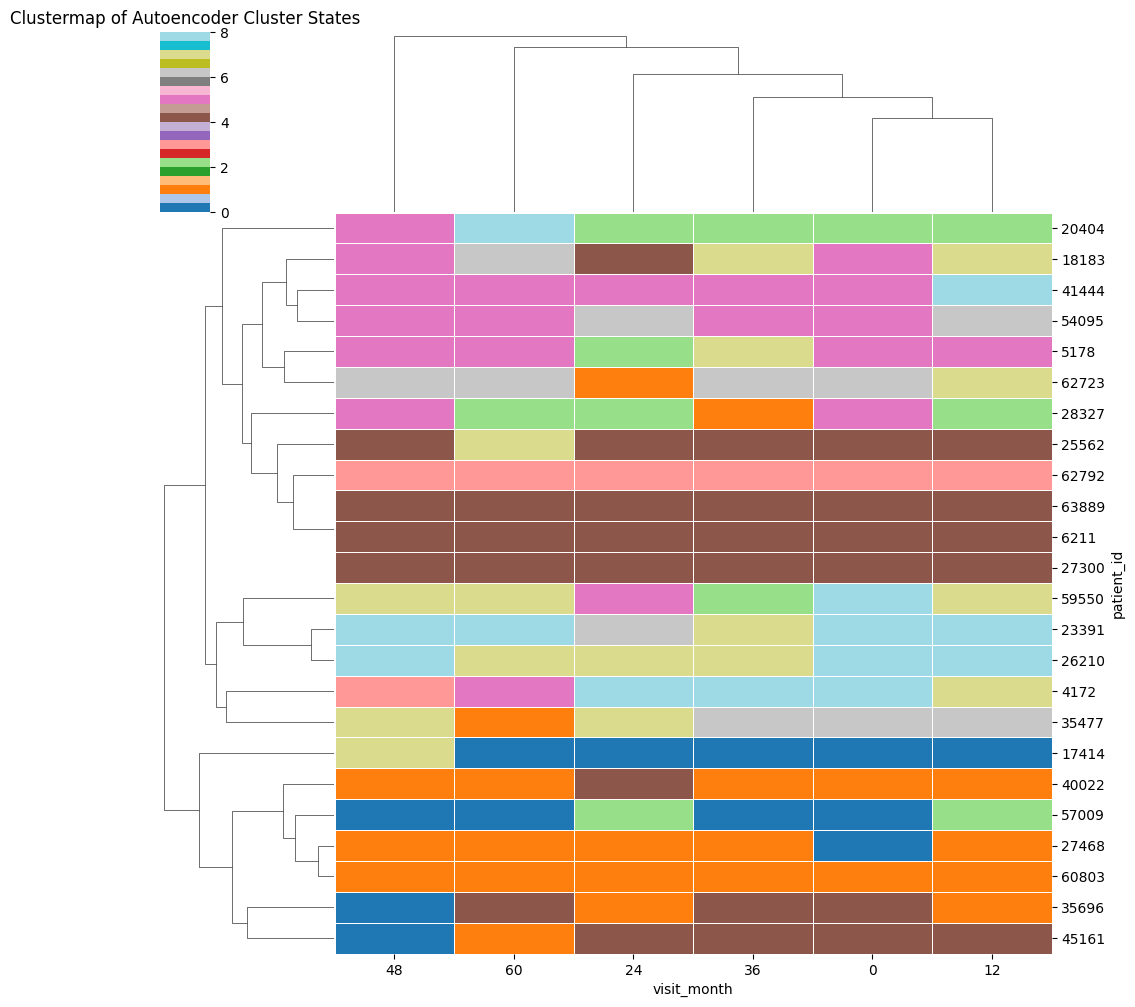

✅ Best number of clusters: 9
✅ Best silhouette score: 0.5711
✅ DB score: 0.6340
✅ CH score: 231.4239


In [ ]:
'===========STEP3 : Dense autoencoder ============='

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------ Step 1: Dense Autoencoder ------------------
X_scaled = df_selected.drop(columns=['patient_id', 'visit_month'])#StandardScaler().fit_transform(df_selected.drop(columns=['patient_id', 'visit_month']))

input_dim = X_scaled.shape[1]

encoding_dim = 2

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="linear")(encoder)
autoencoder = Model(input_layer, decoder)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_scaled, X_scaled, epochs=200, batch_size=1, shuffle=True, verbose=0)

encoder_model = Model(input_layer, encoder)
autoencoder_embeddings = encoder_model.predict(X_scaled)

# ------------------ Step 2: Clustering ------------------
def cluster_and_evaluate(X_embed, max_clusters=10):
    best_score = -1
    best_n = 2
    best_labels = None

    sil_scores, db_scores, ch_scores = [], [], []

    for n_clusters in range(2, max_clusters + 1):
        clustering = AgglomerativeClustering(n_clusters=n_clusters)
        labels = clustering.fit_predict(X_embed)

        sil = silhouette_score(X_embed, labels)
        db = davies_bouldin_score(X_embed, labels)
        ch = calinski_harabasz_score(X_embed, labels)

        sil_scores.append(sil)
        db_scores.append(db)
        ch_scores.append(ch)

        if sil > best_score:
            best_score = sil
            best_n = n_clusters
            best_labels = labels

    return best_n, best_labels, sil_scores, db_scores, ch_scores

best_n_clusters, auto_labels, sil_scores, db_scores, ch_scores = cluster_and_evaluate(autoencoder_embeddings)

df_selected['cluster_autoencoder'] = auto_labels

# ------------------ Step 3: Plot Scores ------------------
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(range(2, 2 + len(sil_scores)), sil_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")

plt.subplot(1, 3, 2)
plt.plot(range(2, 2 + len(db_scores)), db_scores, marker='o', color='orange')
plt.title("Davies-Bouldin Score")
plt.xlabel("Number of Clusters")

plt.subplot(1, 3, 3)
plt.plot(range(2, 2 + len(ch_scores)), ch_scores, marker='o', color='green')
plt.title("Calinski-Harabasz Score")
plt.xlabel("Number of Clusters")
plt.tight_layout()
plt.show()

# ------------------ Step 4: Heatmaps ------------------
heatmap_data = df_selected.pivot(index='patient_id', columns='visit_month', values='cluster_autoencoder').fillna(-1)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='tab20', cbar=True, linewidths=0.5, linecolor='gray')
plt.title('Autoencoder Cluster States Over Time')
plt.xlabel('Visit Month')
plt.ylabel('Patient ID')
plt.show()

# Clustermap
sns.clustermap(heatmap_data, cmap='tab20', linewidths=0.5, col_cluster=True, row_cluster=True)
plt.title("Clustermap of Autoencoder Cluster States")
plt.show()

# ------------------ Step 5: Output Summary ------------------
print(f"✅ Best number of clusters: {best_n_clusters}")
print(f"✅ Best silhouette score: {max(sil_scores):.4f}")
print(f"✅ DB score: {db_scores[sil_scores.index(max(sil_scores))]:.4f}")
print(f"✅ CH score: {ch_scores[sil_scores.index(max(sil_scores))]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


/tmp/ipython-input-560984664.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_selected['cluster_lstm'] = df_selected['patient_id'].map(patient_to_cluster)


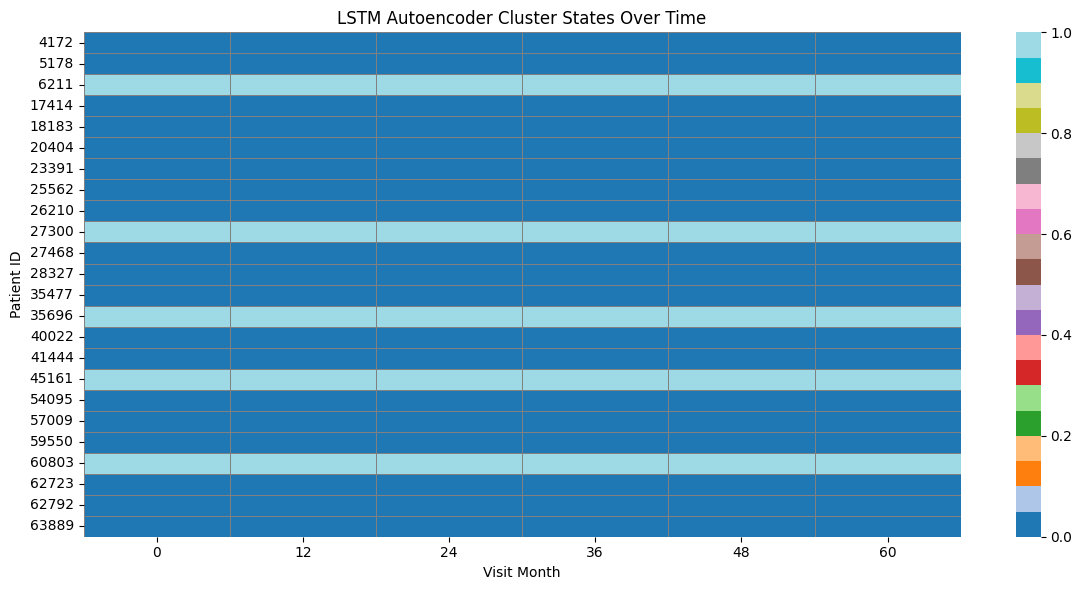

/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:623: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)


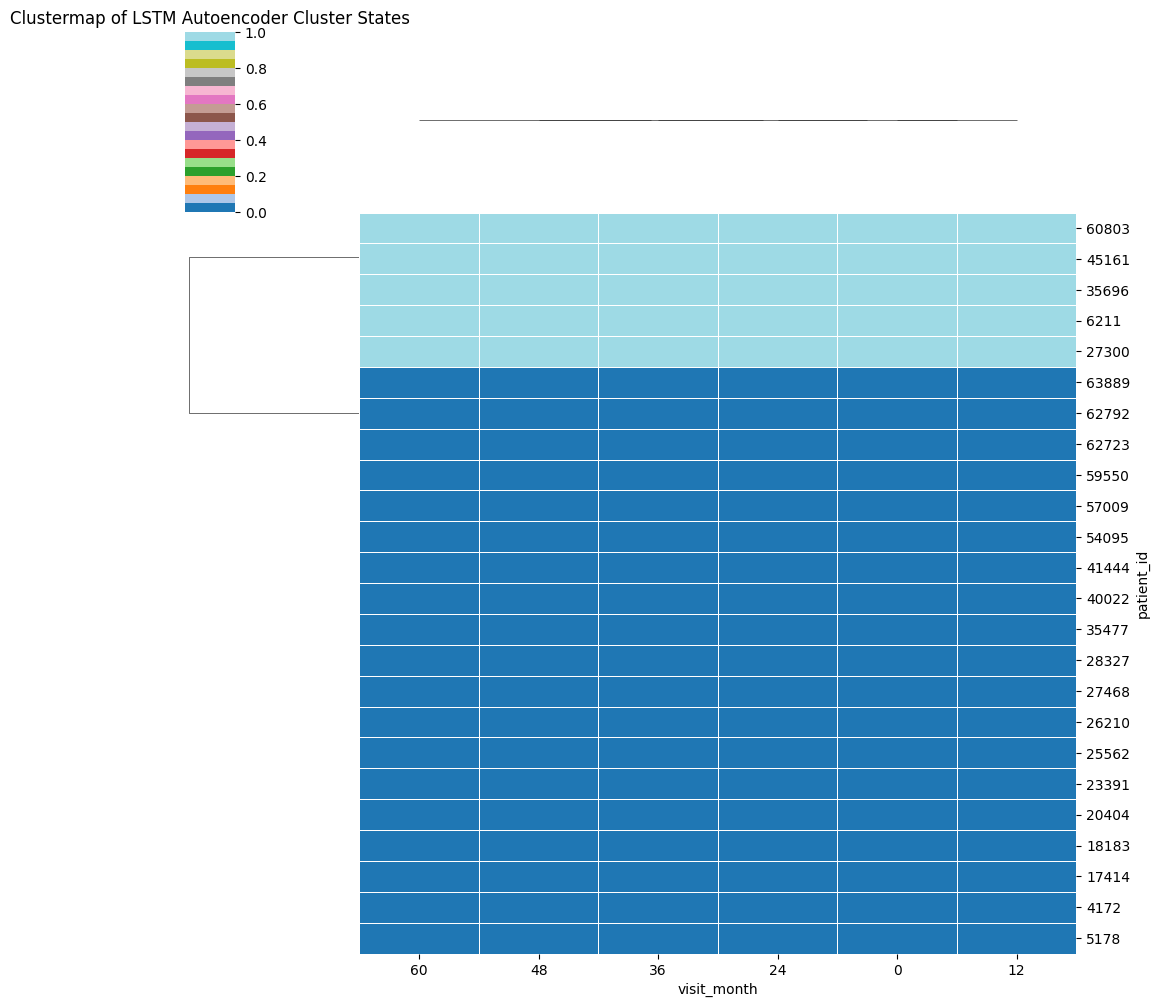

✅Best cluster count: 2
Silhouette Score: 0.7554
Davies-Bouldin Score: 0.3498
Calinski-Harabasz Score: 101.7607


In [ ]:
'lstm autoencoder'
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.optimizers import Adam


# Define and train LSTM Autoencoder
timesteps = len(df_selected['visit_month'].unique())
input_dim = X_scaled.shape[1]
latent_dim = 2
n_patients=len(df_selected['patient_id'].unique())
X_seq = X_scaled.values.reshape(n_patients, timesteps, input_dim) # Fixed: Convert to NumPy array before reshaping

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim, activation='relu')(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, activation='linear', return_sequences=True)(decoded) # Changed activation to 'linear'

lstm_autoencoder = Model(inputs, decoded)
lstm_autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
lstm_autoencoder.fit(X_seq, X_seq, epochs=50, batch_size=1, shuffle=True, verbose=0)

encoder_model = Model(inputs, encoded)
lstm_embeddings = encoder_model.predict(X_seq)

# Clustering
def cluster_and_evaluate(X_embed, max_clusters=10):
    best_score = -1
    best_n = 2
    best_labels = None
    sil_scores, db_scores, ch_scores = [], [], []

    # Ensure max_clusters does not exceed the number of samples - 1
    max_clusters = min(max_clusters, X_embed.shape[0] - 1)

    if max_clusters < 2:
        print("Not enough samples to perform clustering with at least 2 clusters.")
        return best_n, best_labels, sil_scores, db_scores, ch_scores


    for n_clusters in range(2, max_clusters + 1):
        clustering = AgglomerativeClustering(n_clusters=n_clusters)
        labels = clustering.fit_predict(X_embed)

        # Check if more than one cluster is formed before calculating metrics
        if len(np.unique(labels)) > 1:
            sil = silhouette_score(X_embed, labels)
            db = davies_bouldin_score(X_embed, labels)
            ch = calinski_harabasz_score(X_embed, labels)

            sil_scores.append(sil)
            db_scores.append(db)
            ch_scores.append(ch)

            if sil > best_score:
                best_score = sil
                best_n = n_clusters
                best_labels = labels
        else:
             print(f"Clustering with {n_clusters} resulted in only 1 cluster. Skipping metric calculation.")


    return best_n, best_labels, sil_scores, db_scores, ch_scores

best_n_clusters, auto_labels, sil_scores, db_scores, ch_scores = cluster_and_evaluate(lstm_embeddings)

# Assign cluster labels to the original df_selected for heatmap plotting
# Create a mapping from the patient IDs used for LSTM to their cluster labels
patient_ids_in_order = df_selected['patient_id'].unique()
patient_to_cluster = dict(zip(patient_ids_in_order, auto_labels))

df_selected['cluster_lstm'] = df_selected['patient_id'].map(patient_to_cluster)


# Heatmap
heatmap_data = df_selected.pivot(index='patient_id', columns='visit_month', values='cluster_lstm').fillna(-1)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='tab20', cbar=True, linewidths=0.5, linecolor='gray')
plt.title('LSTM Autoencoder Cluster States Over Time')
plt.xlabel('Visit Month')
plt.ylabel('Patient ID')
plt.tight_layout()
plt.show()

# Clustermap
sns.clustermap(heatmap_data, cmap='tab20', linewidths=0.5, col_cluster=True, row_cluster=True)
plt.title("Clustermap of LSTM Autoencoder Cluster States")
plt.show()

# Print best cluster results (only if clustering was performed and valid scores exist)
if sil_scores: # Check if sil_scores list is not empty
    print(f"✅Best cluster count: {best_n_clusters}")
    print(f"Silhouette Score: {max(sil_scores):.4f}")
    # Find the index of the max silhouette score to get corresponding DB and CH scores
    best_sil_index = sil_scores.index(max(sil_scores))
    print(f"Davies-Bouldin Score: {db_scores[best_sil_index]:.4f}")
    print(f"Calinski-Harabasz Score: {ch_scores[best_sil_index]:.4f}")
else:
    print("Clustering metrics could not be calculated (likely due to insufficient valid clusters).")

In [ ]:
'-------Graph Related Implementations ----------'

#df_selected=df_final_peptides.copy(deep=True)
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define feature columns
feature_columns = df_selected.columns.difference(['patient_id', 'visit_month'])

# Step 2: Normalize features (scale each feature to [0, 1])
scale = StandardScaler()
df_selected[feature_columns] = scale.fit_transform(df_selected[feature_columns])

scaler = MinMaxScaler()
#df_selected[feature_columns] = scaler.fit_transform(df_selected[feature_columns])

In [ ]:
' Get the similarity threshold and standarize the features'
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
"""
# Step 1: Define feature columns
feature_columns = df_selected.columns.difference(['patient_id', 'visit_month'])

# Step 2: Standardize the features
'''
scaler = StandardScaler()
df_selected[feature_columns] = scaler.fit_transform(df_selected[feature_columns])
'''


'''
from sklearn.preprocessing import MinMaxScaler
# Step 2: Normalize features (scale each feature to [0, 1])
scaler = MinMaxScaler()
df_selected[feature_columns] = scaler.fit_transform(df_selected[feature_columns])
'''


# Step 3: Get the unique months
similar_pair_counts = []
selected_ages = sorted(set(df_selected['visit_month']))  # One graph per time step

for age in selected_ages:
    year_data = df_selected[df_selected['visit_month'] == age].reset_index(drop=True)

    num_patients = len(year_data)
    if num_patients < 2:
        similar_pair_counts.append(0)
        continue
    # Collect all pairwise distances
    distances = []
    for i in range(num_patients):
        for j in range(i + 1, num_patients):
            patient_i = year_data.loc[i, feature_columns].values
            patient_j = year_data.loc[j, feature_columns].values
            dist = np.linalg.norm(patient_i - patient_j)  # Euclidean distance
            distances.append((i, j, dist))

    # Extract just the distance values
    dist_values = [d[2] for d in distances]

    # Get 25th percentile distance threshold (smallest = most similar)
    if len(dist_values) == 0:
        similar_pair_counts.append(0)
        continue

    threshold_25 = np.percentile(dist_values, 10)

    # Count pairs below the threshold (i.e., most similar)
    count_similar = sum(1 for _, _, d in distances if d <= threshold_25)
    similar_pair_counts.append(count_similar)

average_similar_pairs = np.mean(similar_pair_counts)
print(f"Average number of 25% most similar patient: {average_similar_pairs:.2f}")
"""

'\n# Step 1: Define feature columns\nfeature_columns = df_selected.columns.difference([\'patient_id\', \'visit_month\'])\n\n# Step 2: Standardize the features\n\'\'\'\nscaler = StandardScaler()\ndf_selected[feature_columns] = scaler.fit_transform(df_selected[feature_columns])\n\'\'\'\n\n\n\'\'\'\nfrom sklearn.preprocessing import MinMaxScaler\n# Step 2: Normalize features (scale each feature to [0, 1])\nscaler = MinMaxScaler()\ndf_selected[feature_columns] = scaler.fit_transform(df_selected[feature_columns])\n\'\'\'\n\n\n# Step 3: Get the unique months\nsimilar_pair_counts = []\nselected_ages = sorted(set(df_selected[\'visit_month\']))  # One graph per time step\n\nfor age in selected_ages:\n    year_data = df_selected[df_selected[\'visit_month\'] == age].reset_index(drop=True)\n\n    num_patients = len(year_data)\n    if num_patients < 2:\n        similar_pair_counts.append(0)\n        continue\n    # Collect all pairwise distances\n    distances = []\n    for i in range(num_patients)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Step 1: Define feature columns
feature_columns = df_selected.columns.difference(['patient_id', 'visit_month'])

# Step 2: Standardize features
# Step 2: Standardize the features

scaler = StandardScaler()
df_selected[feature_columns] = scaler.fit_transform(df_selected[feature_columns])



'''
from sklearn.preprocessing import MinMaxScaler
# Step 2: Normalize features (scale each feature to [0, 1])
scaler = MinMaxScaler()
df_selected[feature_columns] = scaler.fit_transform(df_selected[feature_columns])
'''


# Step 3: Calculate the 90th percentile similarity per age, then average these thresholds
thresholds_per_age = []
selected_ages = sorted(df_selected['visit_month'].unique())

for age in selected_ages:
    year_data = df_selected[df_selected['visit_month'] == age].reset_index(drop=True)
    num_patients = len(year_data)

    if num_patients < 2:
        continue  # skip ages with less than 2 patients

    similarities = []
    for i in range(num_patients):
        for j in range(i + 1, num_patients):
            patient_i = year_data.loc[i, feature_columns].values.reshape(1, -1)
            patient_j = year_data.loc[j, feature_columns].values.reshape(1, -1)
            sim = cosine_similarity(patient_i, patient_j)[0][0]
            similarities.append(sim)

    if similarities:
        # Get 90th percentile for this age
        threshold_90 = np.percentile(similarities, 95)
        thresholds_per_age.append(threshold_90)

# Calculate mean of 90th percentile thresholds across all ages
average_similar_pairs = np.mean(thresholds_per_age)
print(f"Global similarity threshold (mean of 90th percentiles): {average_similar_pairs:.4f}")


Global similarity threshold (mean of 90th percentiles): 0.3019


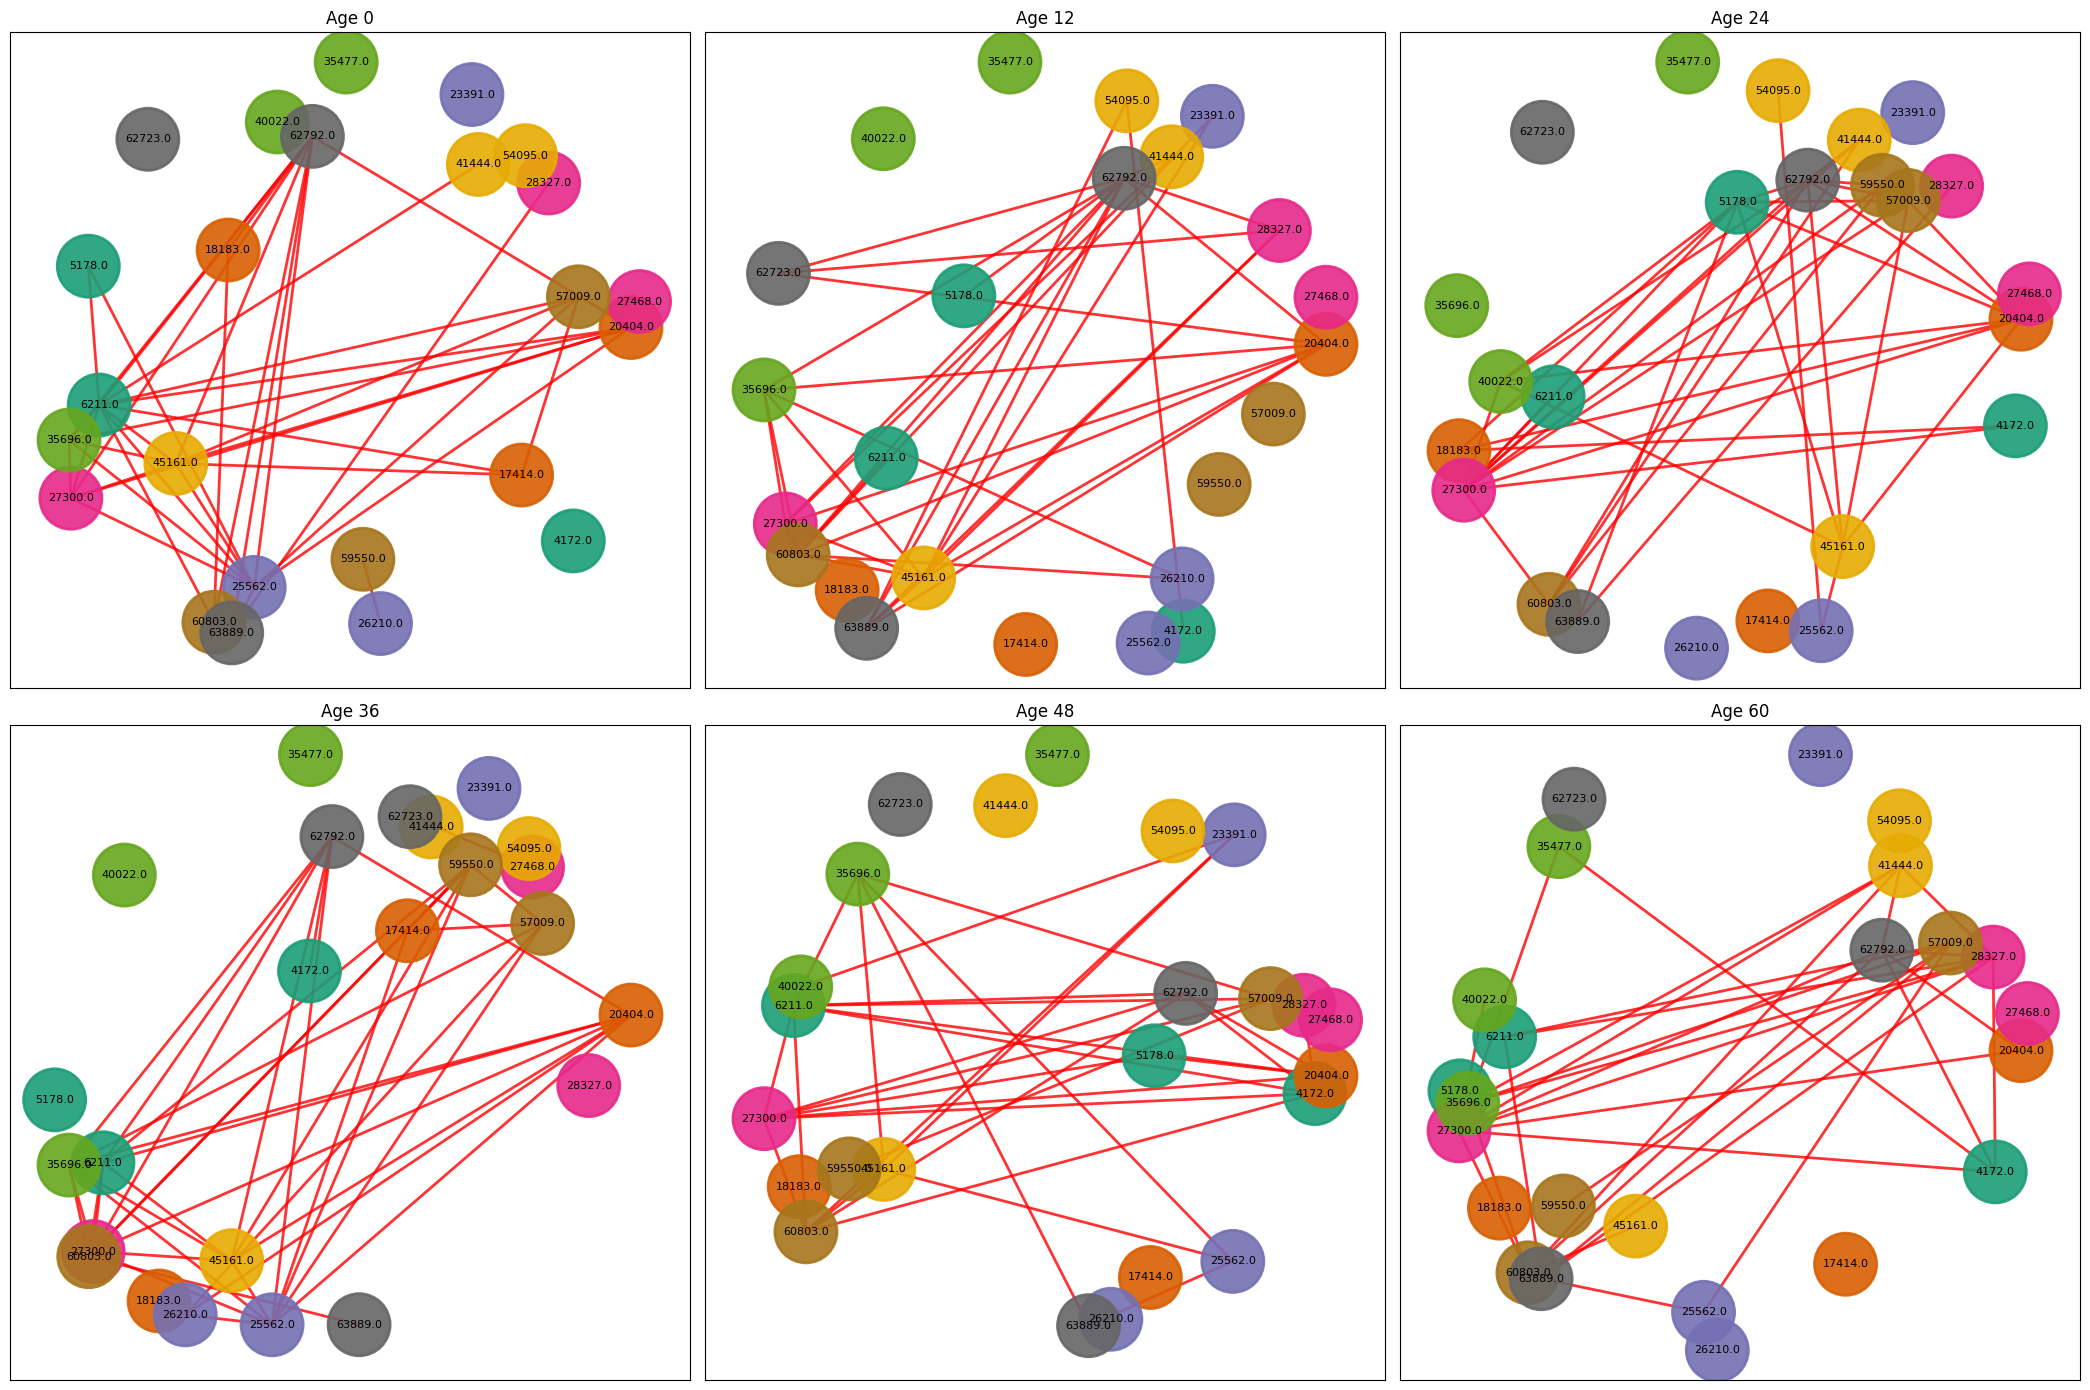

'\nX and Y Coordinates: Primarily determine by the spring layout algorithm to reduce visual crossing of edges.\nFeature Similarity: Nodes with similar patterns of feature values are more likely to be positioned near each other.\nInterconnectedness: Nodes connected by stronger (high correlation coefficient value) are often positioned closer to each other.\n'

In [ ]:
'FIRST: Visualize Just present the dataset features and its pattern by time'
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import pearsonr
from matplotlib.patches import Ellipse  # Import Ellipse for drawing circles
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

threshold=average_similar_pairs

def euclidean_perm_test(vec1, vec2):
    observed = euclidean_distances(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]
    return observed#, p_value

def cosine_similarity_score(vec1, vec2):
    # Reshape for pairwise computation
    vec1 = vec1.reshape(1, -1)
    vec2 = vec2.reshape(1, -1)

    # Compute cosine similarity
    similarity = cosine_similarity(vec1, vec2)[0][0]
    return similarity
def adjust_color_intensity(color, intensity):
    """Adjusts the intensity of a color, making it lighter with higher intensity.
    Args:
        color: A tuple or list representing the color (e.g., (R, G, B, A)).
        intensity: A float between 0 and 1 representing the desired intensity.
    Returns:
        A tuple or list representing the adjusted color.
    """
    # Convert color to RGB if it's in other formats

    r, g, b, a = color

    # Calculate how much to lighten each color component
    intensity = np.clip(intensity, 0.1, 1)
    lighten_factor = (1 - intensity)**100
    # Apply the lightening factor
    r = r + (1 - r) * lighten_factor
    g = g + (1 - g) * lighten_factor
    b = b + (1 - b) * lighten_factor

    return (r, g, b, a)  # Return as RGBA tuple



# Unique ages in the dataset (assuming they are integers)
'''
# Filter ages based on starting year and time step
selected_ages = set(df_selected['visit_month'])

feature_columns = df_selected.columns.difference(['patient_id', 'visit_month'])  # Exclude non-feature columns  #^^^^^ To have only motor symptoms

scaler = StandardScaler()
df_selected[feature_columns] = scaler.fit_transform(df_selected[feature_columns])
'''
time_step = 1

# Create subplots
num_plots = len(selected_ages)
num_cols = min(num_plots, 3)  # Limit columns to 4
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 7, num_rows * 7))
fig.subplots_adjust(left=0.1, right=1, bottom=0.1, top=0.9)

graphs=[]
# Iterate through selected ages and create graphs
for plot_index, age in enumerate(selected_ages): # Change i to plot_index
    year_data = df_selected[df_selected['visit_month'] == age]
    G = nx.Graph()
    added_edges = set()
    edge_thickness = {}

    # Add nodes for this age group
    for _, row in year_data.iterrows():
        # Add original features directly to the node
        features = {feature: row[feature] for feature in feature_columns}
        G.add_node(row['patient_id'], **features)  # ,age=row['age'], removed

    for i, row1 in year_data.iterrows():
        for j, row2 in year_data.iterrows():
            if i != j and row1['patient_id'] != row2['patient_id']:
                pair = tuple(sorted((row1['patient_id'], row2['patient_id'])))
                if pair not in added_edges:
                    similarity= cosine_similarity_score(row1[feature_columns].values.astype(float), row2[feature_columns].values.astype(float))
                    if abs(similarity) >= threshold:
                        G.add_edge(row1['patient_id'], row2['patient_id'],weight=similarity)
                        added_edges.add(pair)

    # ----> Append the graph to the list <----
    graphs.append(G)


   # Plotting on the current subplot
    pos = nx.spring_layout(G, seed=15, k=0.4, scale=1) # Initial layout
    # 2. Distinct node color for each 'subjid' with fade-out
    unique_subjids = list(G.nodes())
    num_subjids = len(unique_subjids)
    color_map_subjid = plt.get_cmap('Dark2', num_subjids)
    node_colors_subjid = [
        adjust_color_intensity(color_map_subjid(unique_subjids.index(n)),
                                np.mean([G.nodes[n].get(feature, 0) for feature in feature_columns]))
        for n in G.nodes()
    ]


    # Draw nodes once outside the loop:
    # Draw nodes once outside the loop:
    row_index = plot_index // num_cols
    col_index = plot_index % num_cols

    if num_plots > 1:
        ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]
    else:
        ax = axes

    nx.draw_networkx_nodes(G, pos, node_color=node_colors_subjid,node_size=2000, linewidths=2, alpha=0.9, ax=ax)
    # Draw edges with boundary and color based on CAG
    # Draw edges with correlation-based color only
    nx.draw_networkx_edges(G, pos, width=[edge_thickness.get(edge, 1) * 2 for edge in G.edges()],
                               edge_color='Red', alpha=0.8, ax=ax)#axes[plot_index])


    # Add labels:
    labels = {node: node for node in G.nodes()}
    # Pass the correct Axes object using row_index and col_index:
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black', ax=axes[row_index, col_index] if num_rows > 1 else axes[col_index])
    # Set title for the current subplot correctly:
    (axes[row_index, col_index] if num_rows > 1 else axes[col_index]).set_title(f"Age {age}")
# Adjust layout and display the plot
#fig.set_size_inches(15, 8)  # Adjust overall figure size

plt.tight_layout()
plt.show()

'''
X and Y Coordinates: Primarily determine by the spring layout algorithm to reduce visual crossing of edges.
Feature Similarity: Nodes with similar patterns of feature values are more likely to be positioned near each other.
Interconnectedness: Nodes connected by stronger (high correlation coefficient value) are often positioned closer to each other.
'''

In [ ]:
'STEP3:TEMPORAL EMBEDDINGS [With spatial consideration]-TGCN (GCN+GRU)'
'T-GCN (1/4) - Load the graph'
#Install dependencies (if needed)
!pip install torch_geometric
#!pip install tensorboard

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, GAE
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

#===========Again creating the graph ================================
# Build graphs
'''
graphs = []

for plot_index, age in enumerate(selected_ages): # Change i to plot_index
    year_data = df_selected[df_selected['visit_month'] == age]
    G = nx.Graph()
    added_edges = set()
    edge_thickness = {}

    # Add nodes for this age group
    for _, row in year_data.iterrows():
        # Add original features directly to the node
        features = {feature: row[feature] for feature in feature_columns}
        G.add_node(row['patient_id'],  **features)

    for i, row1 in year_data.iterrows():
        for j, row2 in year_data.iterrows():
            if i != j and row1['patient_id'] != row2['patient_id']:
                pair = tuple(sorted((row1['patient_id'], row2['patient_id'])))
                if pair not in added_edges:
                  similarity= euclidean_perm_test(row1[feature_columns].values.astype(float), row2[feature_columns].values.astype(float))
                  if similarity < threshold:# and p_value <= 0.05:
                        G.add_edge(row1['patient_id'], row2['patient_id'])#, p_value=p_value)
                        added_edges.add(pair) #This is only useful if you're checking for duplicate edges before adding them.
    # ----> Append the graph to the list <----
    graphs.append(G)
'''
# ========== 1. Prepare Data ================

all_data = []

for graph in graphs:
    # Get the actual feature columns present in this specific graph's nodes
    graph_feature_columns = [col for col in feature_columns if col in list(graph.nodes[list(graph.nodes())[0]].keys())]

    node_features = np.array([
        [graph.nodes[node][feature] for feature in graph_feature_columns]
        for node in graph.nodes
    ])
    node_to_index = {node: i for i, node in enumerate(graph.nodes)}

    # Check if the graph has edges before creating edge_index
    if graph.edges():  # If graph has edges
        edge_index = np.array([(node_to_index[u], node_to_index[v])
                               for u, v in graph.edges]).T
    else:  # If graph has no edges
        edge_index = np.empty((2, 0), dtype=int)  # Create an empty edge_index

    data = Data(x=torch.tensor(node_features, dtype=torch.float),
                edge_index=torch.tensor(edge_index, dtype=torch.long))
    all_data.append(data)

print('all_data shape: ', len(all_data), ' ', all_data[0].x.shape)

all_data shape:  6   torch.Size([24, 968])


In [ ]:
'T-GCN'
'T-GCN (2/4) - Train the model'

# ========== 2. Define T-GCN (GCN + GRU) ==========

class TGCNEncoder(nn.Module):
    def __init__(self, input_dim, gcn_hidden_dim, gru_hidden_dim):
        super().__init__()
        self.gcn = GCNConv(input_dim, gcn_hidden_dim)
        self.gru = nn.GRU(gcn_hidden_dim, gru_hidden_dim, batch_first=True)

    def forward(self, x_seq, edge_index_seq):
        '''
        x_seq: [T, N, F]
        edge_index_seq: list of edge_index per time step
        '''
        gcn_out = []
        for t in range(x_seq.size(0)):
            x_t = x_seq[t]  # [N, F]
            edge_index_t = edge_index_seq[t]
            h_t = F.relu(self.gcn(x_t, edge_index_t))  # [N, gcn_hidden]
            gcn_out.append(h_t)

        gcn_out = torch.stack(gcn_out, dim=0)  # [T, N, gcn_hidden]
        gcn_out = gcn_out.permute(1, 0, 2)     # [N, T, gcn_hidden]
        out, _ = self.gru(gcn_out)             # [N, T, gru_hidden]
        return out#[:, -1, :]                   # return final hidden state per node



# ========== 3. TensorBoard Setup ==========
log_dir = f"runs/gae_gcn_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
writer = SummaryWriter(log_dir)

# ========== 4. Training ==========

def train(x_seq, edge_index_seq):
    encoder.train()
    optimizer.zero_grad()
    z = encoder(x_seq, edge_index_seq)         # [N, T, D]
    z = z.permute(1, 0, 2)                     # [T, N, D]
    loss = reconstruction_loss(z, edge_index_seq)
    loss.backward()
    optimizer.step()
    return loss.item(), z

from torch_geometric.utils import to_dense_adj

def reconstruction_loss(embeddings, edge_index_seq):
    loss = 0
    T = min(embeddings.shape[0], len(edge_index_seq))
    for t in range(T):
        emb_t = embeddings[t]
        pred_adj = torch.sigmoid(emb_t @ emb_t.T)
        adj_dense = to_dense_adj(edge_index_seq[t], max_num_nodes=emb_t.size(0))[0]
        # BCE loss averaged over all node pairs
        loss += F.binary_cross_entropy(pred_adj, adj_dense, reduction='mean')
    return loss / T  # average over time steps


# Convert list of Data objects to tensors
x_seq = torch.stack([data.x for data in all_data], dim=0)  # [T, N, F]
edge_index_seq = [data.edge_index for data in all_data]    # List of [2, E]
# Get the node features at the last time step and only select the
# first 'gru_hidden_dim' features to match the output of the GRU
#target = x_seq[-1, :, :encoder.gru.hidden_size]  #[last time step, all features, the number of features /or gru hidden dimention]

# Training loop
'''
best_loss=1000
Numbers=[2,4,8,16,32,64,128]
for i in Numbers:
  for j in Numbers:
'''
encoder = TGCNEncoder(
    input_dim=all_data[0].num_node_features,
    gcn_hidden_dim=16,#64,#24, #32
    gru_hidden_dim=8#all_data[0].num_node_features
)
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01 )
for epoch in range(1, 500):
    loss, z = train(x_seq, edge_index_seq)
    if epoch % 20 == 0:
        #writer.add_embedding(z, global_step=epoch, tag="TGCN Embeddings")
        print(f"Epoch {epoch}, Loss: {loss:.4f}")
'''
        if loss < best_loss:
          best_loss=loss
          best_i=i
          best_j=j
print(f">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Epoch {epoch}, Loss: {loss:.4f}", i, j)

# Log to TensorBoard
#writer.add_scalar("Loss/train", loss, epoch)
writer.close()
'''
encoder.eval()

# ========== 5. Post Training Node Embedding Extraction ==========


with torch.no_grad():
    final_node_embeddings_s = encoder(x_seq, edge_index_seq)
    final_node_embeddings_g = final_node_embeddings_s[:, -1, :]  # [N, D]


Epoch 20, Loss: 0.6942
Epoch 40, Loss: 0.6892
Epoch 60, Loss: 0.6865
Epoch 80, Loss: 0.6844
Epoch 100, Loss: 0.6827
Epoch 120, Loss: 0.6814
Epoch 140, Loss: 0.6803
Epoch 160, Loss: 0.6791
Epoch 180, Loss: 0.6783
Epoch 200, Loss: 0.6778
Epoch 220, Loss: 0.6774
Epoch 240, Loss: 0.6771
Epoch 260, Loss: 0.6769
Epoch 280, Loss: 0.6767
Epoch 300, Loss: 0.6765
Epoch 320, Loss: 0.6766
Epoch 340, Loss: 0.6763
Epoch 360, Loss: 0.6761
Epoch 380, Loss: 0.6762
Epoch 400, Loss: 0.6760
Epoch 420, Loss: 0.6759
Epoch 440, Loss: 0.6758
Epoch 460, Loss: 0.6757
Epoch 480, Loss: 0.6756


K = 2:
  Silhouette Score = 0.3085 (Higher is better)
  Davies-Bouldin Index = 1.3550 (Lower is better)
  Calinski-Harabasz Index = 10.3942 (Higher is better)
---
K = 3:
  Silhouette Score = 0.3143 (Higher is better)
  Davies-Bouldin Index = 1.0570 (Lower is better)
  Calinski-Harabasz Index = 8.7777 (Higher is better)
---
K = 4:
  Silhouette Score = 0.3627 (Higher is better)
  Davies-Bouldin Index = 0.9709 (Lower is better)
  Calinski-Harabasz Index = 11.9052 (Higher is better)
---
K = 5:
  Silhouette Score = 0.3574 (Higher is better)
  Davies-Bouldin Index = 0.8062 (Lower is better)
  Calinski-Harabasz Index = 10.9147 (Higher is better)
---
K = 6:
  Silhouette Score = 0.3752 (Higher is better)
  Davies-Bouldin Index = 0.7557 (Lower is better)
  Calinski-Harabasz Index = 11.4572 (Higher is better)
---
K = 7:
  Silhouette Score = 0.3285 (Higher is better)
  Davies-Bouldin Index = 0.6087 (Lower is better)
  Calinski-Harabasz Index = 10.4010 (Higher is better)
---
K = 8:
  Silhouette Sco

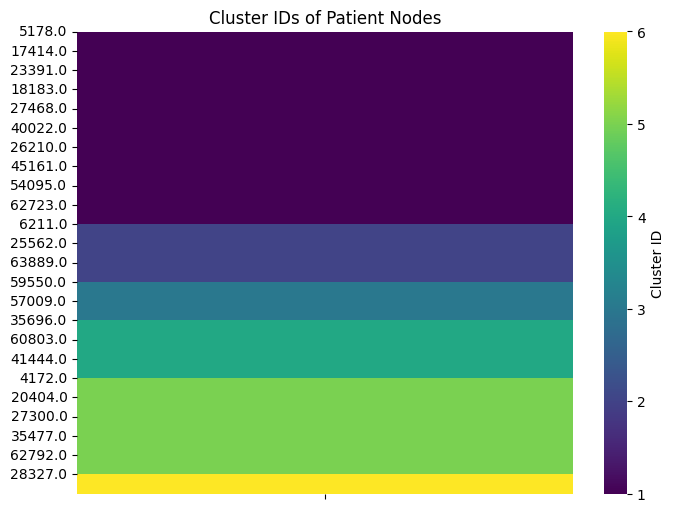

In [ ]:
'Temporal Clustering and Plot - ONLY TO PLOT PATIENT CLUSTER for T-GCN'
'T-GCN (3/4) - Group Clustering'

# ========== 6. Clustering and Visualization ==========

from scipy.cluster.hierarchy import linkage, fcluster
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# 1. Prepare node embeddings from the last time step
embeddings_np = final_node_embeddings_g.cpu().numpy()

# Standardize the embeddings (important for linkage)
scaler = StandardScaler()
embeddings_scaled = embeddings_np#scaler.fit_transform(embeddings_np)

# Perform linkage clustering
linked = linkage(embeddings_scaled, method='average')  # You can experiment with other methods

# 2. Evaluate clustering metrics for different cluster counts
Best_k = 2 # Initialize Best_k to a valid value
Best_silhouette = -1
Best_dbi = float('inf')  # Lower DBI is better
Best_chi = -1  # Higher CHI is better

# Get the number of samples from the embedding matrix
n_samples = embeddings_scaled.shape[0]


for k in range(2, min(n_samples, 20)): # Adjust the upper bound to min(n_samples, 20)
    labels = fcluster(linked, k, criterion='maxclust')

    # Skip if only one cluster is formed (invalid for some metrics)
    if len(np.unique(labels)) == 1:
        continue

    # Compute all three metrics
    silhouette = silhouette_score(embeddings_scaled, labels)
    dbi = davies_bouldin_score(embeddings_scaled, labels)
    chi = calinski_harabasz_score(embeddings_scaled, labels)

    print(f"K = {k}:")
    print(f"  Silhouette Score = {silhouette:.4f} (Higher is better)")
    print(f"  Davies-Bouldin Index = {dbi:.4f} (Lower is better)")
    print(f"  Calinski-Harabasz Index = {chi:.4f} (Higher is better)")
    print("---")

    # Update best K based on Silhouette (or another metric of choice)
    if silhouette > Best_silhouette:
        Best_silhouette = silhouette
        Best_k = k
        Best_dbi = dbi
        Best_chi = chi

print(f"\nBest K based on Silhouette Score: {Best_k}")
print(f"  Best Silhouette = {Best_silhouette:.4f}")
print(f"  Corresponding DBI = {Best_dbi:.4f}")
print(f"  Corresponding CHI = {Best_chi:.4f}")

# Final clustering with best_k
cluster_labels = fcluster(linked, t=Best_k, criterion='maxclust') # Use t=Best_k
# *** Calculate Silhouette Score ***
silhouette_avg = silhouette_score(embeddings_scaled, cluster_labels)

# 2. Create a dictionary to map participant IDs to their cluster labels
node_cluster_mapping = {}
for i, node in enumerate(graphs[-1].nodes()):
    node_cluster_mapping[node] = cluster_labels[i]

# 3. Draw heatmap

# Now we need to create the heatmap
# Example: patient_node_labels are the patient node IDs (these could be actual patient IDs or node indices)
patient_node_labels = list(graphs[-1].nodes())  # Assuming nodes are your patient IDs
# Cluster labels for each patient node
cluster_values = [node_cluster_mapping[node] for node in patient_node_labels]

# Create a DataFrame to plot with Seaborn
# Since it's a single cluster ID per patient, we make a single-column DataFrame
cluster_df = pd.DataFrame(cluster_values, columns=[""], index=patient_node_labels)
cluster_df_sorted = cluster_df.sort_values(by=[""])  # Use column name for sorting

# Plotting the heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cluster_df_sorted, cmap="viridis", cbar_kws={'label': 'Cluster ID'}, annot=False, fmt='d', cbar=True)

# 4. Update y-axis labels to reflect clustering
ax.set_yticks(range(len(cluster_df_sorted)))  # Set the y-ticks to match label count
ax.set_yticklabels(cluster_df_sorted.index, rotation=0)

# Customize labels and title
plt.title("Cluster IDs of Patient Nodes")

plt.show()


Best K based on Silhouette Score: 2
  Silhouette Score = 0.3264 (Higher is better)
  Davies-Bouldin Index = 1.3703 (Lower is better)
  Calinski-Harabasz Index = 63.1277 (Higher is better)
---


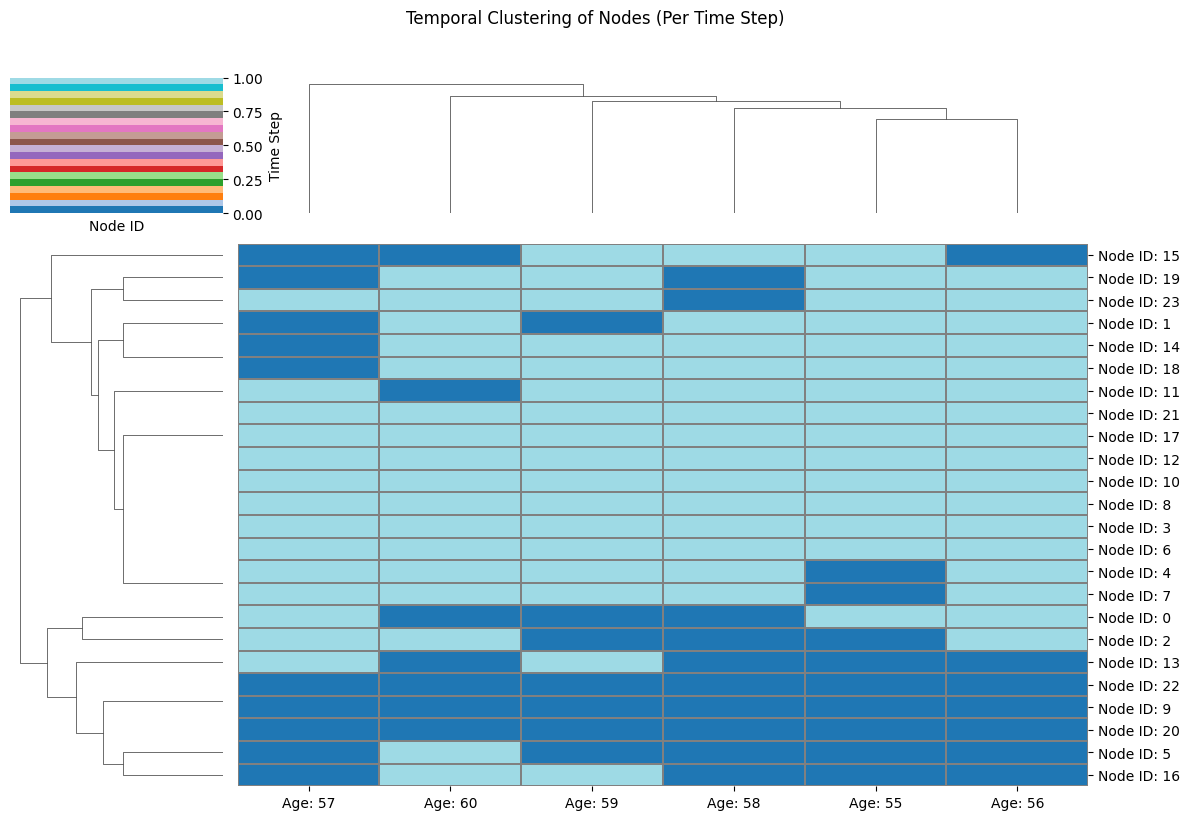

In [ ]:
'T-GCN (4/4) - states clustering'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score

T, N, D = final_node_embeddings_s.shape


# Step 1: Reshape to [T*N, D] for clustering
all_embeddings = final_node_embeddings_s.reshape(T * N, D)

# Step 2: Standardize the embeddings
scaler = StandardScaler()
embeddings_scaled = all_embeddings#scaler.fit_transform(all_embeddings)

# Step 3: Perform hierarchical clustering
linked = linkage(embeddings_scaled, method='ward')  # or 'average'

# Step 4: Evaluate clustering metrics to choose best k
best_k = 2
best_silhouette = -1
best_dbi = float('inf')
best_chi = -1

for k in range(2, min(10, T * N)):
    labels = fcluster(linked, k, criterion='maxclust')

    if len(set(labels)) == 1:
        continue

    silhouette = silhouette_score(embeddings_scaled, labels)
    dbi = davies_bouldin_score(embeddings_scaled, labels)
    chi = calinski_harabasz_score(embeddings_scaled, labels)

    if (silhouette > best_silhouette) or (
        silhouette == best_silhouette and dbi < best_dbi):
        best_k = k
        best_silhouette = silhouette
        best_dbi = dbi
        best_chi = chi
        best_labels = labels

# Step 5: Convert to 0-based labels
best_labels = np.array(best_labels) - 1  # shape: [T*N]

# Step 6: Reshape to [T, N] and transpose to [N, T]
cluster_matrix = best_labels.reshape(T, N).T  # shape: [N, T]


# Compute all three metrics
silhouette = silhouette_score(embeddings_scaled, best_labels)
dbi = davies_bouldin_score(embeddings_scaled, best_labels)
chi = calinski_harabasz_score(embeddings_scaled, best_labels)

print(f"\nBest K based on Silhouette Score: {best_k}")
print(f"  Silhouette Score = {silhouette:.4f} (Higher is better)")
print(f"  Davies-Bouldin Index = {dbi:.4f} (Lower is better)")
print(f"  Calinski-Harabasz Index = {chi:.4f} (Higher is better)")
print("---")

# Convert to DataFrame and transpose so rows = time steps, columns = nodes
cluster_df = pd.DataFrame(cluster_matrix, columns=[f"Node ID: {i}" for i in range(T)],
                          index=[f"Age: {i+55}" for i in range(N)]).T

# Plot clustered heatmap
sns.clustermap(cluster_df, cmap="tab20", linewidths=0.3, linecolor='gray',
               row_cluster=True, col_cluster=True, figsize=(12, 8),
               cbar_kws={'label': 'Cluster ID'})

plt.suptitle("Temporal Clustering of Nodes (Per Time Step)", y=1.02)
plt.xlabel("Node ID")
plt.ylabel("Time Step")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Import datasets
df = pd.read_csv("/content/drive/MyDrive/data/train_peptides.csv")
med = pd.read_csv("/content/drive/MyDrive/data/train_clinical_data.csv")


# List of months to check
months_to_check = [0, 12, 24, 36, 48, 60]

# Group by patient_id and check if all months_to_check are present for each patient
patients_with_all_months = df.groupby('patient_id')['visit_month'].apply(lambda x: set(months_to_check).issubset(set(x)))

# Filter patients who have records in all months_to_check
patients_with_all_months = patients_with_all_months[patients_with_all_months].index.tolist()

# Filter the dataframe to only include patients with all the required months
df = df[df['patient_id'].isin(patients_with_all_months)]

# Group by patient_id and collect unique visit_months for each patient
months_with_records = df.groupby('patient_id')['visit_month'].apply(lambda x: set(x))

# Identify missing months for each patient (optional validation)
missing_months = {patient_id: sorted(set(months_to_check) - months_with_records.get(patient_id, set()))
                  for patient_id in patients_with_all_months}

# Time points to be removed
time_points_to_remove = [3, 6,18, 30, 54, 72, 84, 96, 108]

# Remove rows with the specified time points
filtered_df = df[~df['visit_month'].isin(time_points_to_remove)]
'''
# Filter out patients based on medication status (example from med dataset)
patients_to_remove = med[(med['upd23b_clinical_state_on_medication'] == 'On') |
                         (med['upd23b_clinical_state_on_medication'] == 'Off')]['patient_id'].tolist()

# Remove these patients from the dataframe
filtered_df = filtered_df[~filtered_df['patient_id'].isin(patients_to_remove)]
'''
'''
# Group by patient and visit_month, and create a list of (peptide_name, peptide_abundance) pairs
patient_month_data = df.groupby(['patient_id', 'visit_month']).apply(
    lambda x: list(zip(x['Peptide'], x['PeptideAbundance']))
).reset_index(name='peptide_data')
'''
# Pivot the dataframe to get peptide abundances for each visit_month and patient_id
df_selected = filtered_df.pivot_table(
    index=['patient_id', 'visit_month'], columns='Peptide', values='PeptideAbundance'
).reset_index().fillna(0)
'''
# Flatten MultiIndex columns
df_selected.columns = df_selected.columns.to_flat_index()
'''
# Print the pivoted dataframe
print(df_selected['visit_month'].unique())
print(df_selected['patient_id'].unique())

# Optional: statistical analysis and further processing (if needed)
# e.g., testing if the PeptideAbundances follow a normal distribution (omitted for brevity)
print(df_selected)

[ 0 12 24 36 48 60]
[ 4172  5178  6211 17414 18183 20404 23391 25562 26210 27300 27468 28327
 35477 35696 40022 41444 45161 54095 57009 59550 60803 62723 62792 63889]
Peptide  patient_id  visit_month  AADDTWEPFASGK  \
0              4172            0     10687500.0   
1              4172           12     13457500.0   
2              4172           24     10770800.0   
3              4172           36      8285590.0   
4              4172           48      7605160.0   
..              ...          ...            ...   
139           63889           12     11685200.0   
140           63889           24      1297330.0   
141           63889           36     12315800.0   
142           63889           48      1019910.0   
143           63889           60     10715200.0   

Peptide  AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K  \
0                                                 45885.7   
1                                                 59488.3   
2                                    

In [ ]:
'Threshold calc + features scaling'
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Step 1: Define feature columns
feature_columns = df_selected.columns.difference(['patient_id', 'visit_month'])

# Step 2: Standardize features
# Step 2: Standardize the features
'''

scaler = StandardScaler()
df_selected[feature_columns] = scaler.fit_transform(df_selected[feature_columns])



from sklearn.preprocessing import MinMaxScaler
# Step 2: Normalize features (scale each feature to [0, 1])
scaler = MinMaxScaler()
df_selected[feature_columns] = scaler.fit_transform(df_selected[feature_columns])
'''
'''

# Step 3: Calculate the 90th percentile similarity per age, then average these thresholds
thresholds_per_age = []
selected_ages = sorted(df_selected['visit_month'].unique())

for age in selected_ages:
    year_data = df_selected[df_selected['visit_month'] == age].reset_index(drop=True)
    num_patients = len(year_data)

    if num_patients < 2:
        continue  # skip ages with less than 2 patients

    similarities = []
    for i in range(num_patients):
        for j in range(i + 1, num_patients):
            patient_i = year_data.loc[i, feature_columns].values.reshape(1, -1)
            patient_j = year_data.loc[j, feature_columns].values.reshape(1, -1)
            sim = cosine_similarity(patient_i, patient_j)[0][0]
            similarities.append(sim)

    if similarities:
        # Get 90th percentile for this age
        threshold_90 = np.percentile(similarities, 95)
        thresholds_per_age.append(threshold_90)

# Calculate mean of 90th percentile thresholds across all ages
average_similar_pairs = np.mean(thresholds_per_age)
print(f"Global similarity threshold (mean of 90th percentiles): {average_similar_pairs:.4f}")
'''
#1) Euclidean distance
selected_ages = sorted(df_selected['visit_month'].unique())

thresholds_per_age=[]
for age in selected_ages:
    year_data = df_selected[df_selected['visit_month'] == age].reset_index(drop=True)
    num_patients = len(year_data)

    if num_patients < 2:
        continue  # skip ages with less than 2 patients

    distances = []
    for i in range(num_patients):
        for j in range(i + 1, num_patients):
            patient_i = year_data.loc[i, feature_columns].values.reshape(1, -1)
            patient_j = year_data.loc[j, feature_columns].values.reshape(1, -1)
            dist = euclidean_distances(patient_i, patient_j)[0][0]
            distances.append(dist)

    if distances:
        # Get 5th percentile (i.e., most similar pairs with low distance)
        threshold_5 = np.percentile(distances, 5)
        thresholds_per_age.append(threshold_5)

# Calculate mean of 5th percentile distances across all ages
average_distance_threshold = np.mean(thresholds_per_age)
print(f"Global Euclidean distance threshold (mean of 5th percentiles): {average_distance_threshold:.4f}")

Global Euclidean distance threshold (mean of 5th percentiles): 15763284.4015


In [ ]:
'===========STEP1 : conventional method ============='
'''
#df_selected=df_filtered_peptides.copy(deep=True)
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define feature columns
feature_columns = df_selected.columns.difference(['patient_id', 'visit_month'])

scale = StandardScaler()
df_selected[feature_columns] = scale.fit_transform(df_selected[feature_columns])
# Step 2: Normalize features (scale each feature to [0, 1])
#df_selected[feature_columns] = scaler.fit_transform(df_selected[feature_columns])
'''

Epoch 20, Loss: 1.3347
Epoch 40, Loss: 1.1232
Epoch 60, Loss: 1.1689
Epoch 80, Loss: 1.0804
Epoch 100, Loss: 1.1083
Epoch 120, Loss: 1.0478
Epoch 140, Loss: 1.1889
Epoch 160, Loss: 1.0294
Epoch 180, Loss: 1.1213
Epoch 200, Loss: 1.3986
Epoch 220, Loss: 1.0940
Epoch 240, Loss: 1.2074
Epoch 260, Loss: 1.1695
Epoch 280, Loss: 1.4298
K = 2: Silhouette=0.8736, DBI=0.3358, CHI=120.3181
K = 3: Silhouette=0.9235, DBI=0.3191, CHI=572.5829
K = 4: Silhouette=0.9221, DBI=0.4045, CHI=643.1237
K = 5: Silhouette=0.9197, DBI=0.4944, CHI=828.0881
K = 6: Silhouette=0.9146, DBI=0.4339, CHI=839.2798
K = 7: Silhouette=0.9119, DBI=0.3579, CHI=943.8672
K = 8: Silhouette=0.9200, DBI=0.3444, CHI=1213.1467
K = 9: Silhouette=0.9264, DBI=0.3313, CHI=1716.9365

Selected Best K = 9, Silhouette = 0.9264, DBI = 0.3313, CHI = 1716.9365
Age 0: states present = [np.int32(0), np.int32(2), np.int32(4), np.int32(5), np.int32(7), np.int32(8)]
Age 12: states present = [np.int32(0)]
Age 24: states present = [np.int32(0), np.i

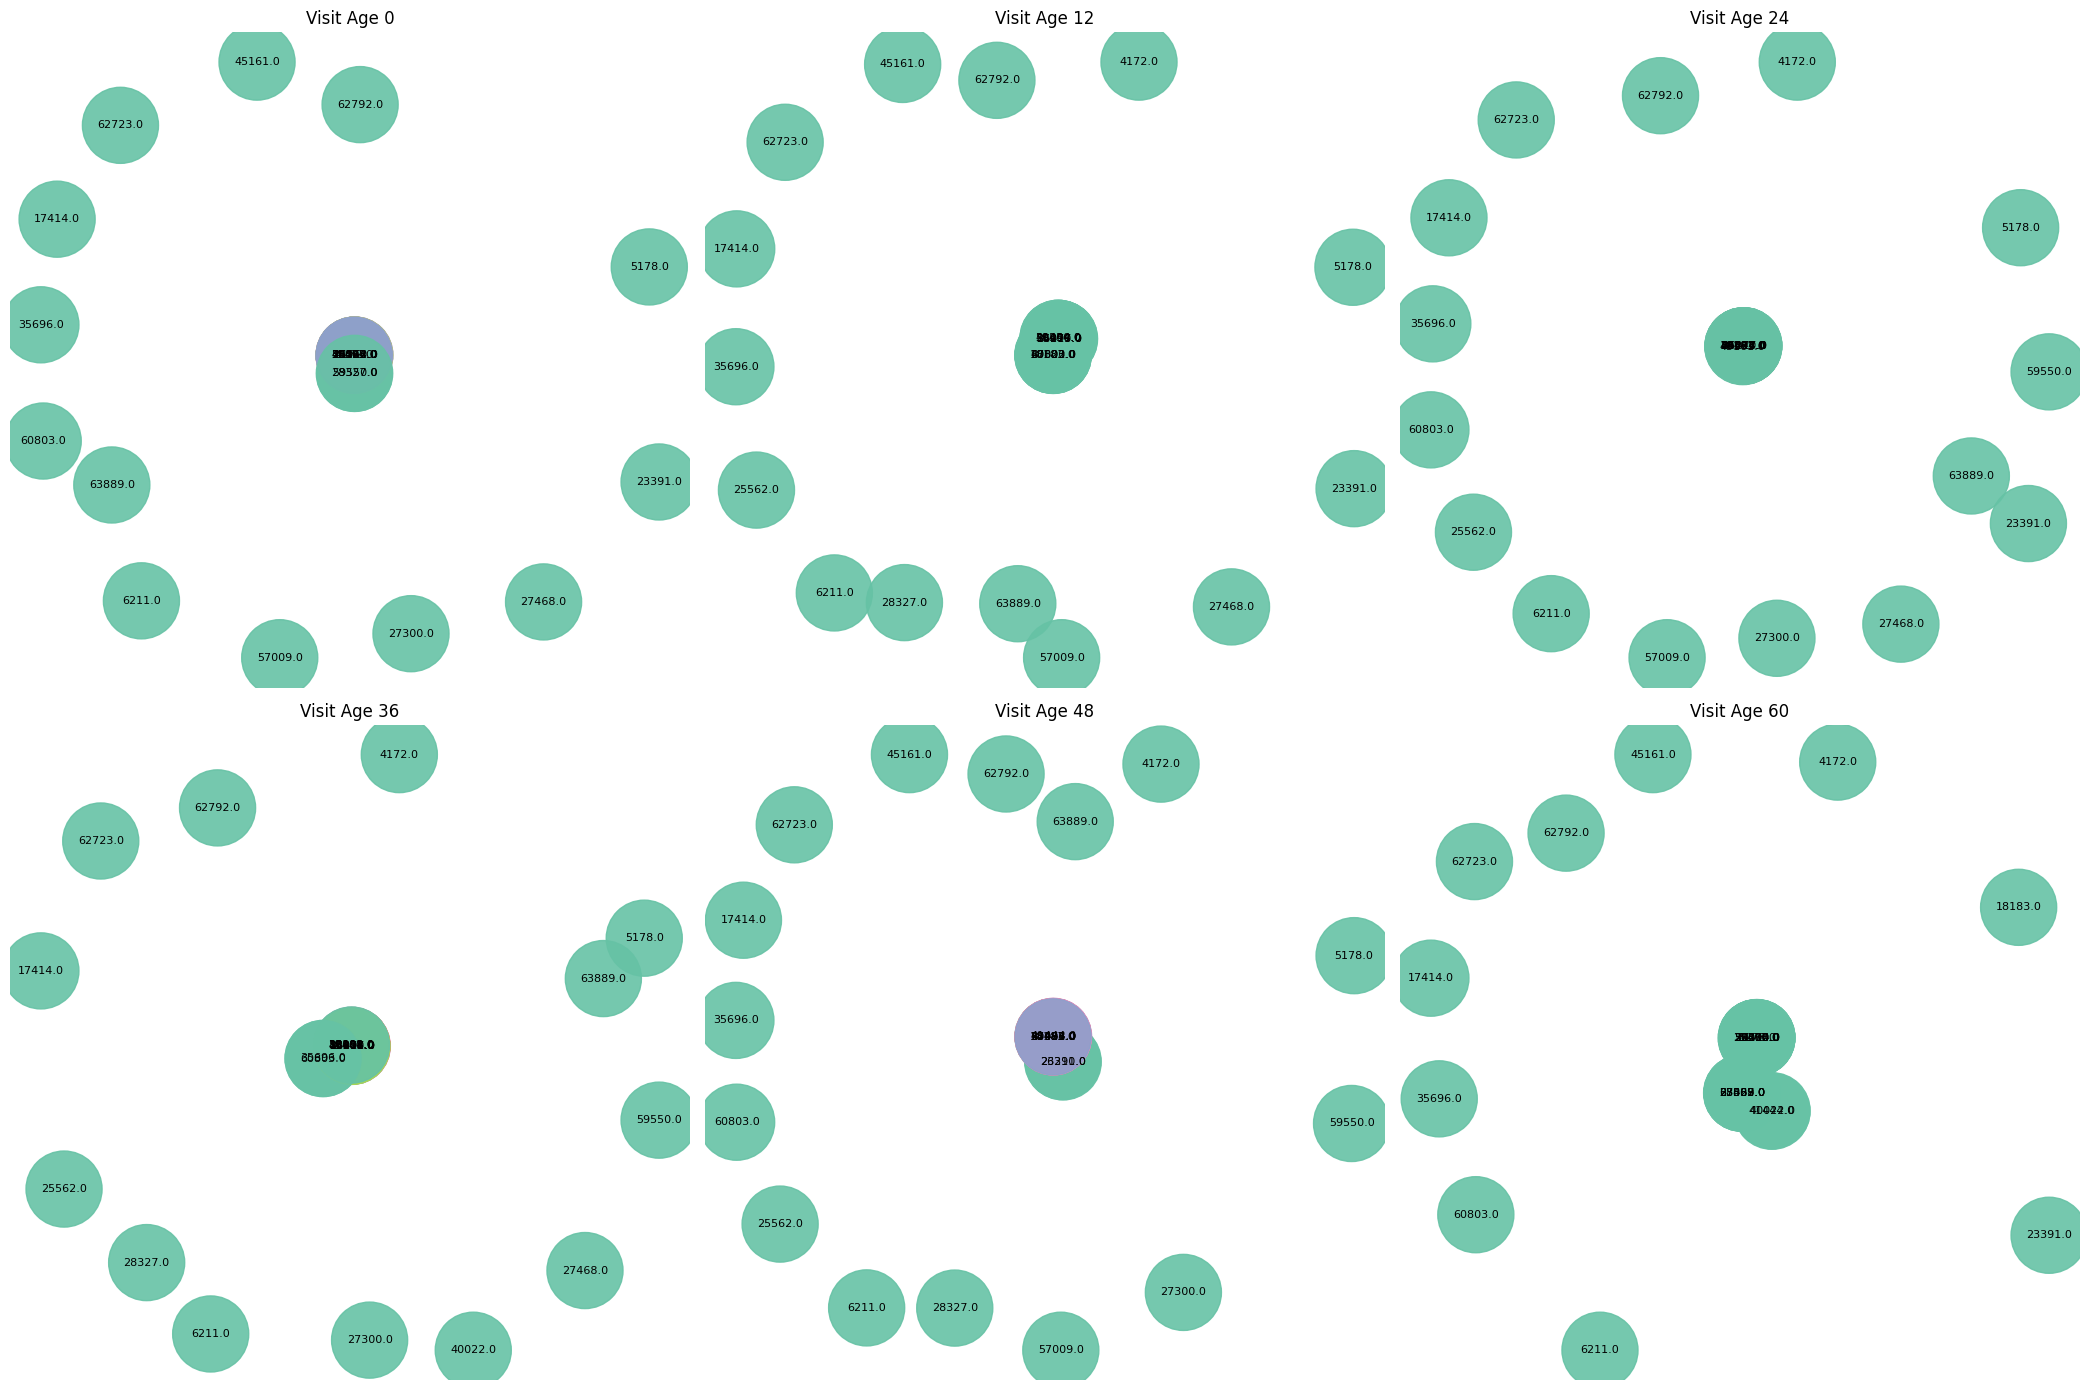

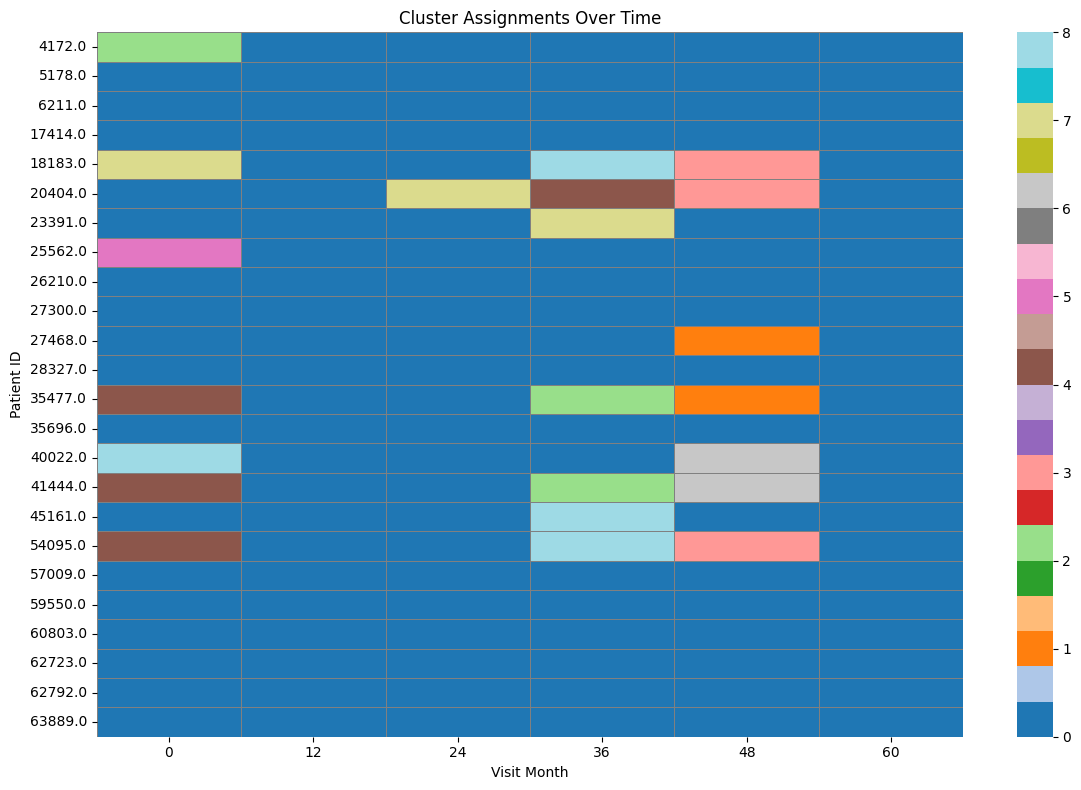

In [ ]:
#pre-req to run the first import file cell and the similarity threshold and consine similarity definision function.
'GAE + GCN = SPATIAL CLUSTERING, considering the graph structure(edge index)'
# Install dependencies (if needed)
#!pip install torch_geometric
#!pip install tensorboard

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, GAE
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
threshold=average_distance_threshold
# This ensures fixed weight initialization for the neural network
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(92)
def cosine_perm_test(vec1, vec2):
    from sklearn.metrics.pairwise import cosine_similarity
    observed = cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]
    return observed#, p_value

#threshold= average_similar_ptairs
# Build graphs
graphs=[]
selected_ages = sorted(df_selected['visit_month'].unique())

# Iterate through selected ages and create graphs
for plot_index, age in enumerate(selected_ages): # Change i to plot_index
    year_data = df_selected[df_selected['visit_month'] == age]
    G = nx.Graph()
    added_edges = set()
    edge_thickness = {}

    # Add nodes for this age group
    for _, row in year_data.iterrows():
        # Add original features directly to the node
        features = {feature: row[feature] for feature in feature_columns}
        G.add_node(row['patient_id'], **features)  # ,age=row['age'], removed

    for i, row1 in year_data.iterrows():
        for j, row2 in year_data.iterrows():
            if i != j and row1['patient_id'] != row2['patient_id']:
                pair = tuple(sorted((row1['patient_id'], row2['patient_id'])))
                if pair not in added_edges:
                    similarity= euclidean_perm_test(row1[feature_columns].values.astype(float), row2[feature_columns].values.astype(float))
                    if abs(similarity) <= threshold:
                        G.add_edge(row1['patient_id'], row2['patient_id'],weight=similarity)
                        added_edges.add(pair)

    # ----> Append the graph to the list <----
    graphs.append(G)

# ========== 1. Prepare Data ==========

all_data = []

for graph in graphs:
    node_features = np.array([
        [graph.nodes[node][feature] for feature in feature_columns]
        for node in graph.nodes
    ])
    node_to_index = {node: i for i, node in enumerate(graph.nodes)}
     # === 🧪 Standardize node features HERE ===
    scaler = RobustScaler()
    node_features = scaler.fit_transform(node_features)
    # Check if the graph has edges before creating edge_index
    if graph.edges():  # If graph has edges
        edge_index = np.array([(node_to_index[u], node_to_index[v])
                               for u, v in graph.edges]).T
    else:  # If graph has no edges
        edge_index = np.empty((2, 0), dtype=int)  # Create an empty edge_index

    data = Data(x=torch.tensor(node_features, dtype=torch.float),
                edge_index=torch.tensor(edge_index, dtype=torch.long))
    all_data.append(data)

# ========== 2. Define GCN Encoder ==========

class GCNEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, output_dim)
        #self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return x# self.conv2(x, edge_index)


'''
# ========== 3. TensorBoard Setup ==========
log_dir = f"runs/gae_gcn_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
writer = SummaryWriter(log_dir)
'''
# ========== 4. Training ==========

# ========== 4. Training ==========
def train(data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    loss = model.recon_loss(z, data.edge_index)
    loss.backward()
    optimizer.step()
    return loss.item()

'''
loss_best=1000
Numbers=[4,8,16,32,64,128]
for i in Numbers:
'''
# Initialize model and optimizer
encoder = GCNEncoder(input_dim=all_data[0].num_node_features, output_dim=2)#32 vs 32 was good , current is the  symetric #hidden_dim=64,
model = GAE(encoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # ========== 3. TensorBoard Setup ==========
'''
    log_dir = f"runs/gae_gcn_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    writer = SummaryWriter(log_dir)
    # Combine graphs into batch
'''
dd = Batch.from_data_list(all_data)
'''
    # Add model graph
    #writer.add_graph(model, (dd.x, dd.edge_index))
    print(i,j)
'''
    # Training loop
losses=[]
for epoch in range(1, 300):
    loss = train(dd)
    losses.append(loss)  # track loss

    # Log to TensorBoard
    #writer.add_scalar("Loss/train", loss, epoch)
    #For tracking how your model's parameters change over time.

    if epoch % 20 == 0:
        z = model.encode(dd.x, dd.edge_index).detach().cpu()
        #writer.add_embedding(z, global_step=epoch, tag=f"Embeddings@epoch{epoch}")
        print(f"Epoch {epoch}, Loss: {loss:.4f}")
'''
        if loss < loss_best:
            loss_best = loss
            kk=i
            print('best_loss and gcn hidden and gcn out are:',loss_best,' ', kk,)
'''
'''#Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 1000), losses, marker='o', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()
'''

#writer.close()
model.eval()
# ========== 5. Post Training Node Embedding Extraction ==========

all_node_representations = []
all_node_representations_o = []


# Normalize features across time ( computes the mean of features across the 4 timepoints, per patient (node))
num_time_steps = len(all_data)
features_over_time = torch.cat([data.x.unsqueeze(0) for data in all_data], dim=0)
mean_features_per_node = features_over_time.mean(dim=0)
'''
Example:
features_over_time =
[   P1       P2      P3      # Patients' nodes
 [[1, 2], [2, 1], [0, 3]],   # time 1
 [[2, 3], [3, 1], [1, 2]],   # time 2
 [[1, 1], [2, 2], [0, 2]],   # time 3
 [[0, 2], [1, 3], [2, 1]],   # time 4
]
'''

for i in range(num_time_steps):
    all_node_representations_o.append(model.encode(all_data[i].x, all_data[i].edge_index).detach().cpu().numpy())  # Store representations for this graph
    '''
    x = all_data[i].x
    x_centered = x - mean_features_per_node
    min_val, max_val = x_centered.min(), x_centered.max()
    x_normalized = (x_centered - min_val) / (max_val - min_val + 1e-8)  # avoid div by 0

    z = model.encode(x_centered, all_data[i].edge_index).detach().cpu().numpy()
    all_node_representations.append(z)
    '''

#before
'''
for i in range(len(all_data)):

  if i==0:#baseline
      x_concat = torch.zeros_like(all_data[i].x)  # Create a zero tensor with the same shape as all_data[i].x
  else:
      x_concat = torch.subtract(all_data[i-1].x, all_data[i].x)#, dim=1) # dim=1, concat tensors along the second axis (as if we increase the number of features)
  z=model.encode(x_concat, all_data[i].edge_index).detach().cpu().numpy()
  all_node_representations.append(z)  # Store representations for this graph
'''


#========== CLUSTERING ==================#

from sklearn.metrics import (
    davies_bouldin_score,
    calinski_harabasz_score,
    silhouette_score
)
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics.pairwise import euclidean_distances
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Prepare node embeddings ---
all_node_representations_np = np.concatenate(
    [node_reps for node_reps in all_node_representations_o],
    axis=0
)

# --- Step 2: Build node metadata for clustering assignment ---
node_info = []
for age, G in zip(selected_ages, graphs):
    for node in G.nodes():
        node_info.append({'patient_id': node, 'visit_month': age})

# --- Step 3: Perform Hierarchical Clustering ---

scaler= StandardScaler()
all_node_representations_np = scaler.fit_transform(all_node_representations_np)
#
Best_k = -1
Best_silhouette = -1
Best_dbi = float('inf')
Best_chi = -1

from sklearn.cluster import KMeans

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(all_node_representations_np)

    if len(np.unique(labels)) == 1:
        continue

    sil = silhouette_score(all_node_representations_np, labels)
    dbi = davies_bouldin_score(all_node_representations_np, labels)
    chi = calinski_harabasz_score(all_node_representations_np, labels)
    print(f"K = {k}: Silhouette={sil:.4f}, DBI={dbi:.4f}, CHI={chi:.4f}")

    if sil > Best_silhouette:
        Best_silhouette = sil
        Best_k = k
        Best_dbi = dbi
        Best_chi = chi
        Best_labels = labels  # Save the best clustering labels


print(f"\nSelected Best K = {Best_k}, Silhouette = {Best_silhouette:.4f}, DBI = {Best_dbi:.4f}, CHI = {Best_chi:.4f}")

# --- Step 4: Assign state labels ---
# Check if Best_k is valid before proceeding
if Best_labels is not None:
    cluster_labels = Best_labels

    # --- Step 5: Assign cluster labels back to graphs safely using a dictionary ---
    # Build a dictionary to map each visit_month to its corresponding graph
    age_to_graph = {age: G for age, G in zip(selected_ages, graphs)}

    # Assign cluster labels (states) to nodes
    for info, cluster_id in zip(node_info, cluster_labels):
        age = info['visit_month']
        pid = info['patient_id']

        G = age_to_graph.get(age)
        if G is not None and pid in G.nodes():
            G.nodes[pid]['state'] = cluster_id
        else:
            print(f"Warning: patient_id {pid} or age {age} not found.")


    # --- Step 5: Plot each graph with colored nodes by state ---
    num_plots = len(selected_ages)
    num_cols = min(num_plots, 3)
    num_rows = (num_plots + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(7 * num_cols, 7 * num_rows))
    fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.9)

    # Normalize axes indexing
    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    if num_cols == 1:
        axes = np.expand_dims(axes, axis=1)

    for idx, (age, G) in enumerate(zip(sorted(list(selected_ages)), graphs)): # Changed selected_ages_list to sorted(list(selected_ages))
        ax = axes[idx // num_cols, idx % num_cols]

        # Debug: show available cluster labels
        states_seen = sorted(set(nx.get_node_attributes(G, 'state').values()) - {None})
        print(f"Age {age}: states present = {states_seen}")

        pos = nx.spring_layout(G, seed=42, k=0.4)

        # Ensure Best_k is used here for the colormap
        cmap = plt.get_cmap('Set2', Best_k)
        state_to_index = {s: i for i, s in enumerate(states_seen)}

        node_colors = []
        for node in G.nodes():
            st = G.nodes[node].get('state')
            node_colors.append(cmap(state_to_index[st] % Best_k) if st is not None else '#cccccc')

        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000, linewidths=1, ax=ax, alpha=0.9)
        nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', width=1, alpha=0.5)
        nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()}, font_size=8, ax=ax)

        ax.set_title(f"Visit Age {age}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # Create a DataFrame for the heatmap
    heatmap_df = pd.DataFrame(node_info)
    heatmap_df['cluster_label'] = cluster_labels

    # Pivot the data: Rows = patient_id, Columns = visit_month, Values = cluster label
    heatmap_data = heatmap_df.pivot(index='patient_id', columns='visit_month', values='cluster_label')

    # Optional: fill missing values (if some months are missing)
    heatmap_data = heatmap_data.fillna(-1)  # or another placeholder like -1 or 0

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='tab20', annot=False, cbar=True, linewidths=0.5, linecolor='gray')

    plt.title("Cluster Assignments Over Time")
    plt.xlabel("Visit Month")
    plt.ylabel("Patient ID")
    plt.tight_layout()
    plt.show()
else:
    print("Skipping plotting as Best_k is less than 2.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00
Data shape (patients x features): (24, 5808)
Epoch 20/1000, Loss: 34.5388
Epoch 40/1000, Loss: 34.5388
Epoch 60/1000, Loss: 34.5388
Epoch 80/1000, Loss: 34.5388
Epoch 100/1000, Loss: 34.5388
Epoch 120/1000, Loss: 34.5388
Epoch 140/1000, Loss: 34.5388
Epoch 160/1000, Loss: 34.5388
Epoch 180/1000, Loss: 34.5388
Epoch 200/1000, Loss: 34.5388
Epoch 220/1000, Loss: 34.5388
Epoch 240/1000, Loss: 34.5388
Epoch 260/1000, Loss: 34.5388
Epoch 280/1000, Loss: 34.5388
Epoch 300/1000, Loss: 34.5388
Epoch 320/1000, Loss: 34.5388
Epoch 340/1000, Loss: 34.5388
Epoch 360/1000, Loss: 34.5388
Epoch 380/1000, Loss: 34.5388
Epoch 400/1000, Loss: 34.5388
Epoch 420/1000, Loss: 34.5388
Epoch 440/1000, Loss: 34.5388
Epoch 460/1000, Loss: 34.5388
Epoch 480/1000, Loss: 34.5388
Epoch 500/1000, Loss: 34.5388
Epoch 520/1000, Loss: 34.5388
Epoch 540/1000, Loss: 

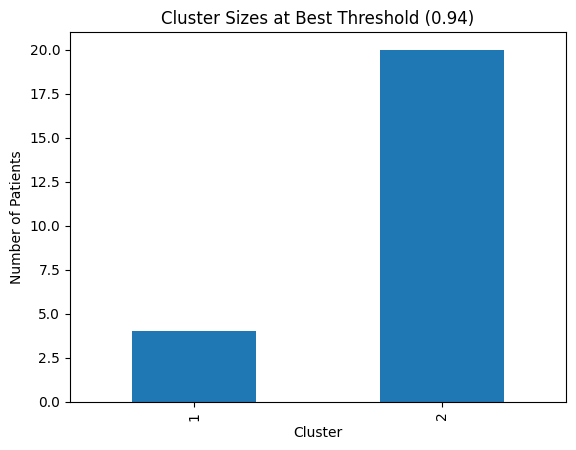

'\nif threshold_results:\n    # Sort by silhouette descending, then loss ascending\n    threshold_results.sort(key=lambda x: (-x[\'silhouette\'], x[\'loss\']))\n    best_result = threshold_results[0]\n\n    best_overall_threshold = best_result[\'threshold\']\n    best_overall_score = best_result[\'silhouette\']\n    best_overall_chi = best_result[\'chi\']\n    best_overall_loss = best_result[\'loss\']\n    best_overall_k = best_result[\'k\']\n    best_overall_labels = best_result[\'labels\']\n    best_overall_embeddings = best_result[\'embeddings\']\n    best_graph = best_result[\'graph\']\n\n    print(f"\n✅ Best threshold: {best_overall_threshold:.4f}")\n    print(f"   Best silhouette: {best_overall_score:.4f}")\n    print(f"   Best CHI: {best_overall_chi:.4f}")\n    print(f"   Final model loss: {best_overall_loss:.4f}")\n    print(f"   Number of clusters: {best_overall_k}")\n\n    dbi = davies_bouldin_score(best_overall_embeddings, best_overall_labels)\n    print(f"   DBI: {dbi:.4f}"

In [ ]:
' GCN - Longitudinal , Representing all patients records in 1 graph'
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
#scaler
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
import torch.nn as nn
!pip install torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GAE
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster

# -----------------------------
# 1. Load & preprocess data
# -----------------------------
df = pd.read_csv("/content/drive/MyDrive/data/train_peptides.csv")
months_to_keep = [0, 12, 24, 36, 48, 60]

patients_with_all_months = df.groupby('patient_id')['visit_month'].apply(lambda x: set(months_to_keep).issubset(set(x)))
patients_with_all_months = patients_with_all_months[patients_with_all_months].index.tolist()
df_filtered = df[df['patient_id'].isin(patients_with_all_months) & df['visit_month'].isin(months_to_keep)]

#------------------------------------------------------
patient_peptides = df_filtered.pivot_table(
    index='patient_id', columns=['Peptide', 'visit_month'], values='PeptideAbundance', fill_value=0
)
patient_peptides.columns = [f"{pep}_month{month}" for pep, month in patient_peptides.columns]
print(f"Data shape (patients x features): {patient_peptides.shape}")


# -----------------------------
# 2. Initialize Parameters
# -----------------------------
thresholds = np.linspace(0.75, 0.99, 10)
input_dim = patient_peptides.shape[1]
output_dim = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

patients = patient_peptides.index.tolist()
features = patient_peptides.values
similarity_matrix = cosine_similarity(features)

# -----------------------------
# 3. Define GCN Model
# -----------------------------
class GCNEncoder(nn.Module):
    def __init__(self, input_dim, output_dim=4):
        super().__init__()
        self.conv1 = GCNConv(input_dim, output_dim)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return x

# -----------------------------
# 4. Loop Over Thresholds
# -----------------------------
threshold=0

'''
threshold_results = []

for threshold in thresholds:
    print(f"\nTrying threshold: {threshold:.4f}")
'''
# Build graph
G = nx.Graph()
for i, pid in enumerate(patients):
    G.add_node(pid, feature=features[i])
for i in range(len(patients)):
    for j in range(i + 1, len(patients)):
        sim = similarity_matrix[i, j]
        if sim >= threshold:
            G.add_edge(patients[i], patients[j], weight=sim)
'''
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
if G.number_of_edges() == 0:
    print("No edges for this threshold, skipping.")
    continue
'''
node_features = np.array([G.nodes[pid]['feature'] for pid in G.nodes])
node_to_idx = {pid: idx for idx, pid in enumerate(G.nodes)}
edge_index = np.array([[node_to_idx[u], node_to_idx[v]] for u, v in G.edges]).T
edge_attr = np.array([G.edges[u, v]['weight'] for u, v in G.edges])

data = Data(
    x=torch.tensor(node_features, dtype=torch.float).to(device),
    edge_index=torch.tensor(edge_index, dtype=torch.long).to(device),
    edge_attr=torch.tensor(edge_attr, dtype=torch.float).to(device)
)

encoder = GCNEncoder(input_dim, output_dim).to(device)
model = GAE(encoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    loss = model.recon_loss(z, data.edge_index)
    loss.backward()
    optimizer.step()
    return loss.item()

num_epochs = 1000
final_loss = None
for epoch in range(1, num_epochs + 1):
    final_loss = train()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {final_loss:.4f}")

# Embedding extraction
model.eval()
with torch.no_grad():
    embeddings = model.encode(data.x, data.edge_index).cpu().numpy()

# Clustering & scores
best_k = 2
best_silhouette = -1
best_silhouette_labels = None
best_chi = -1
best_chi_labels = None

for k in range(2, 15):
    Z = linkage(embeddings, method='ward')
    labels = fcluster(Z, k, criterion='maxclust')
    if len(np.unique(labels)) < 2:
        continue

    sil_score = silhouette_score(embeddings, labels)
    chi_score = calinski_harabasz_score(embeddings, labels)

    if sil_score > best_silhouette:
        best_silhouette = sil_score
        best_silhouette_labels = labels

    if chi_score > best_chi:
        best_chi = chi_score
        best_chi_labels = labels

if best_k is None:
    # Assign best_k from best silhouette labels if exists
    if best_silhouette_labels is not None:
        best_k = len(np.unique(best_silhouette_labels))

labels = fcluster(Z, best_k, criterion='maxclust')

# ✅ Check the number of clusters
if len(np.unique(labels)) < 2:
    print(f"❌ Only 1 cluster formed at k={best_k}, skipping metrics.")
else:
    sil_score = silhouette_score(embeddings, labels)
    chi_score = calinski_harabasz_score(embeddings, labels)
    DBI_score = davies_bouldin_score(embeddings, labels)
print(f"Best clustering for threshold {threshold:.4f}: k={best_k}, silhouette={sil_score:.4f}, CHI={chi_score:.4f}, DBI={DBI_score:.4f}, loss={final_loss:.4f}")


best_overall_threshold = 0.9367
best_overall_score = sil_score
best_overall_chi = chi_score
best_overall_k = best_k
best_overall_labels = labels
best_overall_embeddings = embeddings
best_graph = G
patient_clusters = pd.DataFrame({'patient_id': list(best_graph.nodes), 'cluster': best_overall_labels})
patient_clusters['cluster'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Patients')
plt.title(f'Cluster Sizes at Best Threshold ({best_overall_threshold:.2f})')
plt.show()

'''
    if best_silhouette_labels is not None:
        print(f"Best clustering for threshold {threshold:.4f}: k={best_k}, silhouette={best_silhouette:.4f}, CHI={best_chi:.4f}, loss={final_loss:.4f}")
        threshold_results.append({
            'threshold': threshold,
            'silhouette': best_silhouette,
            'chi': best_chi,
            'loss': final_loss,
            'k': best_k,
            'labels': best_silhouette_labels,
            'embeddings': embeddings,
            'graph': G
        })
    else:
        print(f"No valid clustering for threshold {threshold:.4f}")
'''
# -----------------------------
# 5. Select best threshold based on silhouette and loss
# -----------------------------
'''
if threshold_results:
    # Sort by silhouette descending, then loss ascending
    threshold_results.sort(key=lambda x: (-x['silhouette'], x['loss']))
    best_result = threshold_results[0]

    best_overall_threshold = best_result['threshold']
    best_overall_score = best_result['silhouette']
    best_overall_chi = best_result['chi']
    best_overall_loss = best_result['loss']
    best_overall_k = best_result['k']
    best_overall_labels = best_result['labels']
    best_overall_embeddings = best_result['embeddings']
    best_graph = best_result['graph']

    print(f"\n✅ Best threshold: {best_overall_threshold:.4f}")
    print(f"   Best silhouette: {best_overall_score:.4f}")
    print(f"   Best CHI: {best_overall_chi:.4f}")
    print(f"   Final model loss: {best_overall_loss:.4f}")
    print(f"   Number of clusters: {best_overall_k}")

    dbi = davies_bouldin_score(best_overall_embeddings, best_overall_labels)
    print(f"   DBI: {dbi:.4f}")

    patient_clusters = pd.DataFrame({'patient_id': list(best_graph.nodes), 'cluster': best_overall_labels})
    patient_clusters['cluster'].value_counts().sort_index().plot(kind='bar')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Patients')
    plt.title(f'Cluster Sizes at Best Threshold ({best_overall_threshold:.2f})')
    plt.show()
else:
    print("❌ No valid clustering found.")
'''

/tmp/ipython-input-174575078.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  heatmap_colors = heatmap_pivot.applymap(lambda x: x + 1)


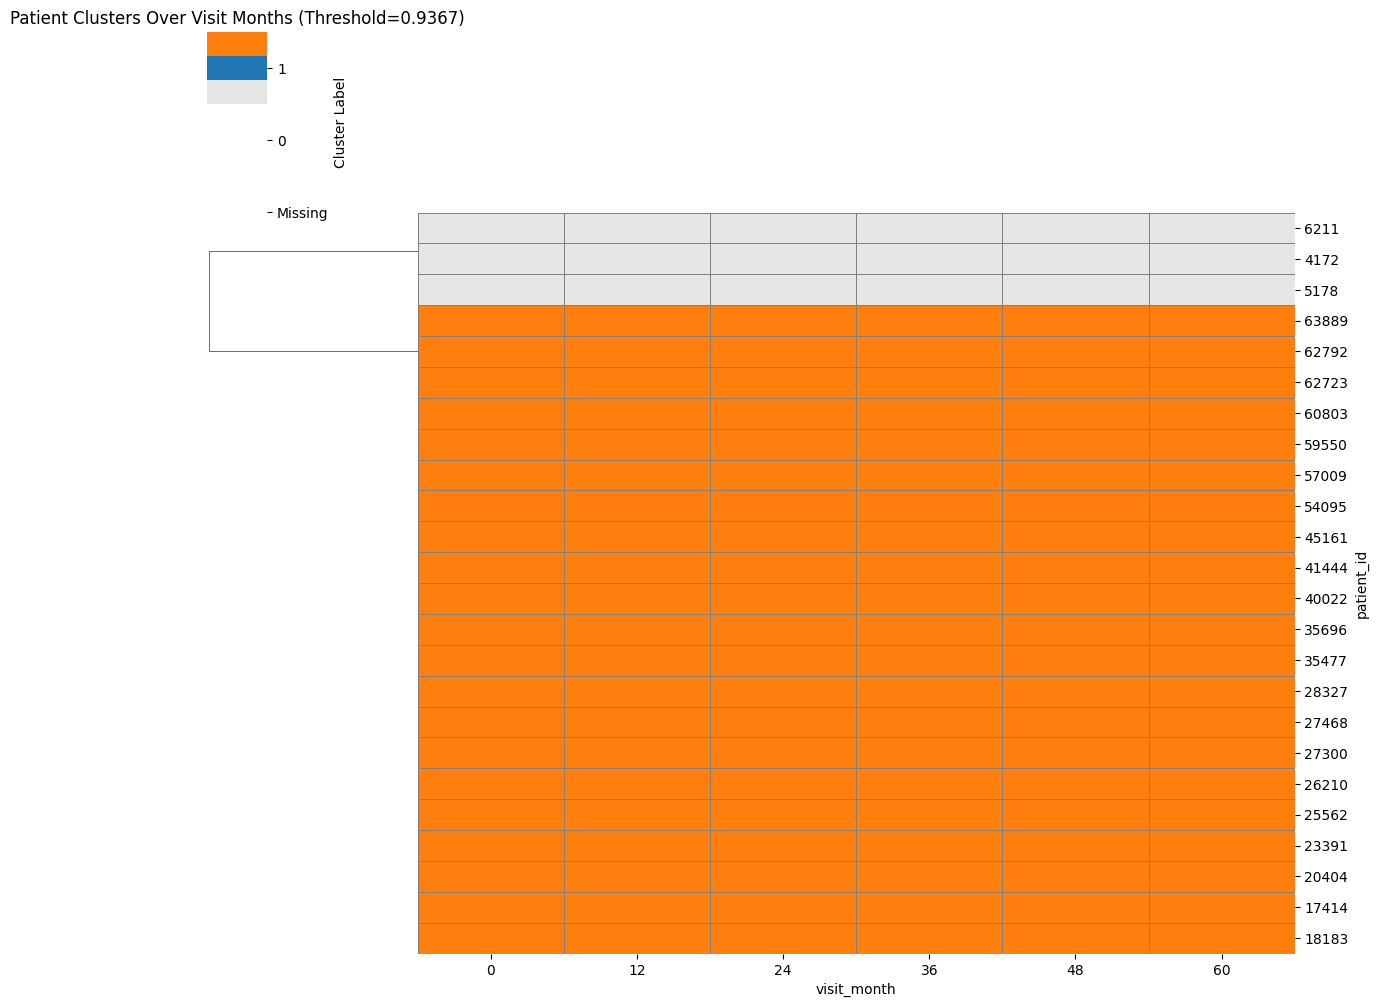

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrame with rows=patient_id, columns=visit_month, values=cluster label
# The cluster label is the same across months per patient, so we just fill it in
heatmap_df = df_filtered[['patient_id', 'visit_month']].drop_duplicates()

# Merge cluster labels
heatmap_df = heatmap_df.merge(patient_clusters, on='patient_id', how='left')

# Pivot so rows=patient_id, columns=visit_month, values=cluster label
heatmap_pivot = heatmap_df.pivot(index='patient_id', columns='visit_month', values='cluster')

# Fill missing values with -1 (or any sentinel) for patients/months missing (should be none if filtered)
heatmap_pivot = heatmap_pivot.fillna(-1).astype(int)

# Prepare color palette: one color per cluster + one for missing (-1)
num_clusters = patient_clusters['cluster'].nunique()
palette = sns.color_palette("tab10", num_clusters)
# Add a gray color for missing cluster (-1)
palette = [(0.9, 0.9, 0.9)] + palette

import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap(palette)

# Map clusters +1 for color indexing because -1 should be 0 index in palette
heatmap_colors = heatmap_pivot.applymap(lambda x: x + 1)

# Plot heatmap with row clustering
g = sns.clustermap(
    heatmap_colors,
    cmap=cmap,
    row_cluster=True,
    col_cluster=False,
    figsize=(12, 10),
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Cluster Label'},
    yticklabels=True,
    xticklabels=True
)

# Adjust colorbar ticks to show cluster labels including missing
colorbar = g.ax_heatmap.collections[0].colorbar
colorbar.set_ticks(np.arange(0.5, num_clusters + 1.5))
colorbar.set_ticklabels(['Missing'] + [str(i) for i in range(num_clusters)])

plt.title(f"Patient Clusters Over Visit Months (Threshold={best_overall_threshold:.4f})")
plt.show()


In [ ]:
import pandas as pd

# Import datasets
df = pd.read_csv("/content/drive/MyDrive/data/train_peptides.csv")
med = pd.read_csv("/content/drive/MyDrive/data/train_clinical_data.csv")

# List of months to check
months_to_check = [0, 12, 24, 36, 48, 60]

# Group by patient_id and check if all months_to_check are present for each patient
patients_with_all_months = df.groupby('patient_id')['visit_month'].apply(lambda x: set(months_to_check).issubset(set(x)))

# Filter patients who have records in all months_to_check
patients_with_all_months = patients_with_all_months[patients_with_all_months].index.tolist()

# Filter the dataframe to only include patients with all the required months
df = df[df['patient_id'].isin(patients_with_all_months)]

# Group by patient_id and collect unique visit_months for each patient
months_with_records = df.groupby('patient_id')['visit_month'].apply(lambda x: set(x))

# Identify missing months for each patient (optional validation)
missing_months = {patient_id: sorted(set(months_to_check) - months_with_records.get(patient_id, set()))
                  for patient_id in patients_with_all_months}

# Time points to be removed
time_points_to_remove = [3, 6,18, 30, 54, 72, 84, 96, 108]

# Remove rows with the specified time points
filtered_df = df[~df['visit_month'].isin(time_points_to_remove)]
'''
# Filter out patients based on medication status (example from med dataset)
patients_to_remove = med[(med['upd23b_clinical_state_on_medication'] == 'On') |
                         (med['upd23b_clinical_state_on_medication'] == 'Off')]['patient_id'].tolist()

# Remove these patients from the dataframe
filtered_df = filtered_df[~filtered_df['patient_id'].isin(patients_to_remove)]
'''
'''
# Group by patient and visit_month, and create a list of (peptide_name, peptide_abundance) pairs
patient_month_data = df.groupby(['patient_id', 'visit_month']).apply(
    lambda x: list(zip(x['Peptide'], x['PeptideAbundance']))
).reset_index(name='peptide_data')
'''
# Pivot the dataframe to get peptide abundances for each visit_month and patient_id
df_selected = filtered_df.pivot_table(
    index=['patient_id', 'visit_month'], columns='Peptide', values='PeptideAbundance'
).reset_index().fillna(0)
'''
# Flatten MultiIndex columns
df_selected.columns = df_selected.columns.to_flat_index()
'''
# Print the pivoted dataframe
print(df_selected['visit_month'].unique())
print(df_selected['patient_id'].unique())

# Optional: statistical analysis and further processing (if needed)
# e.g., testing if the PeptideAbundances follow a normal distribution (omitted for brevity)
print(df_selected)

[ 0 12 24 36 48 60]
[ 4172  5178  6211 17414 18183 20404 23391 25562 26210 27300 27468 28327
 35477 35696 40022 41444 45161 54095 57009 59550 60803 62723 62792 63889]
Peptide  patient_id  visit_month  AADDTWEPFASGK  \
0              4172            0     10687500.0   
1              4172           12     13457500.0   
2              4172           24     10770800.0   
3              4172           36      8285590.0   
4              4172           48      7605160.0   
..              ...          ...            ...   
139           63889           12     11685200.0   
140           63889           24      1297330.0   
141           63889           36     12315800.0   
142           63889           48      1019910.0   
143           63889           60     10715200.0   

Peptide  AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K  \
0                                                 45885.7   
1                                                 59488.3   
2                                    

In [ ]:
'outliers'

import numpy as np
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
import numpy as np
import pandas as pd

# Step 1: Define feature columns
feature_columns = df_selected.columns.difference(['patient_id', 'visit_month'])

# Step 2: Standardize features (Euclidean works best when features are on the same scale)
'''
#scaler = StandardScaler()
scaler=RobustScaler()
df_selected[feature_columns] = scaler.fit_transform(df_selected[feature_columns])
# Step 3: Calculate the 5th percentile distance per age, then average these thresholds
thresholds_per_age = []
selected_ages = sorted(df_selected['visit_month'].unique())

# Step 1: Detect outliers in any feature
outlier_mask = (df_selected[feature_columns] > 3) | (df_selected[feature_columns] < -3)

# Step 2: Get rows that have any outlier
rows_with_outliers = outlier_mask.any(axis=1)

# Step 3: Filter them out
df_selected = df_selected[~rows_with_outliers].reset_index(drop=True)

'''


"\n#scaler = StandardScaler()\nscaler=RobustScaler()\ndf_selected[feature_columns] = scaler.fit_transform(df_selected[feature_columns])\n# Step 3: Calculate the 5th percentile distance per age, then average these thresholds\nthresholds_per_age = []\nselected_ages = sorted(df_selected['visit_month'].unique())\n\n# Step 1: Detect outliers in any feature\noutlier_mask = (df_selected[feature_columns] > 3) | (df_selected[feature_columns] < -3)\n\n# Step 2: Get rows that have any outlier\nrows_with_outliers = outlier_mask.any(axis=1)\n\n# Step 3: Filter them out\ndf_selected = df_selected[~rows_with_outliers].reset_index(drop=True)\n\n"

In [ ]:
'threshold calcs'

#1) Euclidean distance
selected_ages = sorted(df_selected['visit_month'].unique())

thresholds_per_age=[]
for age in selected_ages:
    year_data = df_selected[df_selected['visit_month'] == age].reset_index(drop=True)
    num_patients = len(year_data)

    if num_patients < 2:
        continue  # skip ages with less than 2 patients

    distances = []
    for i in range(num_patients):
        for j in range(i + 1, num_patients):
            patient_i = year_data.loc[i, feature_columns].values.reshape(1, -1)
            patient_j = year_data.loc[j, feature_columns].values.reshape(1, -1)
            dist = euclidean_distances(patient_i, patient_j)[0][0]
            distances.append(dist)

    if distances:
        # Get 5th percentile (i.e., most similar pairs with low distance)
        threshold_5 = np.percentile(distances, 5)
        thresholds_per_age.append(threshold_5)

# Calculate mean of 5th percentile distances across all ages
average_distance_threshold = np.mean(thresholds_per_age)
print(f"Global Euclidean distance threshold (mean of 5th percentiles): {average_distance_threshold:.4f}")
'''
#2) cosine similarity

# Step 3: Calculate the 90th percentile similarity per age, then average these thresholds
thresholds_per_age = []
selected_ages = sorted(df_selected['visit_month'].unique())

for age in selected_ages:
    year_data = df_selected[df_selected['visit_month'] == age].reset_index(drop=True)
    num_patients = len(year_data)

    if num_patients < 2:
        continue  # skip ages with less than 2 patients

    similarities = []
    for i in range(num_patients):
        for j in range(i + 1, num_patients):
            patient_i = year_data.loc[i, feature_columns].values.reshape(1, -1)
            patient_j = year_data.loc[j, feature_columns].values.reshape(1, -1)
            sim = cosine_similarity(patient_i, patient_j)[0][0]
            similarities.append(sim)

    if similarities:
        # Get 90th percentile for this age
        threshold_90 = np.percentile(similarities, 95)
        thresholds_per_age.append(threshold_90)

# Calculate mean of 90th percentile thresholds across all ages
average_distance_threshold = np.mean(thresholds_per_age)
print(f"Global similarity threshold (mean of 90th percentiles): {average_distance_threshold:.4f}")
'''

Global Euclidean distance threshold (mean of 5th percentiles): 15763284.4015


'\n#2) cosine similarity\n\n# Step 3: Calculate the 90th percentile similarity per age, then average these thresholds\nthresholds_per_age = []\nselected_ages = sorted(df_selected[\'visit_month\'].unique())\n\nfor age in selected_ages:\n    year_data = df_selected[df_selected[\'visit_month\'] == age].reset_index(drop=True)\n    num_patients = len(year_data)\n\n    if num_patients < 2:\n        continue  # skip ages with less than 2 patients\n\n    similarities = []\n    for i in range(num_patients):\n        for j in range(i + 1, num_patients):\n            patient_i = year_data.loc[i, feature_columns].values.reshape(1, -1)\n            patient_j = year_data.loc[j, feature_columns].values.reshape(1, -1)\n            sim = cosine_similarity(patient_i, patient_j)[0][0]\n            similarities.append(sim)\n\n    if similarities:\n        # Get 90th percentile for this age\n        threshold_90 = np.percentile(similarities, 95)\n        thresholds_per_age.append(threshold_90)\n\n# Calcula

In [ ]:
print("Minimum values per column:\n", df_selected[feature_columns].min())
print("\nMaximum values per column:\n", df_selected[feature_columns].max())


Minimum values per column:
 Peptide
AADDTWEPFASGK                                            0.0
AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K         0.0
AAFTEC(UniMod_4)C(UniMod_4)QAADK                    389920.0
AANEVSSADVK                                              0.0
AATGEC(UniMod_4)TATVGKR                                  0.0
                                                      ...   
YVNKEIQNAVNGVK                                           0.0
YWGVASFLQK                                               0.0
YYC(UniMod_4)FQGNQFLR                                    0.0
YYTYLIMNK                                                0.0
YYWGGQYTWDMAK                                            0.0
Length: 968, dtype: float64

Maximum values per column:
 Peptide
AADDTWEPFASGK                                       16476100.0
AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K       99913.8
AAFTEC(UniMod_4)C(UniMod_4)QAADK                    14931100.0
AANEVSSADVK                            

Epoch 0, Avg Loss: 16.9397
Epoch 20, Avg Loss: 4.0056
Epoch 40, Avg Loss: 3.9944
Epoch 60, Avg Loss: 3.9934
Epoch 80, Avg Loss: 3.9933
Epoch 100, Avg Loss: 3.9928
Epoch 120, Avg Loss: 3.9928
Epoch 140, Avg Loss: 3.9927
Epoch 160, Avg Loss: 3.9926
Epoch 180, Avg Loss: 3.9926
Epoch 200, Avg Loss: 3.9926
Epoch 220, Avg Loss: 3.9925
Epoch 240, Avg Loss: 3.9925


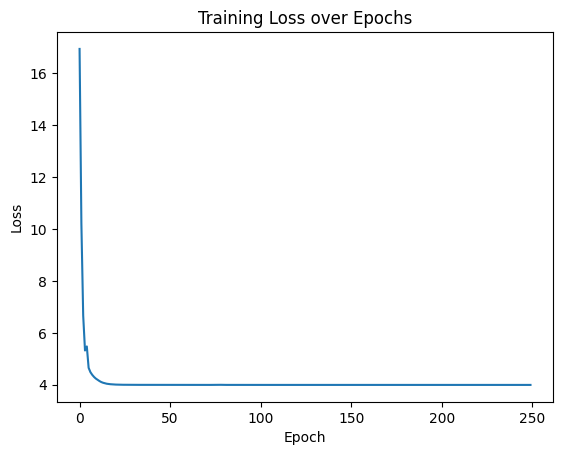

(6, 24, 4)
Best K: 4
Best silhouette score: 0.8414
Best K: 4
Silhouette Score: 0.8414
Davies-Bouldin Index: 0.1708
Calinski-Harabasz Index: 451.3941


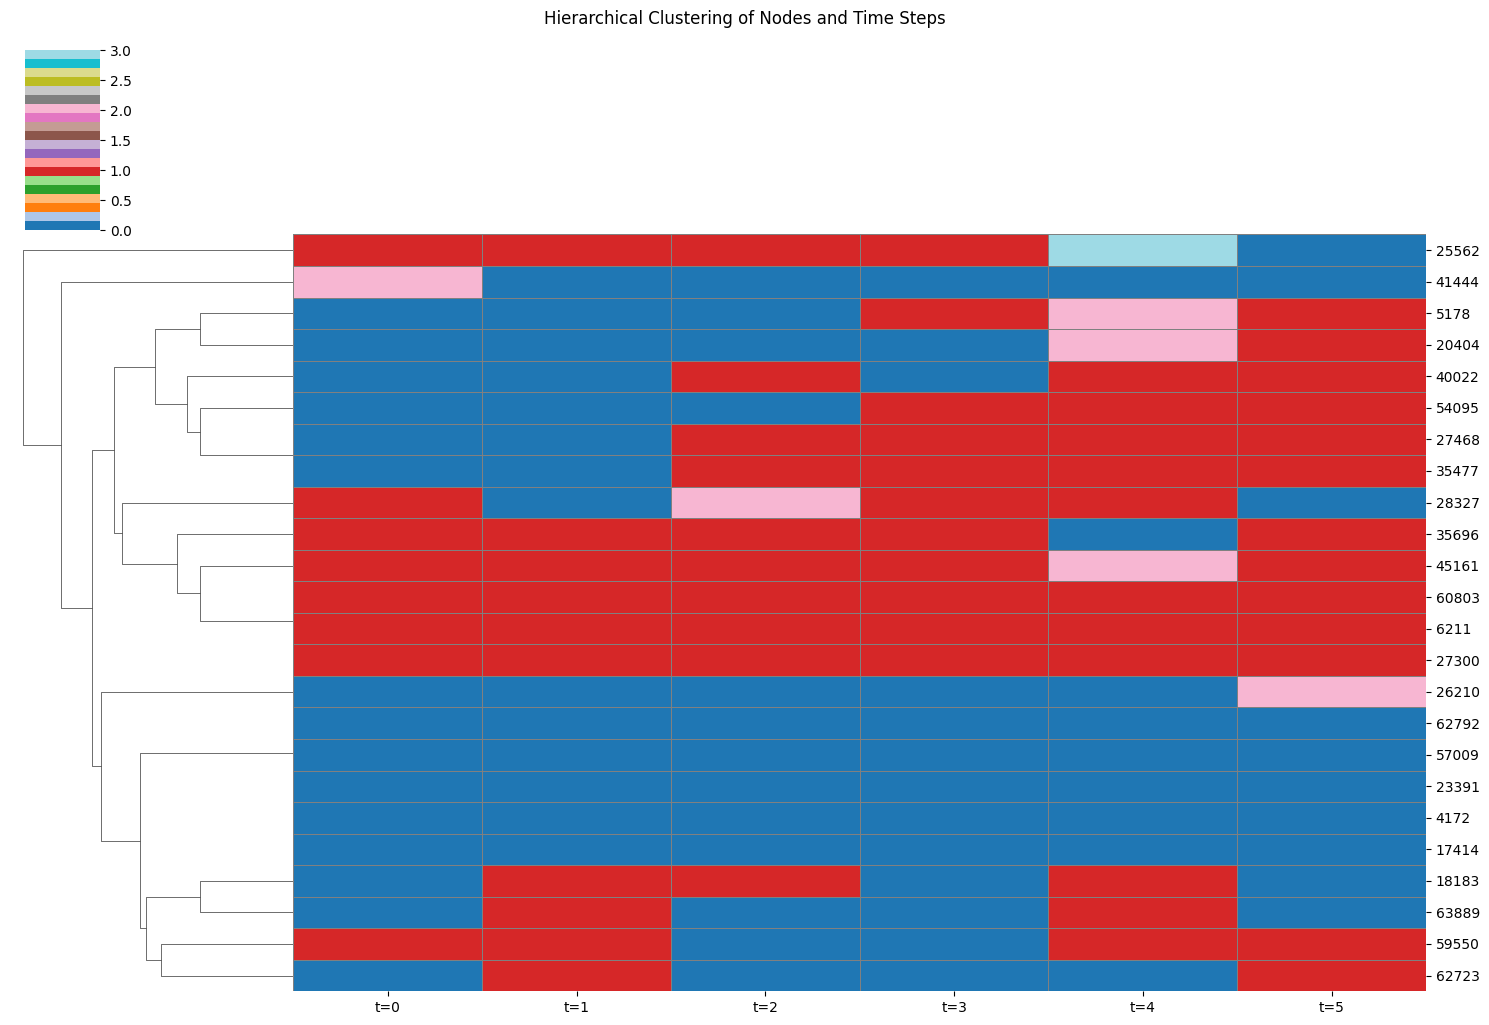

In [ ]:
'MultiModel (1/2) - Model Training'
#!pip install torch_geometric
#pip install tensorboard
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
# import Davias Bouldin scor
from sklearn.metrics import davies_bouldin_score
# import Calinski Harabasz scor
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics.pairwise import euclidean_distances

#=============== fix random weight initialization ===========#

import random
# This ensures fixed weight initialization for the neural network
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


#=============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#==============================================================xx
#removed the permutations
def cosine_perm_test(vec1, vec2):
    from sklearn.metrics.pairwise import cosine_similarity
    observed = cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]
    return observed#, p_value
def euclidean_perm_test(vec1, vec2):
    vec1 = torch.tensor(vec1, device='cpu', dtype=torch.float32)
    vec2 = torch.tensor(vec2, device='cpu', dtype=torch.float32)
    dist = torch.norm(vec1 - vec2)
    return dist.item()

    #observed = euclidean_distances(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]
    #return observed#, p_value

# ==================== 1. Data Preparation ====================xx
'Features & age range definision'
'''
bb=-1
#print(average_precision_score)
for i in [round(x, 2) for x in np.arange(2, 3.4, 0.2)]: # Fixed the range to use numpy arange for floats
'''
threshold = average_distance_threshold # 31.3482#average_similar_pairs
'''
#1)Cognitive Features ONLY
cognitive = ['indepscl', 'carelevl', 'adl', 'chores', 'finances', 'occupatn', 'mmsetotal', 'sit1', 'verflt05', 'swrt1', 'scnt1', 'verfct5', 'sdmt1']
cog1=['indepscl', 'carelevl', 'adl', 'chores', 'finances', 'occupatn']  ############ N#w Func.
cog2=['mmsetotal', 'sit1', 'verflt05', 'swrt1', 'scnt1', 'verfct5', 'sdmt1']  ############ N#w Cognitive
#The interval between ages you want to include in your analysis or plotting
time_step = 1
# All available ages in your dataset
available_ages = sorted(df_selected['age'].unique().astype(int))
selected_year = min(available_ages)
# Select only those that exist in the data and respect the time_step
selected_ages = [age for age in available_ages if age >= selected_year and (age - selected_year) % time_step == 0]

feature_columns = df_selected.columns.difference(['subjid', 'age', 'cag'])  # Exclude non-feature columns  #^^^^^ To have only motor symptoms
#feature_columns = cog1 # Exclude non-feature columns  #^^^^^ To have only motor symptoms

#scaler = StandardScaler()
#df_selected[feature_columns] = scaler.fit_transform(df_selected[feature_columns])
from cuml.preprocessing import StandardScaler
scaler = StandardScaler()
df_selected[feature_columns] = scaler.fit_transform(df_selected[feature_columns].to_numpy())

'''
# Create GLOBAL node mapping (critical for consistency)
all_nodes = sorted(set(df_selected['patient_id']))
global_node_to_index = {node: i for i, node in enumerate(all_nodes)}
num_nodes = len(all_nodes)

# Build graphs with consistent node ordering
graphs=[]
selected_ages = sorted(df_selected['visit_month'].unique()) # Defined selected_ages here
# Iterate through selected ages and create graphs
for plot_index, age in enumerate(selected_ages): # Change i to plot_index
    year_data = df_selected[df_selected['visit_month'] == age]
    G = nx.Graph()
    added_edges = set()
    edge_thickness = {}

    # Add nodes for this age group
    for _, row in year_data.iterrows():
        # Add original features directly to the node
        features = {feature: row[feature] for feature in feature_columns}
        G.add_node(row['patient_id'], **features)  # ,age=row['age'], removed

    for i, row1 in year_data.iterrows():
        for j, row2 in year_data.iterrows():
            if i != j and row1['patient_id'] != row2['patient_id']:
                pair = tuple(sorted((row1['patient_id'], row2['patient_id'])))
                if pair not in added_edges:
                    similarity= euclidean_perm_test(row1[feature_columns].values.astype(float), row2[feature_columns].values.astype(float))
                    if abs(similarity) <= threshold:
                        G.add_edge(row1['patient_id'], row2['patient_id'],weight=similarity)
                        added_edges.add(pair)

    # ----> Append the graph to the list <----
    graphs.append(G)

# Convert to PyG Data objects with consistent indexing
all_data = []
for graph in graphs:
    # Initialize node features matrix using GLOBAL ordering
    node_features = np.zeros((num_nodes, len(feature_columns)))
    for node in graph.nodes:
        idx = global_node_to_index[node]
        node_features[idx] = [graph.nodes[node][feature] for feature in feature_columns]

    # === 🧪 Standardize node features HERE ===
    scaler = RobustScaler()
    node_features = scaler.fit_transform(node_features)

    # Build edge_index using GLOBAL indices
    edge_index = []
    for u, v in graph.edges():
        edge_index.append([global_node_to_index[u], global_node_to_index[v]])

    # Correctly handle empty edge list and create a 2xN tensor
    if not edge_index: # Check if the list is empty
        # If no edges, create self-loops as a 2xN tensor
        edge_index = torch.arange(num_nodes, dtype=torch.long).repeat(2, 1)
    else:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    all_data.append(Data(x=torch.tensor(node_features, dtype=torch.float),
                        edge_index=edge_index))

# ==================== 2. Model Definition ====================
from torch_geometric.utils import dense_to_sparse

def reconstruction_loss_sparse(embeddings, edge_index_seq, num_nodes):
    """
    Args:
        embeddings: [T, N, D]
        edge_index_seq: list of length T, each with shape [2, E_t]
        num_nodes: int
    """
    loss = 0
    T = embeddings.shape[0]
    for t in range(T):
        emb_t = embeddings[t]              # [N, D]
        pred_adj = torch.sigmoid(emb_t @ emb_t.T)  # [N, N]

        # Only compute loss on the observed edges (sparse loss)
        target = torch.zeros((num_nodes, num_nodes), device=emb_t.device)
        edge_index = edge_index_seq[t]
        target[edge_index[0], edge_index[1]] = 1.0

        loss += F.binary_cross_entropy(pred_adj, target)
    return loss

# Keep the rest of the code the same as in the original cell
class SpatioTemporalEncoder(nn.Module):
    def __init__(self, input_dim, gcn_out, gru_hidden): #gcn_hidden,
        super().__init__()
        self.gcn = GCNConv(input_dim, gcn_out)#GCNEncoder(input_dim, gcn_hidden, gcn_out)
        self.gru = nn.GRU(gcn_out, gru_hidden, batch_first=True)
        self.fusion = nn.Sequential(
            nn.Linear(gcn_out + gru_hidden, gru_hidden),
            nn.ReLU(),
            nn.LayerNorm(gru_hidden)
        )

    def forward(self, x_seq, edge_index_seq):
        # Spatial encoding
        spatial_features = torch.stack([self.gcn(x_seq[t], edge_index_seq[t])
                                      for t in range(x_seq.size(0))])
        '''
        Input:
        x_seq: [T, N, F] → features of N nodes over T time steps.
        edge_index_seq: list of T items, each of shape [2, E_t].

        Output:
        spatial_features: [T, N, D]
        T: time steps
        N: number of nodes
        D: GCN output dimension (gcn_out)
        '''

        # Temporal encoding
        temporal_input = spatial_features.permute(1, 0, 2)
        '''
        GRU (with batch_first=True) expects input of shape: [N, T, D]
        # batch size = number of nodes
        # sequence length = time steps
        # features = GCN features per node per time
        # i.e.:
        # From: [T, N, D]
        # To:   [N, T, D]
        '''
        '''
        _, (h_n, _) = self.lstm(temporal_input)  # h_n: [1, N, lstm_hidden]
        temporal_features = h_n.squeeze(0)
        '''
        #GRU

        _, gru_out = self.gru(temporal_input) # Changed self.lstm to self.gru
        temporal_features = gru_out.squeeze(0)

        '''
        single-layer GRU, gru_out has shape:[1, N, H], and .squeeze removes the first dimention:
        temporal_features: [N, D]
        N: number of nodes
        D: GRU output dimension (gru_hidden)
        '''

        # Combine
        '''
        We have to fuse spatial and temporal features, but their shapes don’t match:
        until here:
        spatial_features: [T, N, gcn_out]
        temporal_features: [N, H]
        temporal_features.unsqueeze(0), add new dimention at index 0.
        # becomes: [1, N, H]
        Then, with .expand() to repeat this new dimention will be filled with T time steps (i.e., the first dimension), so all time steps get the same temporal embedding per node.
        So temporal feature shape becomes [T, N, H]
        '''
        # Expand temporal_features to match spatial_features shape for concatenation
        temporal_features = temporal_features.unsqueeze(0).expand(spatial_features.size(0), -1, -1)
        'concatenates the spatial and temporal representations along the last dimension (dim = -1), i.e., feature dimension.'
        '''
        for example:
          spatial_features = torch.tensor([
            [[1,2], [3,4]],
            [[5,6], [7,8]],
        ])  # shape [2,2,2] last dimention is 2

        temporal_features = torch.tensor([
            [[10,20], [30,40]],
            [[50,60], [70,80]],
        ])  # shape [2,2,2] last dimention is 2
        combined = [
            [[1, 2, 10, 20],
            [3, 4, 30, 40]],

            [[5, 6, 50, 60],
            [7, 8, 70, 80]]
        ]  # shape: [2, 2, 4] last dimention is 4 after combining
        '''
        combined = torch.cat([spatial_features, temporal_features], dim=-1)
        return self.fusion(combined)

#=====================Loss Funciton =====================
import torch.nn.functional as F

'''
adj_seq is a dense adjacency matrices from from edge index built for each graph:

The below  will give you a tensor adj_seq of shape [T, N, N], where:
T is the number of time steps
N is the number of nodes (same across all graphs due to global indexing)
adj_seq[t][i][j] = 1 if there's an edge between node i and node j at time t

'''
'''
from torch_geometric.utils import to_dense_adj
# Create dense adjacency sequence from edge indices
adj_seq = torch.stack([
    to_dense_adj(data.edge_index, max_num_nodes=num_nodes)[0]
    for data in all_data
])
'''

def reconstruction_loss(embeddings, adj_seq):
    """
    Args:
        embeddings: [T, N, D] - spatio-temporal node embeddings
        adj_seq: [T, N, N] - ground-truth adjacency matrices

    Returns:
        Total BCE loss over all time steps
    """
    loss = 0
    T = embeddings.shape[0]
    for t in range(T):
        emb_t = embeddings[t]                        # [N, D]
        pred_adj = torch.sigmoid(emb_t @ emb_t.T)    # [N, N]
        loss += F.binary_cross_entropy(pred_adj, adj_seq[t])
    return loss

# ==================== 4. Training Loop ====================

import matplotlib.pyplot as plt
'''
def train(model, optimizer, x_seq, edge_index_seq, epochs=200):
    model.train()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        embeddings = model(x_seq, edge_index_seq)
        #loss = reconstruction_loss(embeddings, adj_seq)  # meaningful loss
        loss = reconstruction_loss_sparse(embeddings, edge_index_seq, num_nodes)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    return model, losses,loss
'''
def get_batches(x_seq, edge_index_seq, batch_size):
    N = x_seq.shape[1]  # total number of nodes
    for start in range(0, N, batch_size):
        end = min(start + batch_size, N)
        yield x_seq[:, start:end], [edge_index_seq[t][:,
            ((edge_index_seq[t][0] >= start) & (edge_index_seq[t][0] < end) &
              (edge_index_seq[t][1] >= start) & (edge_index_seq[t][1] < end))
        ] - start for t in range(len(edge_index_seq))]

def train(model, optimizer, x_seq, edge_index_seq, batch_size=1, epochs=250):
    model.train()
    losses = []

    for epoch in range(epochs):
        total_loss = 0
        for x_batch, edge_batch in get_batches(x_seq, edge_index_seq, batch_size):
            optimizer.zero_grad()
            embeddings = model(x_batch, edge_batch)
            loss = reconstruction_loss_sparse(embeddings, edge_batch, x_batch.shape[1])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / (x_seq.shape[1] // batch_size + 1)
        losses.append(avg_loss)

        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Avg Loss: {avg_loss:.4f}")

    return model, losses


# ==================== 3. Training Setup ====================

# Prepare sequence data
'''
x_seq = torch.stack([data.x for data in all_data])
edge_index_seq = [data.edge_index for data in all_data]
'''
x_seq = torch.stack([data.x.to(device) for data in all_data])####
edge_index_seq = [data.edge_index.to(device) for data in all_data]####


#Grid search
'''
best_loss=600
for i in [4,8,16,32,64]:
  for j in [4,8,16,32,64]:
      print(i ,j )
      print(i,j)
'''
# Initialize model
model = SpatioTemporalEncoder(
    input_dim=all_data[0].num_node_features,
    #gcn_hidden=16,##i,#ignored, removed a conv. layer.
    gcn_out=8,#32,#j, or 64
    gru_hidden=4#16#4#k
)
model = model.to(device)#########
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model, loss = train(model, optimizer, x_seq, edge_index_seq)

'''
if loos < best_loss:
  best_loss=loos
  best_gcn_out=i
  best_gru_hidden=j
# Plot loss curve
'''
#print('The hyperparameters gcn_hidden_gcn_out, and gru_hidden: ', best_loss, best_gcn_out,best_gru_hidden )
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

'''
print('Best loss acheived is:', best_loss)
print(best_gcn_out)
print(best_gru_hidden)
'''
# ==================== 5. Clustering & Visualization ====================

# Get all embeddings [T, N, D]
model.eval()
with torch.no_grad():
    all_embeddings = model(x_seq, edge_index_seq).cpu().numpy()

# ============================ CLUSTER ALL EMBEDDINGS TOGETHER ============================
print(all_embeddings.shape)
T, N, D = all_embeddings.shape

# 1. Flatten the embeddings across time: shape [T * N, D]
flattened = all_embeddings.reshape(T * N, D)

# 2. Optional: scale features (helps clustering)
scaler = StandardScaler ()
#scaler = RobustScaler()
flattened_scaled = scaler.fit_transform(flattened)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import math

# Assume flattened_scaled already exists from your embedding preprocessing
# flattened_scaled: [T*N, D]

# Determine range of k
max_limit = 20
unique_subj_ids = list(set(all_nodes))  # or set of patient IDs
k_max = min(len(unique_subj_ids), int(math.sqrt(len(unique_subj_ids))), max_limit)
range_n_clusters = list(range(2, k_max + 1))

# Grid search to find best k using silhouette score
best_k = 2
best_score = -1
best_labels = None

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(flattened_scaled)

    if len(np.unique(labels)) > 1:
        score = silhouette_score(flattened_scaled, labels)
        if score > best_score:
            best_k = k
            best_score = score
            best_labels = labels

# Final clustering using best_k
final_kmeans = KMeans(n_clusters=best_k, init='k-means++', n_init=10, random_state=42)
cluster_labels = final_kmeans.fit_predict(flattened_scaled)  # shape: [T*N]

print(f"Best K: {best_k}")
print(f"Best silhouette score: {best_score:.4f}")


# Compute other metrics for the best clustering ONLY if more than one cluster exists
if len(np.unique(cluster_labels)) > 1:
    db_index = davies_bouldin_score(flattened_scaled, cluster_labels)
    ch_index = calinski_harabasz_score(flattened_scaled, cluster_labels)

    print(f"Best K: {best_k}")
    print(f"Silhouette Score: {best_score:.4f}")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"Calinski-Harabasz Index: {ch_index:.4f}")
else:
    print(f"Clustering resulted in only 1 cluster at best k={best_k}. Skipping metrics.")

# 5. Reshape to [T, N] and transpose to [N, T] for heatmap
cluster_matrix = cluster_labels.reshape(T, N).T  # shape: [N, T]
cmap = plt.get_cmap("tab20").copy()  # Use copy to modify safely
cmap.set_bad(color='white')         # NaN values will appear white
# Convert cluster_matrix to DataFrame for labeled clustering

# Create DataFrame with patient IDs instead of node indices
cluster_df = pd.DataFrame(
    cluster_matrix,
    index=all_nodes,  # patient IDs
    columns=[f"t={i}" for i in range(T)]
)
'''
  if best_score > bb:
    bb=best_score
    th=threshold
'''

#print('best silloput score is >>', bb, 'when the threshold is >>',th)

# Clustered heatmap (rows = nodes, cols = time steps)
sns.clustermap(
    cluster_df,
    cmap=cmap,
    linewidths=0.5,
    linecolor='gray',
    row_cluster=True,
    col_cluster=False,
    figsize=(15, 10)
)

plt.suptitle("Hierarchical Clustering of Nodes and Time Steps", y=1.02)
plt.show()

/tmp/ipython-input-751848120.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x='cluster_ml', y='updrs_1', palette='gist_ncar')
/tmp/ipython-input-751848120.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x='cluster_ml', y='updrs_2', palette='gist_ncar')
/tmp/ipython-input-751848120.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x='cluster_ml', y='updrs_3', palette='gist_ncar')


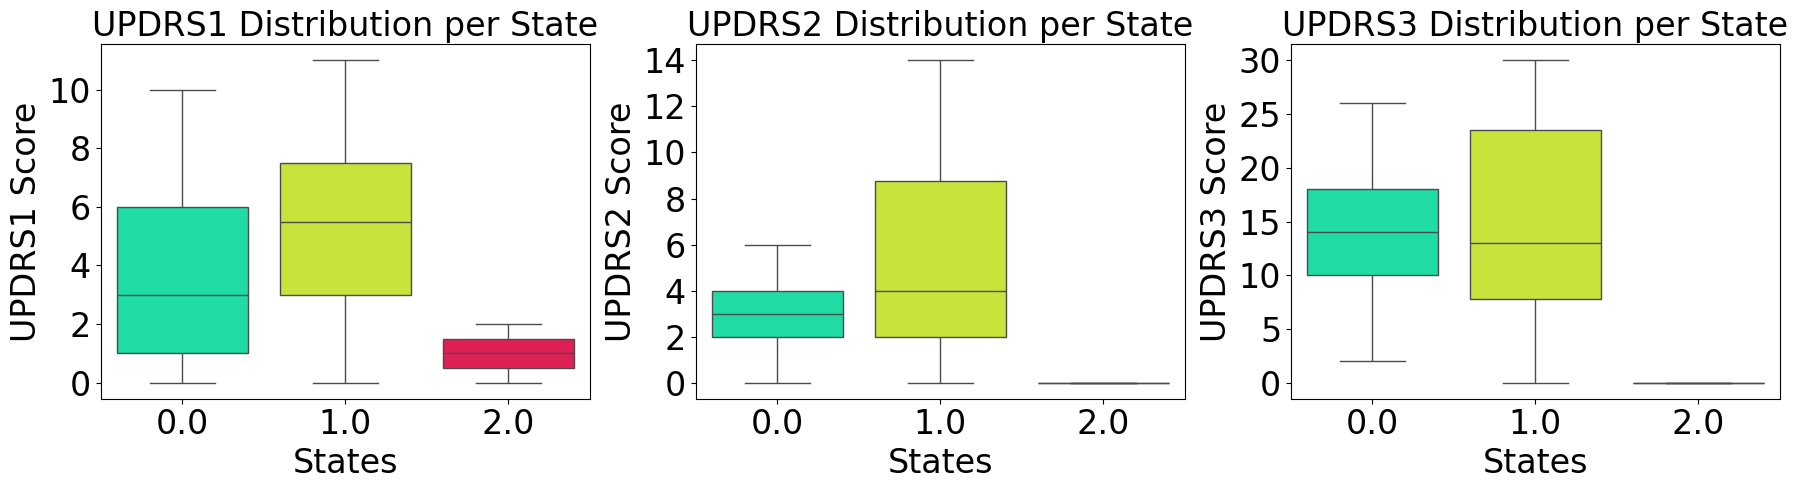

In [ ]:
# Repeat patient IDs for each time step
patient_ids_repeated = np.tile(all_nodes, T)  # Shape: [T * N]

# Repeat visit months for each patient
visit_months_repeated = np.repeat(np.arange(T), N)  # Shape: [T * N]

# Create DataFrame with (patient_id, visit_month, cluster)
cluster_assignments = pd.DataFrame({
    'patient_id': patient_ids_repeated,
    'visit_month': visit_months_repeated,
    'cluster_ml': cluster_labels  # or rename to 'cluster_id' if preferred
})

# Ensure your pivoted_data has 'patient_id' and 'visit_month' columns
pivoted_data = pd.merge(
    df_selected,
    cluster_assignments,
    on=['patient_id', 'visit_month'],
    how='left'  # or 'inner' if you want to keep only matched records
)

# Make sure the cluster info exists in pivoted_data
# Merge UPDRS scores from med_1
merged = pd.merge(pivoted_data[['patient_id', 'visit_month', 'cluster_ml']],
                  med[['patient_id', 'visit_month', 'updrs_1', 'updrs_2', 'updrs_3']],
                  on=['patient_id', 'visit_month'],
                  how='inner')

# Set up the plot aesthetics
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 5))

# UPDRS1
plt.subplot(1, 3, 1)
sns.boxplot(data=merged, x='cluster_ml', y='updrs_1', palette='gist_ncar')
plt.title('UPDRS1 Distribution per State',fontsize=24)
plt.xlabel('States',fontsize=24)
plt.ylabel('UPDRS1 Score',fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# UPDRS2
plt.subplot(1, 3, 2)
sns.boxplot(data=merged, x='cluster_ml', y='updrs_2', palette='gist_ncar')
plt.title('UPDRS2 Distribution per State',fontsize=24)
plt.xlabel('States',fontsize=24)
plt.ylabel('UPDRS2 Score',fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# UPDRS3
plt.subplot(1, 3, 3)
sns.boxplot(data=merged, x='cluster_ml', y='updrs_3', palette='gist_ncar')
plt.title('UPDRS3 Distribution per State',fontsize=24)
plt.xlabel('States',fontsize=24)
plt.ylabel('UPDRS3 Score',fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.tight_layout()
plt.show()


In [ ]:
print(clusters)

[ 2. nan  1.]


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/tmp/ipython-input-3983911778.py:19: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = shapiro(motor_values)


Cluster 2.0 - Shapiro-Wilk p-value: 1.0000
Cluster nan - Shapiro-Wilk p-value: nan
Cluster 0.0 - Shapiro-Wilk p-value: 0.4810
Cluster 1.0 - Shapiro-Wilk p-value: 0.5607


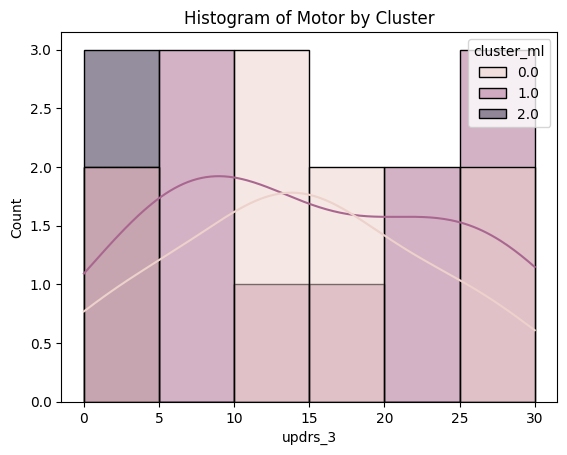

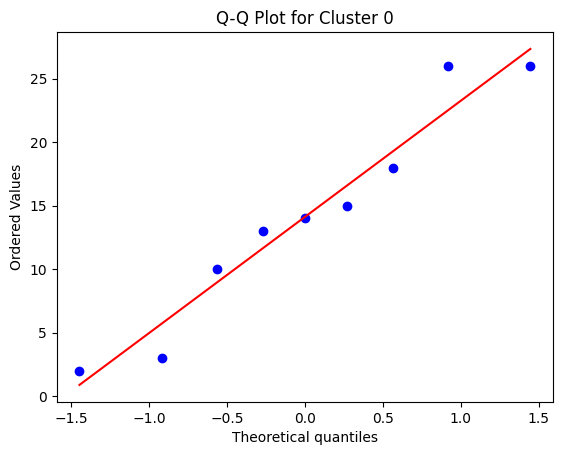

In [ ]:
'significan test between the scores distribution in each cluster - to go for parametric or non parametric'
#KW is a non-parametric test and doesn't assume normality — perfect for comparing 3 or more independent groups.
'''
if p = 0.4 > 0.05
➤ Fail to reject the null hypothesis.
➤ The data does not significantly deviate from a normal distribution.
So, normality is likely satisfied for that group.

If your Shapiro-Wilk test shows that all groups are normally distributed (p > 0.05), then you can use f_oneway (One-Way ANOVA), else KW.

'''
#======= STEP1: Test for Normality of motor per cluster =====
#By Shapiro

from scipy.stats import shapiro

for cluster_id in merged['cluster_ml'].unique():
    motor_values = merged[merged['cluster_ml'] == cluster_id]['updrs_3']
    stat, p = shapiro(motor_values)
    print(f"Cluster {cluster_id} - Shapiro-Wilk p-value: {p:.4f}")


#============================================================
#By Q-Q - vis.

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# For histogram
sns.histplot(data=merged, x='updrs_3', hue='cluster_ml', kde=True)
plt.title("Histogram of Motor by Cluster")
plt.show()

# For Q-Q plot (one cluster at a time)
cluster_id = 0  # example
motor_values = merged[merged['cluster_ml'] == cluster_id]['updrs_3']
stats.probplot(motor_values, dist="norm", plot=plt)
plt.title(f"Q-Q Plot for Cluster {cluster_id}")
plt.show()


In [ ]:
print(merged['cluster_ml'].unique())
print(merged)
#fill na with -1
merged['updrs_3'].fillna(-1, inplace=True)

[ 1.  8. nan  3.  2. 10.  5.  4.  6.  7.  9.]
      patient_id  visit_month  cluster_ml  updrs_1  updrs_2  updrs_3
0             55            0         1.0     10.0      6.0     15.0
1             55            6         8.0      8.0     10.0     34.0
2             55           12         8.0     10.0     10.0     41.0
3             55           36         NaN     17.0     18.0     51.0
4            942            6         8.0      8.0      2.0     21.0
...          ...          ...         ...      ...      ...      ...
1063       64674           84         NaN     11.0     15.0     45.0
1064       65043            0         1.0      2.0      6.0     16.0
1065       65043           12        10.0      4.0      7.0     14.0
1066       65043           24         NaN      4.0      8.0      NaN
1067       65043           48         NaN      7.0      6.0     13.0

[1068 rows x 6 columns]


In [ ]:
' -- Based on normality test : mannwhitneyu test for Significant difference between scores groups test ----'

'''
Tests whether there's a statistically significant difference in the distribution of updrs_1 across all groups (i.e. clusters).
It’s the non-parametric alternative to one-way ANOVA.
BUT it only tells you “at least one group is different”, not which groups differ.

If Kruskal-Wallis is significant:
Are the distributions of UPDRS_1 scores significantly different between all the clusters?
'''
from scipy.stats import mannwhitneyu,ttest_ind
from scipy.stats import kruskal

import pandas as pd

# Example DataFrame
# df = pd.DataFrame({'cluster': [...], 'motor': [...]})
filtered = merged.dropna(subset=['cluster_ml', 'updrs_3'])


# Group motor scores by cluster
grouped_data = filtered.groupby('cluster_ml')['updrs_3'].apply(list)

# Perform Kruskal-Wallis test
stat, p = kruskal(*grouped_data)

print(f"Kruskal-Wallis H-statistic: {stat:.3f}, p-value: {p:.4f}")
if p < 0.05:
    print("→ Significant difference between clusters (at least one is different)")
else:
    print("→ No significant difference between clusters")


# Oneway-anova
from scipy.stats import f_oneway

# Step 1: Group the motor scores by cluster
grouped = filtered.groupby('cluster_ml')['updrs_3'].apply(list)

# Step 2: Apply One-Way ANOVA
stat, p = f_oneway(*grouped)

# Step 3: Interpret the result
print(f"F-statistic: {stat:.3f}, p-value: {p:.4f}")

if p < 0.05:
    print("→ Statistically significant difference between clusters (at least one group differs)")
else:
    print("→ No statistically significant difference between clusters")

'''
# Get unique clusters (must be 2)
merged = merged.dropna(subset=['cluster_ml', 'updrs_3'])

clusters = merged['cluster_ml'].unique()
print('Clusssssters', clusters)
group1 = merged[merged['cluster_ml'] == clusters[0]]['updrs_1']
group2 = merged[merged['cluster_ml'] == clusters[1]]['updrs_1']

# Run Mann-Whitney U test
stat, p = mannwhitneyu(group1, group2, alternative='greater')

print(f"Mann-Whitney U statistic = {stat:.3f}, p-value = {p:.4f}")
if p < 0.05:
    print("→ Significant difference between groups")
else:
    print("→ No significant difference between groups")
print(clusters[1])

# Get unique clusters (must be 2)
clusters = merged['cluster_ml'].unique()
group1 = merged[merged['cluster_ml'] == clusters[0]]['updrs_1']
group2 = merged[merged['cluster_ml'] == clusters[1]]['updrs_1']

# Run Mann-Whitney U test
stat, p = ttest_ind(group1, group2, alternative='greater')

print(f"ttest_ind statistic = {stat:.3f}, p-value = {p:.4f}")
if p < 0.05:
    print("→ Significant difference between groups")
else:
    print("→ No significant difference between groups")
print(clusters[1])
'''

Kruskal-Wallis H-statistic: 6.896, p-value: 0.0318
→ Significant difference between clusters (at least one is different)
F-statistic: 3.530, p-value: 0.0477
→ Statistically significant difference between clusters (at least one group differs)


'\n# Get unique clusters (must be 2)\nmerged = merged.dropna(subset=[\'cluster_ml\', \'updrs_3\'])\n\nclusters = merged[\'cluster_ml\'].unique()\nprint(\'Clusssssters\', clusters)\ngroup1 = merged[merged[\'cluster_ml\'] == clusters[0]][\'updrs_1\']\ngroup2 = merged[merged[\'cluster_ml\'] == clusters[1]][\'updrs_1\']\n\n# Run Mann-Whitney U test\nstat, p = mannwhitneyu(group1, group2, alternative=\'greater\')\n\nprint(f"Mann-Whitney U statistic = {stat:.3f}, p-value = {p:.4f}")\nif p < 0.05:\n    print("→ Significant difference between groups")\nelse:\n    print("→ No significant difference between groups")\nprint(clusters[1])\n\n# Get unique clusters (must be 2)\nclusters = merged[\'cluster_ml\'].unique()\ngroup1 = merged[merged[\'cluster_ml\'] == clusters[0]][\'updrs_1\']\ngroup2 = merged[merged[\'cluster_ml\'] == clusters[1]][\'updrs_1\']\n\n# Run Mann-Whitney U test\nstat, p = ttest_ind(group1, group2, alternative=\'greater\')\n\nprint(f"ttest_ind statistic = {stat:.3f}, p-value = {

In [ ]:
from scipy.stats import kruskal

scores = ['updrs_1', 'updrs_2', 'updrs_3']  # or any list of scores you have

for score in scores:
    grouped_data = merged[merged['cluster_ml'].notna()].groupby('cluster_ml')[score].apply(list)

    stat, p = kruskal(*grouped_data)
    print(f"\nKruskal-Wallis for {score}: H = {stat:.3f}, p = {p:.4f}")

    if p < 0.05:
        print("→ Significant difference between at least two clusters")
    else:
        print("→ No significant difference")


'''
Kruskal-Wallis tells you: "There is some difference among clusters."
Dunn’s test tells you: "Which clusters are different for this score?"
'''
#f_oneway

for score in scores:
    grouped_data = merged[merged['cluster_ml'].notna()].groupby('cluster_ml')[score].apply(list)

    stat, p = f_oneway(*grouped_data)
    print(f"\nf_oneway for {score}: H = {stat:.3f}, p = {p:.4f}")

    if p < 0.05:
        print("→ Significant difference between at least two clusters")
    else:
        print("→ No significant difference")

import scikit_posthocs as sp

for score in scores:
    filtered = merged[merged['cluster_ml'].notna()][['cluster_ml', score]].dropna()

    posthoc = sp.posthoc_dunn(
        filtered,
        val_col=score,
        group_col='cluster_ml',
        p_adjust='fdr_bh'  # or 'bonferroni', 'fdr_bh'
    )

    print(f"\nDunn’s post-hoc test for {score}:\n", posthoc)




Kruskal-Wallis for updrs_1: H = 4.414, p = 0.1100
→ No significant difference

Kruskal-Wallis for updrs_2: H = 6.659, p = 0.0358
→ Significant difference between at least two clusters

Kruskal-Wallis for updrs_3: H = 6.896, p = 0.0318
→ Significant difference between at least two clusters

f_oneway for updrs_1: H = 2.246, p = 0.1306
→ No significant difference

f_oneway for updrs_2: H = 3.320, p = 0.0559
→ No significant difference

f_oneway for updrs_3: H = 3.530, p = 0.0477
→ Significant difference between at least two clusters

Dunn’s post-hoc test for updrs_1:
           0.0       1.0       2.0
0.0  1.000000  0.259655  0.259655
1.0  0.259655  1.000000  0.138320
2.0  0.259655  0.138320  1.000000

Dunn’s post-hoc test for updrs_2:
           0.0       1.0       2.0
0.0  1.000000  0.325563  0.099223
1.0  0.325563  1.000000  0.030576
2.0  0.099223  0.030576  1.000000

Dunn’s post-hoc test for updrs_3:
           0.0       1.0       2.0
0.0  1.000000  0.957260  0.023899
1.0  0.957260  

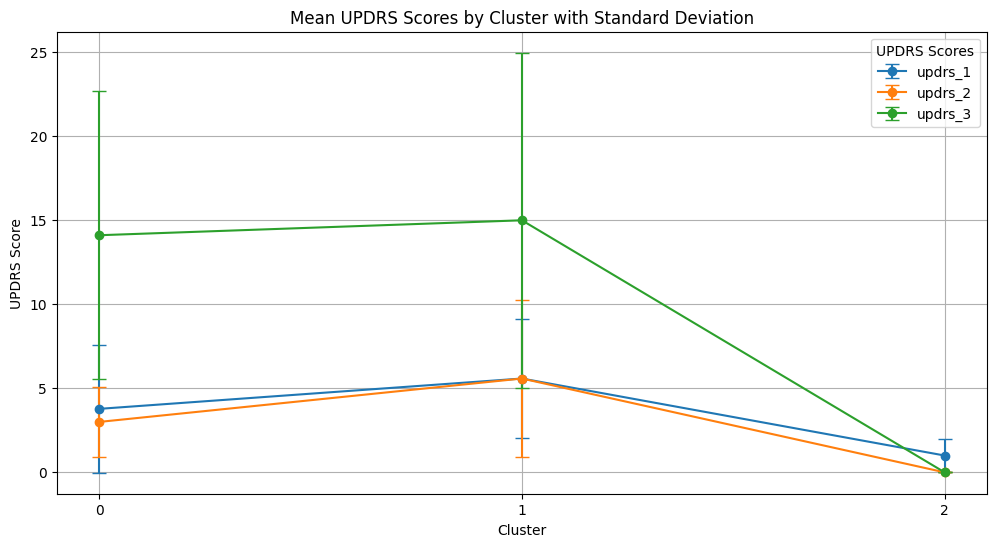

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

scores = ['updrs_1', 'updrs_2', 'updrs_3']

plt.figure(figsize=(12, 6))

for score in scores:
    data = merged[merged['cluster_ml'].notna()].groupby('cluster_ml')[score].agg(['mean', 'std']).reset_index()

    plt.errorbar(data['cluster_ml'], data['mean'], yerr=data['std'], label=score, marker='o', capsize=5)

plt.title('Mean UPDRS Scores by Cluster with Standard Deviation')
plt.xlabel('Cluster')
plt.ylabel('UPDRS Score')
plt.xticks(sorted(merged['cluster_ml'].dropna().unique()))
plt.legend(title='UPDRS Scores')
plt.grid(True)
plt.show()


/tmp/ipython-input-451020860.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(
/tmp/ipython-input-451020860.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(
/tmp/ipython-input-451020860.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


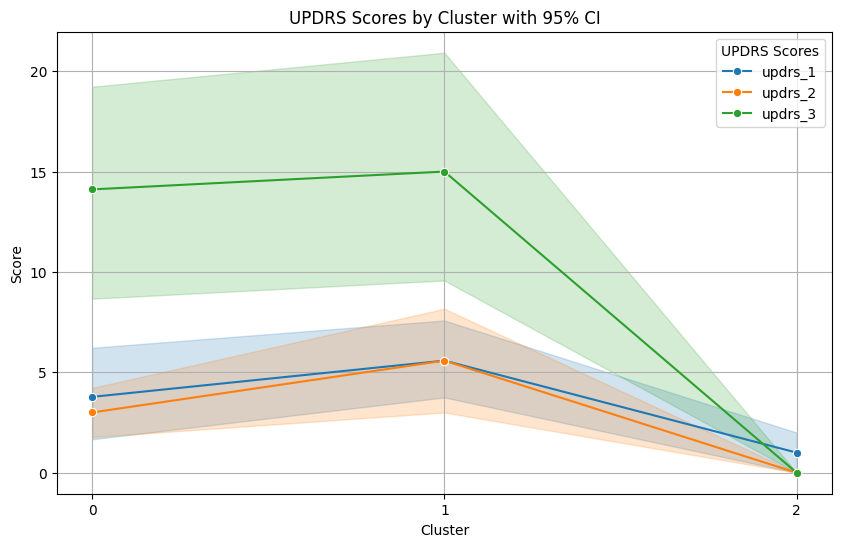

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

scores = ['updrs_1', 'updrs_2', 'updrs_3']

plt.figure(figsize=(10, 6))

for score in scores:
    sns.lineplot(
        data=merged[merged['cluster_ml'].notna()],
        x='cluster_ml',
        y=score,
        marker='o',
        label=score,
        ci=95  # 95% confidence interval shaded area
    )

plt.title('UPDRS Scores by Cluster with 95% CI')
plt.xlabel('Cluster')
plt.ylabel('Score')
plt.xticks(sorted(merged['cluster_ml'].dropna().unique()))
plt.legend(title='UPDRS Scores')
plt.grid(True)
plt.show()


          0.0       1.0       2.0       3.0
0.0  1.000000  0.749917  0.749917  0.749917
1.0  0.749917  1.000000  0.876880  0.876880
2.0  0.749917  0.876880  1.000000  0.965951
3.0  0.749917  0.876880  0.965951  1.000000


'\nYou use Bonferroni (very strict)\n→ Less likely to make false claims (Type I error)\n→ But power is low, so you might miss real differences\n→ Your post-hoc test might show no significant pairwise difference\n\nYou use FDR (fdr_bh) (less strict)\n→ Slightly more risk of false positives\n→ But power is higher, so you’re more likely to detect real differences\n'

In [ ]:
import pandas as pd

# Import datasets
df = pd.read_csv("/content/drive/MyDrive/data/train_peptides.csv")
med = pd.read_csv("/content/drive/MyDrive/data/train_clinical_data.csv")

# List of months to check
months_to_check = [0, 12, 24, 36, 48, 60]

# Group by patient_id and check if all months_to_check are present for each patient
patients_with_all_months = df.groupby('patient_id')['visit_month'].apply(lambda x: set(months_to_check).issubset(set(x)))

# Filter patients who have records in all months_to_check
patients_with_all_months = patients_with_all_months[patients_with_all_months].index.tolist()

# Filter the dataframe to only include patients with all the required months
df = df[df['patient_id'].isin(patients_with_all_months)]

# Group by patient_id and collect unique visit_months for each patient
months_with_records = df.groupby('patient_id')['visit_month'].apply(lambda x: set(x))

# Identify missing months for each patient (optional validation)
missing_months = {patient_id: sorted(set(months_to_check) - months_with_records.get(patient_id, set()))
                  for patient_id in patients_with_all_months}

# Time points to be removed
time_points_to_remove = [3, 6,18, 30, 54, 72, 84, 96, 108]

# Remove rows with the specified time points
filtered_df = df[~df['visit_month'].isin(time_points_to_remove)]
'''
# Filter out patients based on medication status (example from med dataset)
patients_to_remove = med[(med['upd23b_clinical_state_on_medication'] == 'On') |
                         (med['upd23b_clinical_state_on_medication'] == 'Off')]['patient_id'].tolist()

# Remove these patients from the dataframe
filtered_df = filtered_df[~filtered_df['patient_id'].isin(patients_to_remove)]
'''
'''
# Group by patient and visit_month, and create a list of (peptide_name, peptide_abundance) pairs
patient_month_data = df.groupby(['patient_id', 'visit_month']).apply(
    lambda x: list(zip(x['Peptide'], x['PeptideAbundance']))
).reset_index(name='peptide_data')
'''
# Pivot the dataframe to get peptide abundances for each visit_month and patient_id
df_selected = filtered_df.pivot_table(
    index=['patient_id', 'visit_month'], columns='Peptide', values='PeptideAbundance'
).reset_index().fillna(0)
'''
# Flatten MultiIndex columns
df_selected.columns = df_selected.columns.to_flat_index()
'''
# Print the pivoted dataframe
print(df_selected['visit_month'].unique())
print(df_selected['patient_id'].unique())

# Optional: statistical analysis and further processing (if needed)
# e.g., testing if the PeptideAbundances follow a normal distribution (omitted for brevity)
print(df_selected)

[ 0 12 24 36 48 60]
[ 4172  5178  6211 17414 18183 20404 23391 25562 26210 27300 27468 28327
 35477 35696 40022 41444 45161 54095 57009 59550 60803 62723 62792 63889]
Peptide  patient_id  visit_month  AADDTWEPFASGK  \
0              4172            0     10687500.0   
1              4172           12     13457500.0   
2              4172           24     10770800.0   
3              4172           36      8285590.0   
4              4172           48      7605160.0   
..              ...          ...            ...   
139           63889           12     11685200.0   
140           63889           24      1297330.0   
141           63889           36     12315800.0   
142           63889           48      1019910.0   
143           63889           60     10715200.0   

Peptide  AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K  \
0                                                 45885.7   
1                                                 59488.3   
2                                    

In [ ]:
'outliers'

import numpy as np
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
import numpy as np
import pandas as pd

# Step 1: Define feature columns
feature_columns = df_selected.columns.difference(['patient_id', 'visit_month'])

# Step 2: Standardize features (Euclidean works best when features are on the same scale)
'''
#scaler = StandardScaler()
scaler=RobustScaler()
df_selected[feature_columns] = scaler.fit_transform(df_selected[feature_columns])
# Step 3: Calculate the 5th percentile distance per age, then average these thresholds
thresholds_per_age = []
selected_ages = sorted(df_selected['visit_month'].unique())

# Step 1: Detect outliers in any feature
outlier_mask = (df_selected[feature_columns] > 3) | (df_selected[feature_columns] < -3)

# Step 2: Get rows that have any outlier
rows_with_outliers = outlier_mask.any(axis=1)

# Step 3: Filter them out
df_selected = df_selected[~rows_with_outliers].reset_index(drop=True)

'''
'threshold calcs'

#1) Euclidean distance
selected_ages = sorted(df_selected['visit_month'].unique())

thresholds_per_age=[]
for age in selected_ages:
    year_data = df_selected[df_selected['visit_month'] == age].reset_index(drop=True)
    num_patients = len(year_data)

    if num_patients < 2:
        continue  # skip ages with less than 2 patients

    distances = []
    for i in range(num_patients):
        for j in range(i + 1, num_patients):
            patient_i = year_data.loc[i, feature_columns].values.reshape(1, -1)
            patient_j = year_data.loc[j, feature_columns].values.reshape(1, -1)
            dist = euclidean_distances(patient_i, patient_j)[0][0]
            distances.append(dist)

    if distances:
        # Get 5th percentile (i.e., most similar pairs with low distance)
        threshold_5 = np.percentile(distances, 5)
        thresholds_per_age.append(threshold_5)

# Calculate mean of 5th percentile distances across all ages
average_distance_threshold = np.mean(thresholds_per_age)
print(f"Global Euclidean distance threshold (mean of 5th percentiles): {average_distance_threshold:.4f}")
'''
#2) cosine similarity

# Step 3: Calculate the 90th percentile similarity per age, then average these thresholds
thresholds_per_age = []
selected_ages = sorted(df_selected['visit_month'].unique())

for age in selected_ages:
    year_data = df_selected[df_selected['visit_month'] == age].reset_index(drop=True)
    num_patients = len(year_data)

    if num_patients < 2:
        continue  # skip ages with less than 2 patients

    similarities = []
    for i in range(num_patients):
        for j in range(i + 1, num_patients):
            patient_i = year_data.loc[i, feature_columns].values.reshape(1, -1)
            patient_j = year_data.loc[j, feature_columns].values.reshape(1, -1)
            sim = cosine_similarity(patient_i, patient_j)[0][0]
            similarities.append(sim)

    if similarities:
        # Get 90th percentile for this age
        threshold_90 = np.percentile(similarities, 95)
        thresholds_per_age.append(threshold_90)

# Calculate mean of 90th percentile thresholds across all ages
average_distance_threshold = np.mean(thresholds_per_age)
print(f"Global similarity threshold (mean of 90th percentiles): {average_distance_threshold:.4f}")
'''
threshold=average_distance_threshold

Global Euclidean distance threshold (mean of 5th percentiles): 15763284.4015


Epoch 20, Loss: 0.6929
Epoch 40, Loss: 0.6928
Epoch 60, Loss: 0.6925
Epoch 80, Loss: 0.6919
Epoch 100, Loss: 0.6916
Epoch 120, Loss: 0.6910
Epoch 140, Loss: 0.6906
Epoch 160, Loss: 0.6903
Epoch 180, Loss: 0.6902
torch.Size([6, 24, 4])

Best K based on Silhouette Score: 2
  Best Silhouette = 0.7720
  Davies-Bouldin Index: 0.3838
  Calinski-Harabasz Index: 516.4599


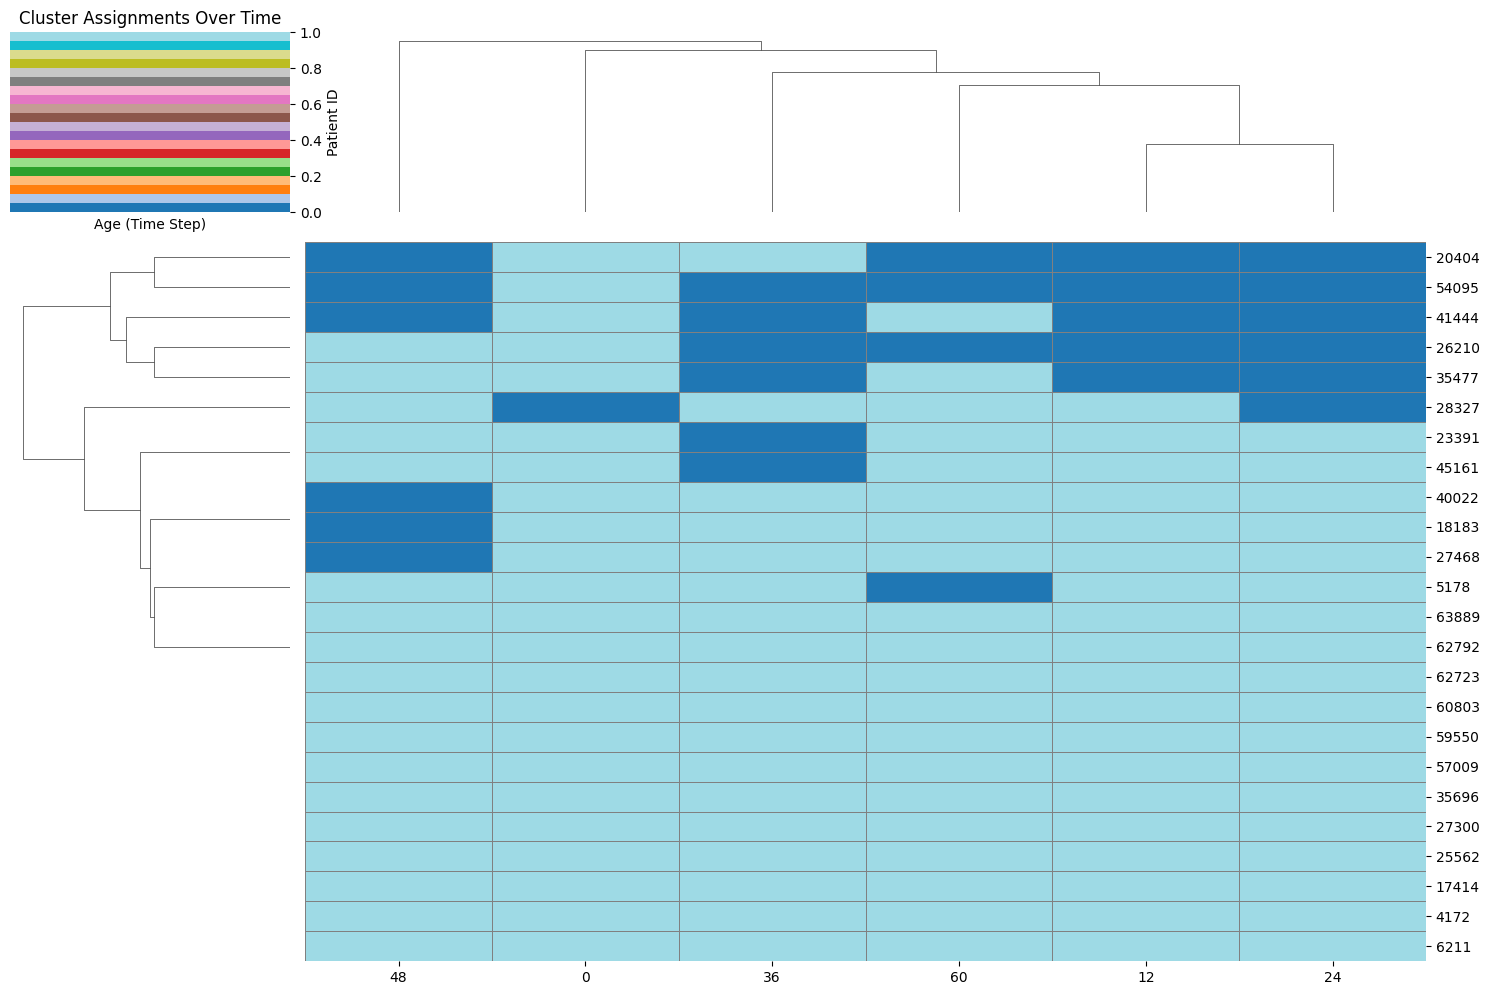


Best K = 2
Silhouette = 0.6915, DBI = 0.1995, CHI = 15.9842


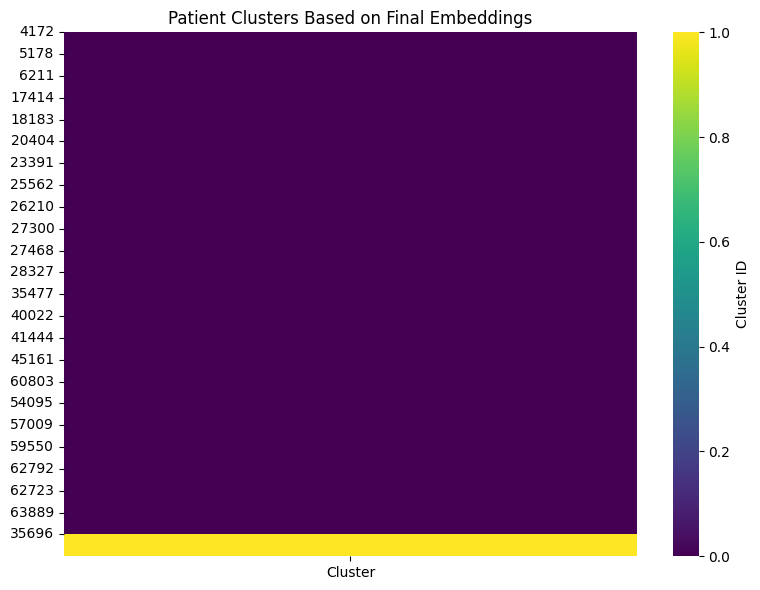

In [ ]:
'GC-LSTM'
#df_selected=df_selected1.copy(deep=True)
'Integrated Dynamic GNN' # GC-LSTM (GCN + LSTM)
'''
GC-LSTM uses the adjacency matrix of a given
time as input to the LSTM and performs spectral graph
convolution [28,61] on the hidden layer. The model takes a
sequence of
'''
# Install dependencies (if needed)
#!pip install torch_geometric
#!pip install tensorboard
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, GAE
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import networkx as nx
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd




import random
# This ensures fixed weight initialization for the neural network
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
def euclidean_perm_test(vec1, vec2):
    vec1 = torch.tensor(vec1, device='cpu', dtype=torch.float32)
    vec2 = torch.tensor(vec2, device='cpu', dtype=torch.float32)
    dist = torch.norm(vec1 - vec2)
    return dist.item()

# ========== 1. Prepare Geometric Data Object (Graph Object) ==========
# Create GLOBAL node mapping (critical for consistency)
all_nodes = sorted(set(df_selected['patient_id']))
global_node_to_index = {node: i for i, node in enumerate(all_nodes)}
num_nodes = len(all_nodes)

# Build graphs with consistent node ordering
graphs = []
for age in selected_ages:
    year_data = df_selected[df_selected['visit_month'] == age]
    G = nx.Graph()

    # Add nodes with features using GLOBAL indices
    for _, row in year_data.iterrows():
        features = {feature: row[feature] for feature in feature_columns}
        G.add_node(row['patient_id'], **features)

    # Add edges
    added_edges = set()
    for i, row1 in year_data.iterrows():
        for j, row2 in year_data.iterrows():
            if i < j:  # Avoid duplicate pairs
                  node1, node2 = row1['patient_id'], row2['patient_id']
                  pair = tuple(sorted((node1, node2)))
                  if pair not in added_edges:
                      similarity = euclidean_perm_test(row1[feature_columns].values,
                                                row2[feature_columns].values)
                      if similarity <= threshold: #sim_threshold:#sim_threshold:
                          G.add_edge(node1, node2, similarity=similarity)
                          added_edges.add(pair)
    graphs.append(G)

# Convert to PyG Data objects with consistent indexing
all_data = []
for graph in graphs:
    # Initialize node features matrix using GLOBAL ordering
    node_features = np.zeros((num_nodes, len(feature_columns)))
    for node in graph.nodes:
        idx = global_node_to_index[node]
        node_features[idx] = [graph.nodes[node][feature] for feature in feature_columns]

    # === 🧪 Standardize node features HERE ===
    scaler = RobustScaler()
    node_features = scaler.fit_transform(node_features)

    # Build edge_index using GLOBAL indices
    edge_index = []
    for u, v in graph.edges():
        edge_index.append([global_node_to_index[u], global_node_to_index[v]])

    # Correctly handle empty edge list and create a 2xN tensor
    if not edge_index: # Check if the list is empty
        # If no edges, create self-loops as a 2xN tensor
        edge_index = torch.arange(num_nodes, dtype=torch.long).repeat(2, 1)
    else:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    all_data.append(Data(x=torch.tensor(node_features, dtype=torch.float),
                        edge_index=edge_index))

# ========== 2. Define GC-LSTM (GCN + LSTM) ==========

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv # for spectral

class GCLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

        # Spectral GNNs for each LSTM gate
        self.gnn_i = ChebConv(hidden_dim, hidden_dim, K=2)  # K=2 for Chebyshev polynomials
        self.gnn_f = ChebConv(hidden_dim, hidden_dim, K=2)
        self.gnn_o = ChebConv(hidden_dim, hidden_dim, K=2)
        self.gnn_u = ChebConv(hidden_dim, hidden_dim, K=2)

        # Linear layers for adjacency-aware transformations
        self.W_i = nn.Linear(input_dim, hidden_dim)
        self.W_f = nn.Linear(input_dim, hidden_dim)
        self.W_o = nn.Linear(input_dim, hidden_dim)
        self.W_u = nn.Linear(input_dim, hidden_dim)

    #The GCLSTMCell also contains a forward function, which computes the next hidden state and cell state for the LSTM, while applying spectral graph convolutions to the gates.
    def forward(self, x_t, edge_index, h_prev, c_prev):
        # Compute A_t @ W (adjacency-aware transformation)
        A_t = torch.sparse_coo_tensor(edge_index, torch.ones(edge_index.shape[1]), size=(x_t.shape[0], x_t.shape[0])).to(x_t.device)
        # Assuming x_t is on the same device as edge_index
        # STEP 1: x_t node features are multiplied by the adjacency matrix to account for graph structure at each time step.
        x_transformed = torch.sparse.mm(A_t, x_t)  # [N, F] -> [N, F] (A_t @ X_t)

        #STEP2 GNN Gates computations using (spectral convolutions; ChebConv)
        g_i = torch.sigmoid(self.gnn_i(h_prev, edge_index))
        g_f = torch.sigmoid(self.gnn_f(h_prev, edge_index))
        g_o = torch.sigmoid(self.gnn_o(h_prev, edge_index))
        g_u = torch.tanh(self.gnn_u(h_prev, edge_index))

        #These gates are then combined with the transformed features to compute the final
        #LSTM gates (i_t, f_t, o_t, u_t), which will be used to update the hidden and cell states.
        # Combine with A_t @ W ;
        i_t = torch.sigmoid(self.W_i(x_transformed) + g_i)  # Input gate
        f_t = torch.sigmoid(self.W_f(x_transformed) + g_f)  # Forget gate
        o_t = torch.sigmoid(self.W_o(x_transformed) + g_o)  # Output gate
        u_t = torch.tanh(self.W_u(x_transformed) + g_u)     # Candidate update

        # Update states
        c_t = f_t * c_prev + i_t * u_t
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

'''
This module integrates the GCLSTMCell and processes the entire sequence of
graphs over time. The forward pass iterates over the sequence of adjacency
matrices and node features, updating the hidden and cell states at each
time step.
'''
class GCLSTMEncoder(nn.Module):
    def __init__(self, input_dim, gcn_hidden_dim, lstm_hidden_dim):
        super().__init__()
        self.lstm_hidden_dim = lstm_hidden_dim
        self.gclstm_cell = GCLSTMCell(input_dim, lstm_hidden_dim) # this is for the structure
    #The forward pass iterates over the sequence of adjacency matrices and node features,
    #updating the hidden and cell states at each time step.
    def forward(self, x_seq, edge_index_seq):
        """
        x_seq: [T, N, F] - Sequence of node features
        edge_index_seq: List of edge_index tensors (one per time step)
        """
        N = x_seq.size(1)  # Number of nodes
        T = x_seq.size(0)  # Sequence length

        # Initialize hidden and cell states to zeros
        h = torch.zeros(N, self.lstm_hidden_dim).to(x_seq.device)
        c = torch.zeros(N, self.lstm_hidden_dim).to(x_seq.device)

        '''
        Below, The network processes each time step sequentially.
        The node features and edge indices (representing the graph at
        each time step) are passed through the GCLSTMCell to compute
        updated hidden and cell states.
        '''
        outputs = []
        for t in range(T):
            x_t = x_seq[t]                     # [N, F]
            edge_index_t = edge_index_seq[t]     # [2, E]
            h, c = self.gclstm_cell(x_t, edge_index_t, h, c)
            outputs.append(h)

        outputs = torch.stack(outputs, dim=0)   # [T, N, hidden_dim]
        #a list where we store the hidden states (h_t) for each time step.
        return outputs # Return last hidden state


# ========== 4. Training ==========

def train(x_seq, edge_index_seq, target_adj_seq):
    """
    Train function to predict adjacency matrix.

    Args:
    - x_seq: Node feature sequence [T, N, F] - Sequence of node features (over time)
    - edge_index_seq: List of edge_index tensors (one per time step) [T, 2, E]
    - target_adj_seq: Sequence of actual adjacency matrices [T, N, N] (target adjacency matrices for each time step)

    Returns:
    - loss: Computed loss
    - pred_adj_seq: Predicted adjacency matrices for each time step
    """
    encoder.train()
    optimizer.zero_grad()

    # Get node embeddings from encoder (hidden states from LSTM)
    node_embeddings = encoder(x_seq, edge_index_seq)  # [T, N, hidden_dim]

    # Predicted adjacency matrix computation (using dot product between node embeddings)
    pred_adj_seq = []
    for t in range(node_embeddings.size(0)):  # Iterate over the time steps
        node_embed_t = node_embeddings[t]  # [N, hidden_dim] for time t

        # Calculate the predicted adjacency matrix for this time step
        pred_adj_t = torch.sigmoid(torch.matmul(node_embed_t, node_embed_t.T))  # [N, N]
        pred_adj_seq.append(pred_adj_t.unsqueeze(0))  # Add to sequence list

    pred_adj_seq = torch.cat(pred_adj_seq, dim=0)  # [T, N, N] - Predicted adjacency matrix sequence

    # Compute the binary cross-entropy loss between predicted and actual adjacency matrices
    # Flatten both predicted and target sequences for loss calculation
    loss = F.binary_cross_entropy(pred_adj_seq.view(-1), target_adj_seq.view(-1))

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), pred_adj_seq


# ========== 5. Training Loop ==========
# First, we need to prepare the target adjacency sequence
# Convert edge_index_seq to dense adjacency matrices

'''
# ========== 3. TensorBoard Setup ==========
log_dir = f"runs/gclstm_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
writer = SummaryWriter(log_dir)
'''

# Convert list of Data objects to tensors
x_seq = torch.stack([data.x for data in all_data], dim=0)  # [T, N, F] - Feature sequence
edge_index_seq = [data.edge_index for data in all_data]    # List of [2, E] edge indices per time step

adj_seq = []
for edge_index in edge_index_seq:
    num_nodes = x_seq.size(1)
    adj = torch.zeros(num_nodes, num_nodes)
    if edge_index.size(1) > 0:  # Only if edges exist
        adj[edge_index[0], edge_index[1]] = 1  # Set edges to 1
    adj_seq.append(adj)
adj_seq = torch.stack(adj_seq)  # [T, N, N]



'''
loss_best=1000
N=[4,8,16,32,64,128]
for i in N:
  for j in N:
'''
# Initialize the encoder with appropriate dimensions
encoder = GCLSTMEncoder(
    input_dim=all_data[0].num_node_features,  # Number of features per node
    gcn_hidden_dim=8,  # GCN hidden dimension
    lstm_hidden_dim=4  # LSTM hidden dimension
)
# Set up the optimizer
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01)

for epoch in range(1, 200):
    # Forward pass - use entire sequence of adjacency matrices as target
    loss, pred_adj_seq = train(x_seq, edge_index_seq, adj_seq)
    # Logging
    #writer.add_scalar("Loss/train", loss, epoch)
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")
'''
        if loss<loss_best:
            loss_best=loss
            ii=i
            jj=j
print('best parameters:', ii, jj, loss_best)
'''


#writer.close()  # Close TensorBoard writer
encoder.eval()  # Set the encoder to evaluation mode

# ========== 6. Post Training Node Embedding Extraction ==========

all_node_representations = []

with torch.no_grad():
  '--------------Below gets the final embeddings for each node----------------'
  # 1. Final node embeddings: shape [T, N, hidden_dim]
  final_node_embeddings = encoder(x_seq, edge_index_seq)  # [T, N, D]
  T, N, D = final_node_embeddings.shape

  # 2. Create a mask of shape [T, N] to track node availability at each time step
  presence_mask = torch.stack([
      (data.x.abs().sum(dim=1) != 0)  # True if node has non-zero features
      for data in all_data
  ])  # Shape: [T, N]

  last_embeddings = torch.zeros(N, D)
  subjid_list = []
  index_to_subjid = {idx: subjid for subjid, idx in global_node_to_index.items()}

  for node_idx in range(N):
      # Find all valid time steps for this node
      valid_times = torch.where(presence_mask[:, node_idx])[0]

      if len(valid_times) > 0:
          last_t = valid_times[-1]
          last_embeddings[node_idx] = final_node_embeddings[last_t, node_idx]
      else:
          last_embeddings[node_idx] = torch.zeros(D)  # Or mark with NaNs

      # Collect subject ID for this node
      subjid_list.append(index_to_subjid[node_idx])

  '----------------------------------------------------------------------------'
  '--------Below gets nodes embeddings for each node in all time steps---------'
  all_node_representations = encoder(x_seq, edge_index_seq)
  print(all_node_representations.shape)  # [T, N, 16] - Final node embeddings after LSTM

  '----------------------------------------------------------------------------'




# --- KMEANS CLUSTERING ---
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
'-----------------------------1) states --------------------------------------------------------------------------'
# Convert PyTorch tensors to NumPy arrays and detach from computation graph
all_node_representations_np = all_node_representations.cpu().numpy()

#----->Concatenate the node representations into a single 2D array<-----
all_node_representations_np = all_node_representations_np.reshape(T * N, D)
node_info = []
for age, G in zip(selected_ages, graphs):
    for node in G.nodes():
        node_info.append({'patient_id': node, 'visit_month': age})

'---------------> Clustering---------------------->'

# Determine range of k
max_limit = 20
unique_combinations = len(node_info)
k_max = min(unique_combinations, int(math.sqrt(unique_combinations)), max_limit)
range_n_clusters = list(range(2, k_max + 1))

# Grid search to find best k using silhouette score
best_k = 2
best_score = -1
best_labels_s = None

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(all_node_representations_np)

    if len(np.unique(labels)) > 1:
        score = silhouette_score(all_node_representations_np, labels)
        if score > best_score:
            best_k = k
            best_score = score
            best_labels_s = labels

# Final clustering using best_k
if best_labels_s is not None:
    cluster_labels_s = best_labels_s
else:
    # Handle the case where no valid clustering was found (e.g., all data points are identical)
    cluster_labels_s = np.zeros(all_node_representations_np.shape[0], dtype=int)
    best_k = 1 # Set best k to 1 or handle as an error state

print(f"\nBest K based on Silhouette Score: {best_k}")
print(f"  Best Silhouette = {best_score:.4f}")

# Compute other metrics for the best clustering ONLY if more than one cluster exists
if len(np.unique(cluster_labels_s)) > 1:
    db_index = davies_bouldin_score(all_node_representations_np, cluster_labels_s)
    ch_index = calinski_harabasz_score(all_node_representations_np, cluster_labels_s)

    print(f"  Davies-Bouldin Index: {db_index:.4f}")
    print(f"  Calinski-Harabasz Index: {ch_index:.4f}")
else:
    print(f"Clustering resulted in only 1 cluster at best k={best_k}. Skipping metrics.")


cmap = plt.get_cmap("tab20").copy()  # Use copy to modify safely
cmap.set_bad(color='white')         # NaN values will appear white

# 3. Draw heatmap
import pandas as pd
import numpy as np

# 1. Build a matrix to hold cluster IDs per patient per time step
patient_ids = sorted(all_nodes)
time_labels = selected_ages
cluster_matrix = pd.DataFrame(index=patient_ids, columns=time_labels)

# 2. Fill the matrix by reshaping cluster_labels_s
cluster_matrix_reshaped = cluster_labels_s.reshape(T, N).T # Reshape to [N, T] and transpose

for t_idx, age in enumerate(selected_ages):
  for n_idx, patient_id in enumerate(patient_ids):
    cluster_matrix.loc[patient_id, age] = cluster_matrix_reshaped[n_idx, t_idx]


# 3. Convert to numeric (in case of missing values, they’ll be NaNs)
cluster_matrix = cluster_matrix.astype(float)


# Clustered heatmap (rows = nodes, cols = time steps)
sns.clustermap(
    cluster_matrix,
    cmap=cmap,
    linewidths=0.5,
    linecolor='gray',
    row_cluster=True,
    col_cluster=True,
    figsize=(15, 10)
)

plt.xlabel("Age (Time Step)")
plt.ylabel("Patient ID")
plt.title("Cluster Assignments Over Time")
plt.tight_layout()
plt.show()

'-----------------------------------------END of States Clustering--------------------------------------'

'------------------------------------------2) Groups ---------------------------------------------------'
# Use only final patient embedding (one per patient)
X = last_embeddings.cpu().numpy()  # [N, D] numpy array

# Optional: standardize for better clustering
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Set max cluster range based on number of unique patients
max_limit = 20
num_patients = X.shape[0]
k_max = min(num_patients, int(np.sqrt(num_patients)), max_limit)
range_n_clusters = list(range(2, k_max + 1))

# --- Clustering Metrics ---
Best_k = -1
Best_silhouette = -1
Best_dbi = float('inf')
Best_chi = -1

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    if len(np.unique(labels)) == 1:
        continue
    silhouette = silhouette_score(X_scaled, labels)
    dbi = davies_bouldin_score(X_scaled, labels)
    chi = calinski_harabasz_score(X_scaled, labels)

    if silhouette > Best_silhouette:
        Best_silhouette = silhouette
        Best_k = k
        Best_dbi = dbi
        Best_chi = chi

print(f"\nBest K = {Best_k}")
print(f"Silhouette = {Best_silhouette:.4f}, DBI = {Best_dbi:.4f}, CHI = {Best_chi:.4f}")

# Final clustering
cluster_labels = KMeans(n_clusters=Best_k, init='k-means++', n_init=10, random_state=42).fit_predict(X_scaled)

index_to_subjid = {i: subjid for i, subjid in enumerate(subjid_list)}

node_cluster_mapping = {
    index_to_subjid[i]: cluster_labels[i]
    for i in range(len(cluster_labels))
}

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

cluster_df = pd.DataFrame.from_dict(node_cluster_mapping, orient='index', columns=["Cluster"])
cluster_df_sorted = cluster_df.sort_values(by="Cluster")

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cluster_df_sorted, cmap="viridis", cbar_kws={'label': 'Cluster ID'}, annot=False, fmt='d', cbar=True)

ax.set_yticks(range(len(cluster_df_sorted)))
ax.set_yticklabels(cluster_df_sorted.index, rotation=0)
plt.title("Patient Clusters Based on Final Embeddings")
plt.tight_layout()
plt.show()

all_data shape:  6   torch.Size([24, 968])
Epoch 20, Loss: 4.1629
Epoch 40, Loss: 4.1480
Epoch 60, Loss: 4.1417
Epoch 80, Loss: 4.1379
Epoch 100, Loss: 4.1354
Epoch 120, Loss: 4.1324
Epoch 140, Loss: 4.1290
Epoch 160, Loss: 4.1266
Epoch 180, Loss: 4.1233
Epoch 200, Loss: 4.1213
Epoch 220, Loss: 4.1199
Epoch 240, Loss: 4.1188

Best K = 2
Silhouette = 0.6915, DBI = 0.1995, CHI = 15.9842

Best K based on Silhouette Score: 2
  Best Silhouette = 0.6915
  Corresponding DBI = 0.1995
  Corresponding CHI = 15.9842


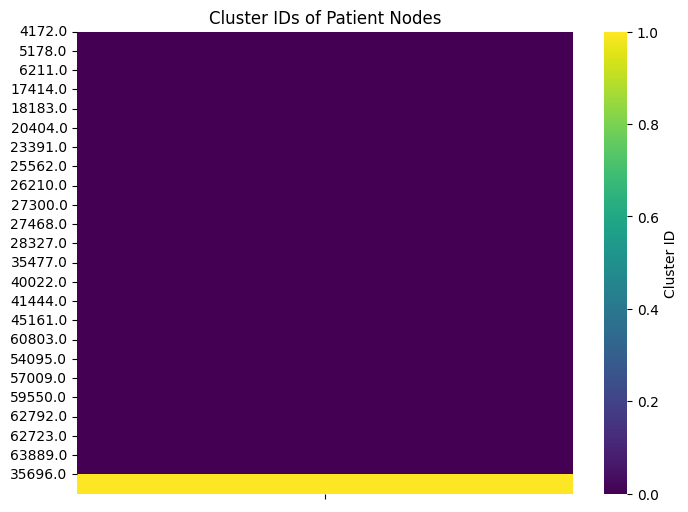


Best K = 2
Silhouette = 0.6915, DBI = 0.1995, CHI = 15.9842


ValueError: could not broadcast input array from shape (24,) into shape (6,)

In [ ]:
'T-GCN'
'T-GCN (1/4) - Load the graph'
# Install dependencies (if needed)
#!pip install torch_geometric
#!pip install tensorboard

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, GAE
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import random
# This ensures fixed weight initialization for the neural network
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

#===========Again creating the graph ================================
# Build graphs

graphs = []

for plot_index, age in enumerate(selected_ages): # Change i to plot_index
    year_data = df_selected[df_selected['visit_month'] == age]
    G = nx.Graph()
    added_edges = set()
    edge_thickness = {}

    # Add nodes for this age group
    for _, row in year_data.iterrows():
        # Add original features directly to the node
        features = {feature: row[feature] for feature in feature_columns}
        G.add_node(row['patient_id'],  **features)  # cag=row['cag'],age=row['age'], removed

    for i, row1 in year_data.iterrows():
        for j, row2 in year_data.iterrows():
            if i != j and row1['patient_id'] != row2['patient_id']:
                pair = tuple(sorted((row1['patient_id'], row2['patient_id'])))
                if pair not in added_edges:
                  similarity= euclidean_perm_test(row1[feature_columns].values.astype(float), row2[feature_columns].values.astype(float))
                  if similarity <= threshold:# and p_value <= 0.05:
                        G.add_edge(row1['patient_id'], row2['patient_id'],similarity=similarity)#, p_value=p_value)
                        added_edges.add(pair) #This is only useful if you're checking for duplicate edges before adding them.

    # ----> Append the graph to the list <----
    graphs.append(G)
# ========== 1. Prepare Data ================

all_data = []

for graph in graphs:
    node_features = np.array([
        [graph.nodes[node][feature] for feature in feature_columns]
        for node in graph.nodes
    ])
    node_to_index = {node: i for i, node in enumerate(graph.nodes)}

    # === 🧪 Standardize node features HERE ===
    scaler = RobustScaler()
    node_features = scaler.fit_transform(node_features)

    # Check if the graph has edges before creating edge_index
    if graph.edges():  # If graph has edges
        edge_index = np.array([(node_to_index[u], node_to_index[v])
                               for u, v in graph.edges]).T
    else:  # If graph has no edges
        edge_index = np.empty((2, 0), dtype=int)  # Create an empty edge_index

    data = Data(x=torch.tensor(node_features, dtype=torch.float),
                edge_index=torch.tensor(edge_index, dtype=torch.long))
    all_data.append(data)

print('all_data shape: ', len(all_data), ' ', all_data[0].x.shape)


'T-GCN (2/4) - Train the model'

# ========== 2. Define T-GCN (GCN + GRU) ==========

class TGCNEncoder(nn.Module):
    def __init__(self, input_dim, gcn_hidden_dim, gru_hidden_dim):
        super().__init__()
        self.gcn = GCNConv(input_dim, gcn_hidden_dim)
        self.gru = nn.GRU(gcn_hidden_dim, gru_hidden_dim, batch_first=True)

    def forward(self, x_seq, edge_index_seq):
        '''
        x_seq: [T, N, F]
        edge_index_seq: list of edge_index per time step
        '''
        gcn_out = []
        for t in range(x_seq.size(0)):
            x_t = x_seq[t]  # [N, F]
            edge_index_t = edge_index_seq[t]
            h_t = F.relu(self.gcn(x_t, edge_index_t))  # [N, gcn_hidden]
            gcn_out.append(h_t)

        gcn_out = torch.stack(gcn_out, dim=0)  # [T, N, gcn_hidden]
        gcn_out = gcn_out.permute(1, 0, 2)     # [N, T, gcn_hidden]
        out, _ = self.gru(gcn_out)             # [N, T, gru_hidden]
        return out#[:, -1, :]                   # return final hidden state per node



# ========== 3. TensorBoard Setup ==========
log_dir = f"runs/gae_gcn_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
writer = SummaryWriter(log_dir)

# ========== 4. Training ==========

def train(x_seq, edge_index_seq):
    encoder.train()
    optimizer.zero_grad()
    z = encoder(x_seq, edge_index_seq)         # [N, T, D]
    z = z.permute(1, 0, 2)                     # [T, N, D]
    loss = reconstruction_loss(z, edge_index_seq)
    loss.backward()
    optimizer.step()
    return loss.item(), z

from torch_geometric.utils import to_dense_adj

def reconstruction_loss(embeddings, edge_index_seq):
    loss = 0
    T = min(embeddings.shape[0], len(edge_index_seq))  # Prevent index overflow
    for t in range(T):
        emb_t = embeddings[t]                        # [N, D]
        pred_adj = torch.sigmoid(emb_t @ emb_t.T)    # [N, N]
        adj_dense = to_dense_adj(edge_index_seq[t], max_num_nodes=emb_t.size(0))[0]  # [N, N]
        loss += F.binary_cross_entropy(pred_adj, adj_dense)
    return loss

# Convert list of Data objects to tensors
x_seq = torch.stack([data.x for data in all_data], dim=0)  # [T, N, F]
edge_index_seq = [data.edge_index for data in all_data]    # List of [2, E]
# Get the node features at the last time step and only select the
# first 'gru_hidden_dim' features to match the output of the GRU
#target = x_seq[-1, :, :encoder.gru.hidden_size]  #[last time step, all features, the number of features /or gru hidden dimention]

# Training loop
'''
best_loss=1000
Numbers=[4,8,16,32,64,128]
for i in Numbers:
  for j in Numbers:
'''
encoder = TGCNEncoder(
    input_dim=all_data[0].num_node_features,
    gcn_hidden_dim=8,#64,#24, #32
    gru_hidden_dim=4#all_data[0].num_node_features
)
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01 )
for epoch in range(1, 250):
    loss, z = train(x_seq, edge_index_seq)
    if epoch % 20 == 0:
        #writer.add_embedding(z, global_step=epoch, tag="TGCN Embeddings")
        print(f"Epoch {epoch}, Loss: {loss:.4f}")
'''
        if loss < best_loss:
          best_loss=loss
          best_i=i
          best_j=j
print(f">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Epoch {epoch}, Loss: {loss:.4f}", i, j)
'''
# Log to TensorBoard
#writer.add_scalar("Loss/train", loss, epoch)



writer.close()
encoder.eval()

# ========== 5. Post Training Node Embedding Extraction ==========


with torch.no_grad():
    final_node_embeddings_s = encoder(x_seq, edge_index_seq)
    final_node_embeddings_g = final_node_embeddings_s[:, -1, :]  # [N, D]

'T-GCN (3/4) - Group Clustering'
'STEP3:TEMPORAL EMBEDDINGS [With spatial consideration]-TGCN (GCN+GRU)'
# ========== 6. Clustering and Visualization ==========

from scipy.cluster.hierarchy import linkage, fcluster
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# 1. Perform hierarchical clustering using linkage
# Extract the embeddings to a NumPy array
embeddings_np = final_node_embeddings_g.cpu().numpy()

# Standardize the embeddings (important for linkage)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings_np)

# Perform linkage clustering
# 2. Evaluate silhouette scores for different cluster counts


# Get the number of samples from the embedding matrix
n_samples = embeddings_np.shape[0]


# --- Clustering Metrics ---
Best_k = -1
Best_silhouette = -1
Best_dbi = float('inf')
Best_chi = -1

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    if len(np.unique(labels)) == 1:
        continue
    silhouette = silhouette_score(X_scaled, labels)
    dbi = davies_bouldin_score(X_scaled, labels)
    chi = calinski_harabasz_score(X_scaled, labels)

    if silhouette > Best_silhouette:
        Best_silhouette = silhouette
        Best_k = k
        Best_dbi = dbi
        Best_chi = chi

print(f"\nBest K = {Best_k}")
print(f"Silhouette = {Best_silhouette:.4f}, DBI = {Best_dbi:.4f}, CHI = {Best_chi:.4f}")

# Final clustering
cluster_labels = KMeans(n_clusters=Best_k, init='k-means++', n_init=10, random_state=42).fit_predict(X_scaled)

print(f"\nBest K based on Silhouette Score: {Best_k}")
print(f"  Best Silhouette = {Best_silhouette:.4f}")
print(f"  Corresponding DBI = {Best_dbi:.4f}")
print(f"  Corresponding CHI = {Best_chi:.4f}")

# *** Calculate Silhouette Score ***
silhouette_avg = silhouette_score(embeddings_scaled, cluster_labels)

# 2. Create a dictionary to map participant IDs to their cluster labels
node_cluster_mapping = {}
for i, node in enumerate(graphs[-1].nodes()):
    node_cluster_mapping[node] = cluster_labels[i]

# 3. Draw heatmap

# Now we need to create the heatmap
# Example: patient_node_labels are the patient node IDs (these could be actual patient IDs or node indices)
patient_node_labels = list(graphs[-1].nodes())  # Assuming nodes are your patient IDs
# Cluster labels for each patient node
cluster_values = [node_cluster_mapping[node] for node in patient_node_labels]

# Create a DataFrame to plot with Seaborn
# Since it's a single cluster ID per patient, we make a single-column DataFrame
cluster_df = pd.DataFrame(cluster_values, columns=[""], index=patient_node_labels)
cluster_df_sorted = cluster_df.sort_values(by=[""])  # Use column name for sorting

# Plotting the heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cluster_df_sorted, cmap="viridis", cbar_kws={'label': 'Cluster ID'}, annot=False, fmt='d', cbar=True)

# 4. Update y-axis labels to reflect clustering
ax.set_yticks(range(len(cluster_df_sorted)))  # Set the y-ticks to match label count
ax.set_yticklabels(cluster_df_sorted.index, rotation=0)

# Customize labels and title
plt.title("Cluster IDs of Patient Nodes")

plt.show()


'T-GCN (4/4) - states clustering'
'Temporal Clustering and Plot - ONLY TO PLOT PATIENT CLUSTER for T-GCN'





Best K based on Silhouette Score: 2
  Silhouette Score = 0.4178 (Higher is better)
  Davies-Bouldin Index = 0.7435 (Lower is better)
  Calinski-Harabasz Index = 6.5837 (Higher is better)
---


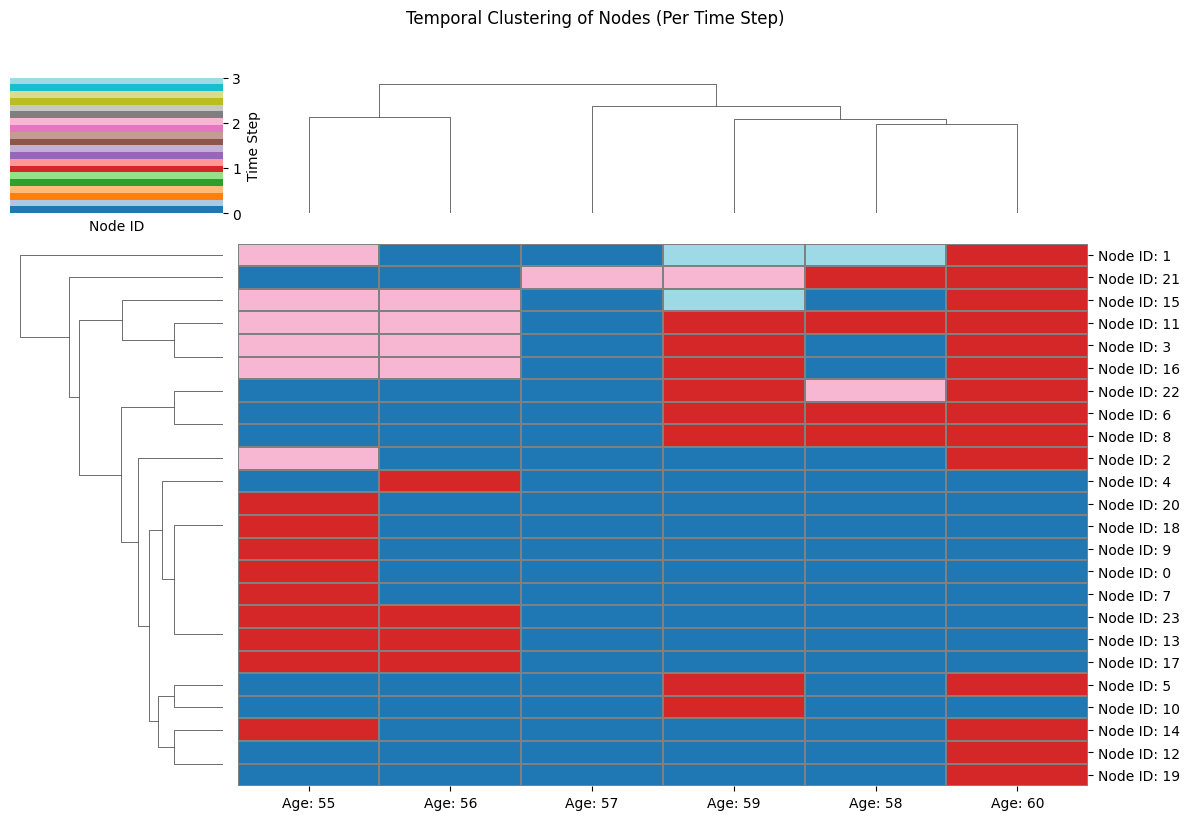

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score

# Assume final_node_embeddings_s.shape = [T, N, D]
final_node_embeddings_s = encoder(x_seq, edge_index_seq)

T, N, D = final_node_embeddings_s.shape
final_node_embeddings_s = final_node_embeddings_s.detach().numpy()

# Container for all cluster labels per time step
cluster_matrix = np.zeros((N, T), dtype=int)

# Perform clustering per time step
for t in range(T):
    embeddings_t = final_node_embeddings_s[t]  # shape: [N, D]

    # Standardize
    embeddings_scaled = StandardScaler().fit_transform(embeddings_t)


    # --- Clustering Metrics ---
    Best_k = -1
    Best_silhouette = -1
    Best_dbi = float('inf')
    Best_chi = -1

    # Perform clustering per time step using KMeans++
    for t in range(T):
        embeddings_t = final_node_embeddings_s[t]  # shape: [N, D]

        # Standardize
        embeddings_scaled = StandardScaler().fit_transform(embeddings_t)

        best_k = 2
        best_score = -1
        best_labels = None

        for k in range(2, min(N, 10)):
            kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
            labels = kmeans.fit_predict(embeddings_scaled)
            if len(set(labels)) == 1:
                continue
            score = silhouette_score(embeddings_scaled, labels)
            if score > best_score:
                best_score = score
                best_k = k
                best_labels = labels

        # Store cluster labels (0-based for coloring)
        cluster_matrix[:, t] = np.array(best_labels)


# Compute all three metrics
silhouette = silhouette_score(embeddings_scaled, best_labels)
dbi = davies_bouldin_score(embeddings_scaled, best_labels)
chi = calinski_harabasz_score(embeddings_scaled, best_labels)

print(f"\nBest K based on Silhouette Score: {best_k}")
print(f"  Silhouette Score = {silhouette:.4f} (Higher is better)")
print(f"  Davies-Bouldin Index = {dbi:.4f} (Lower is better)")
print(f"  Calinski-Harabasz Index = {chi:.4f} (Higher is better)")
print("---")

# Convert to DataFrame and transpose so rows = time steps, columns = nodes
cluster_df = pd.DataFrame(cluster_matrix, columns=[f"Node ID: {i}" for i in range(T)],
                          index=[f"Age: {i+55}" for i in range(N)]).T

# Plot clustered heatmap
sns.clustermap(cluster_df, cmap="tab20", linewidths=0.3, linecolor='gray',
               row_cluster=True, col_cluster=True, figsize=(12, 8),
               cbar_kws={'label': 'Cluster ID'})

plt.suptitle("Temporal Clustering of Nodes (Per Time Step)", y=1.02)
plt.xlabel("Node ID")
plt.ylabel("Time Step")
plt.tight_layout()
plt.show()
